In [1]:
mc.cores = parallel::detectCores()
#rstan_options(auto_write = TRUE)

library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
library(rethinking)
data(chimpanzees)
d <- chimpanzees

In [3]:
d$treatment <- 1 + d$prosoc_left + 2*d$condition

In [4]:
xtabs( ~ treatment + prosoc_left + condition , d )

, , condition = 0

         prosoc_left
treatment   0   1
        1 126   0
        2   0 126
        3   0   0
        4   0   0

, , condition = 1

         prosoc_left
treatment   0   1
        1   0   0
        2   0   0
        3 126   0
        4   0 126


In [5]:
m11.1 <- quap(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a ,
                a ~ dnorm( 0 , 10 )
            ) , data=d)

In [6]:
set.seed(1999)
prior <- extract.prior( m11.1 , n=1e4 )

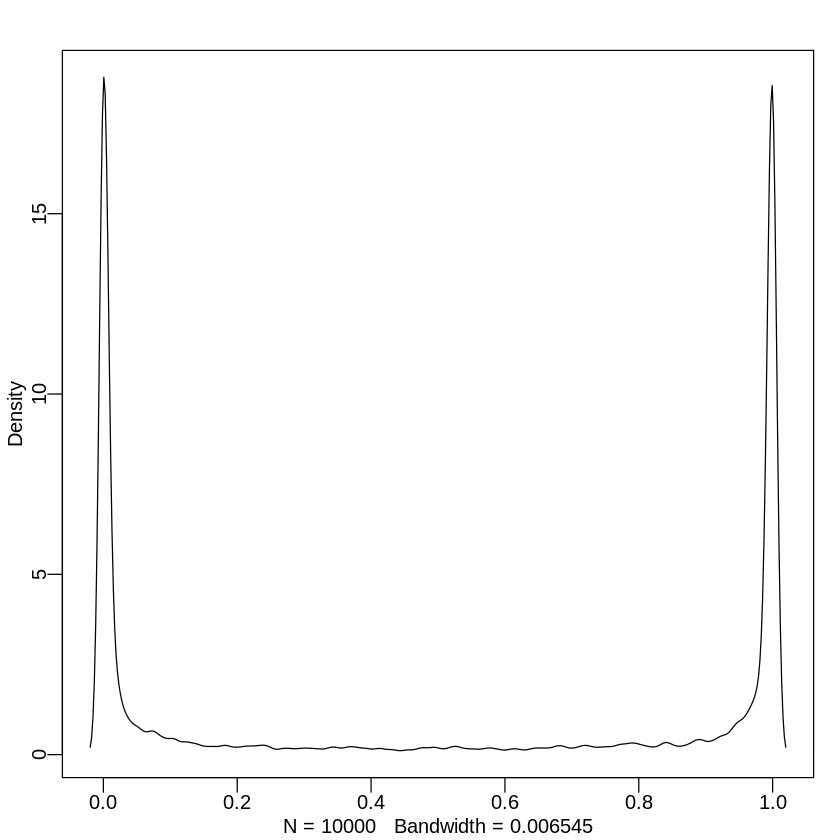

In [7]:
p <- inv_logit( prior$a )
dens( p , adj=0.1 )

In [8]:
m11.1b <- quap(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a ,
                a ~ dnorm( 0 , 1.5 )
            ) , data=d )

In [9]:
set.seed(1999)
prior_b <- extract.prior( m11.1b , n=1e8 )

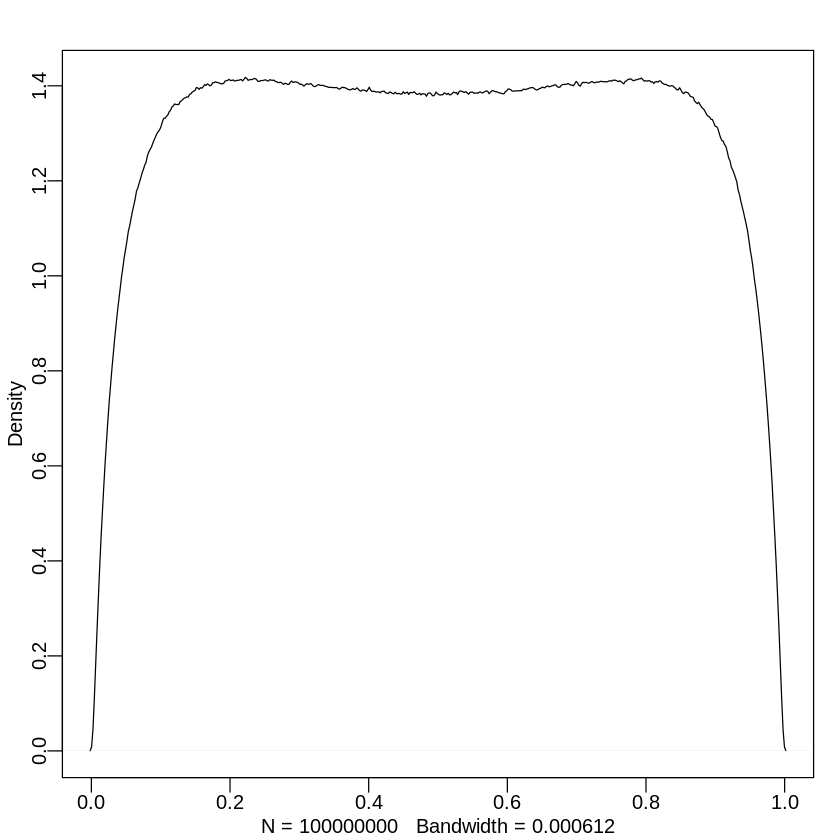

In [10]:
p_b <- inv_logit( prior_b$a )
dens( p_b , adj=0.1 )

In [11]:
m11.2 <- quap(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a + b[treatment] ,
                a ~ dnorm( 0 , 1.5 ),
                b[treatment] ~ dnorm( 0 , 10 )
            ) , data=d)

In [12]:
set.seed(1999)
prior <- extract.prior( m11.2 , n=1e4 )
p <- sapply( 1:4 , function(k) inv_logit( prior$a + prior$b[,k] ) )

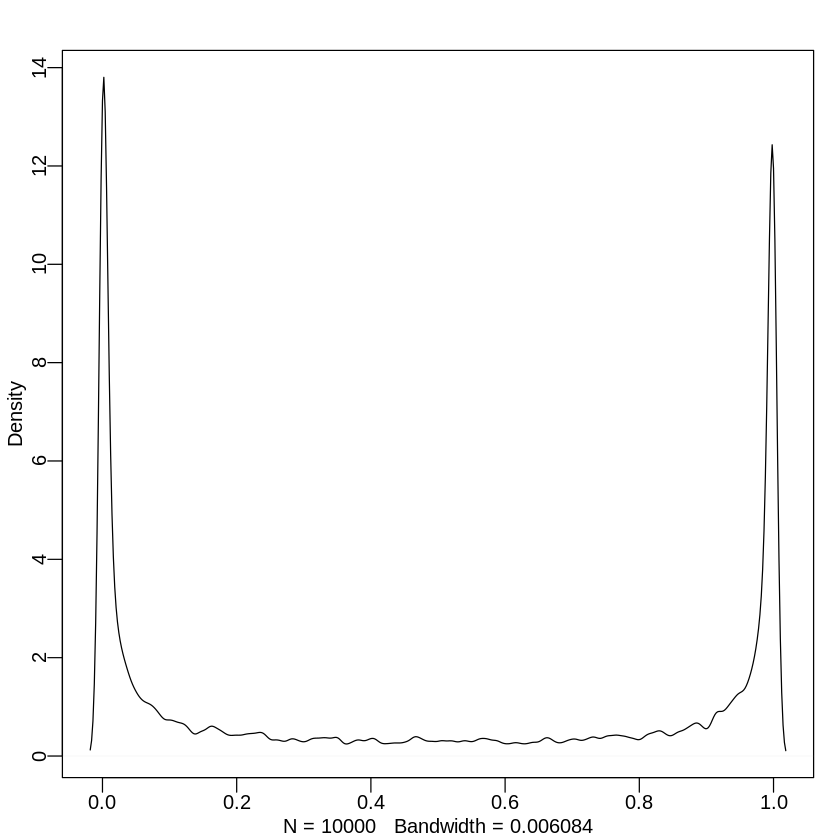

In [13]:
dens( abs( p[,1] - p[,2] ) , adj=0.1 )

In [14]:
m11.3 <- quap(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a + b[treatment] ,
                a ~ dnorm( 0 , 1.5 ),
                b[treatment] ~ dnorm( 0 , 0.5 )
            ) , data=d )

set.seed(1999)
prior <- extract.prior( m11.3 , n=1e4 )
p <- sapply( 1:4 , function(k) inv_logit( prior$a + prior$b[,k] ) )
mean( abs( p[,1] - p[,2] ) )

[1] 0.09838663

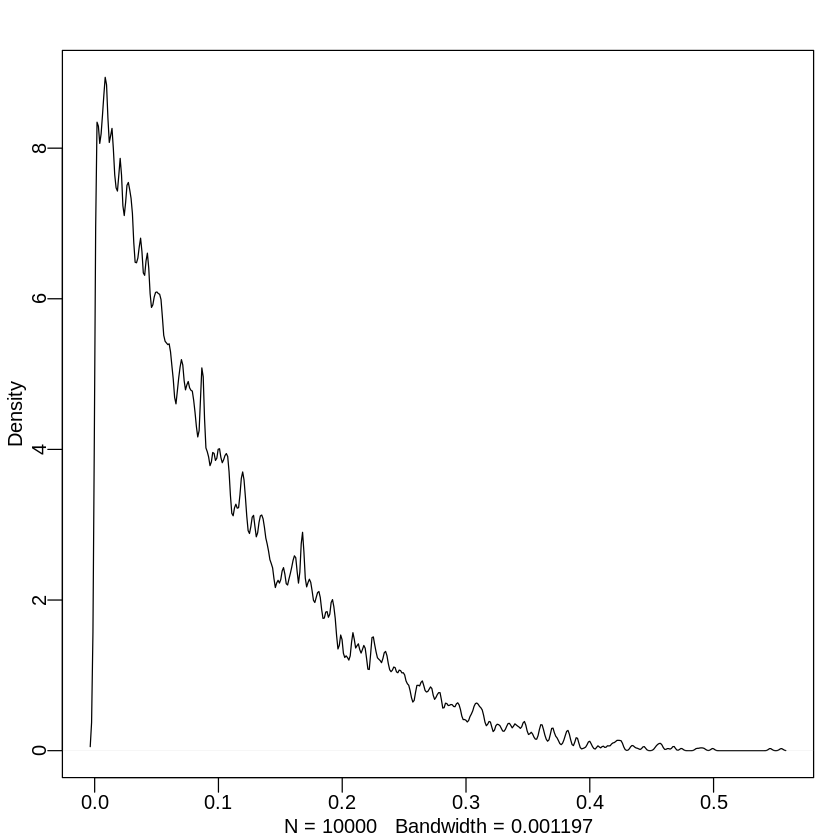

In [15]:
dens( abs( p[,1] - p[,2] ) , adj=0.1 )

In [16]:
# prior trimmed data list
dat_list <- list(
pulled_left = as.integer(d$pulled_left),
actor = as.integer(d$actor),
treatment = as.integer(d$treatment) )

# particles in 11-dimensional space
m11.4 <- ulam(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a[actor] + b[treatment] ,
                a[actor] ~ dnorm( 0 , 1.5 ),
                b[treatment] ~ dnorm( 0 , 0.5 )
            ) ,            
            data=dat_list , chains=4, cores=4
            , log_lik=TRUE 
        )

precis( m11.4 , depth=2 )

mean        sd        5.5%        94.5%       n_eff     Rhat     
a[1] -0.45155673 0.3248619 -0.95751885  0.09107047  700.9265 0.9994659
a[2]  3.88025530 0.7582082  2.73939660  5.16639383 1304.9239 1.0008341
a[3] -0.74527240 0.3445583 -1.29129858 -0.17328721  721.2855 1.0018021
a[4] -0.74877752 0.3372641 -1.28770759 -0.20584359  576.2836 1.0022789
a[5] -0.44688407 0.3411853 -0.98843594  0.09708149  686.5122 1.0006648
a[6]  0.47889045 0.3416448 -0.06865506  1.03372436  695.7983 1.0019772
a[7]  1.96171102 0.4218421  1.29392469  2.63849367  732.6365 1.0010198
b[1] -0.04342476 0.2885877 -0.49070036  0.42560869  564.1820 1.0030952
b[2]  0.48184202 0.2879374  0.02939375  0.94399083  596.3379 1.0009929
b[3] -0.38006096 0.2922734 -0.83801278  0.09737401  508.1740 1.0015353
b[4]  0.37201389 0.2817451 -0.08157364  0.81127690  640.6752 1.0007045

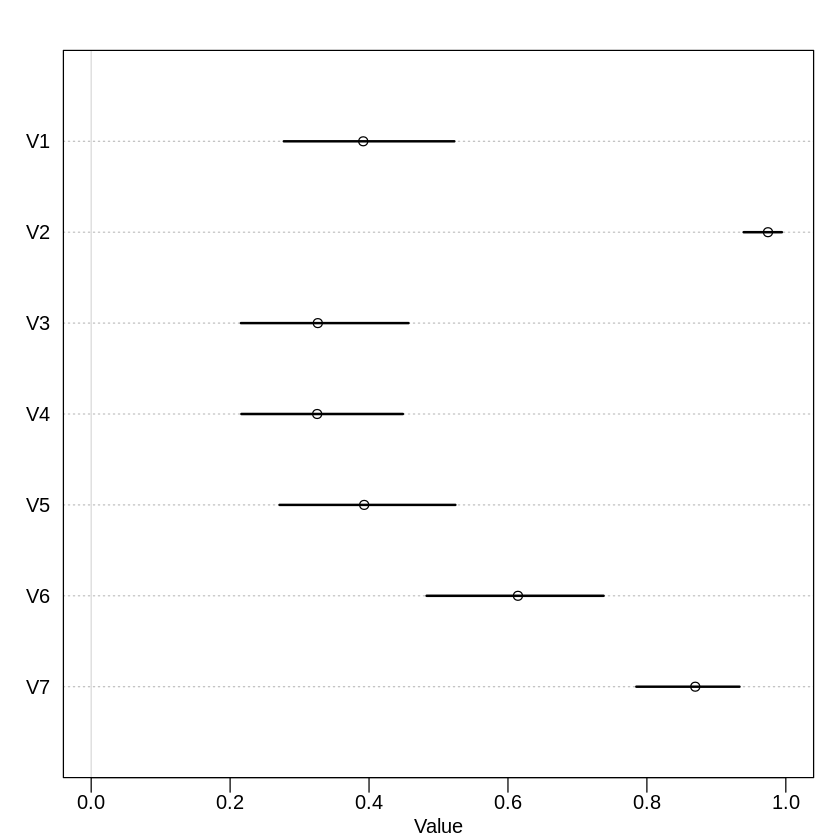

In [17]:
post <- extract.samples(m11.4)
p_left <- inv_logit( post$a )
plot( precis( as.data.frame(p_left) ) , xlim=c(0,1) )

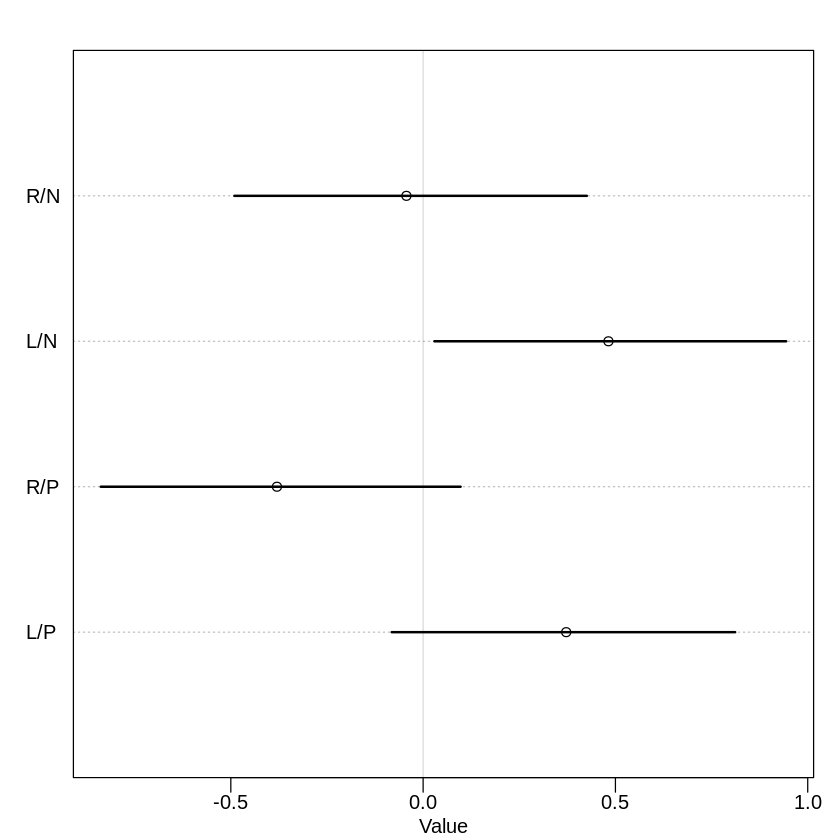

In [18]:
labs <- c("R/N","L/N","R/P","L/P")
plot( precis( m11.4 , depth=2 , pars="b" ) , labels=labs )

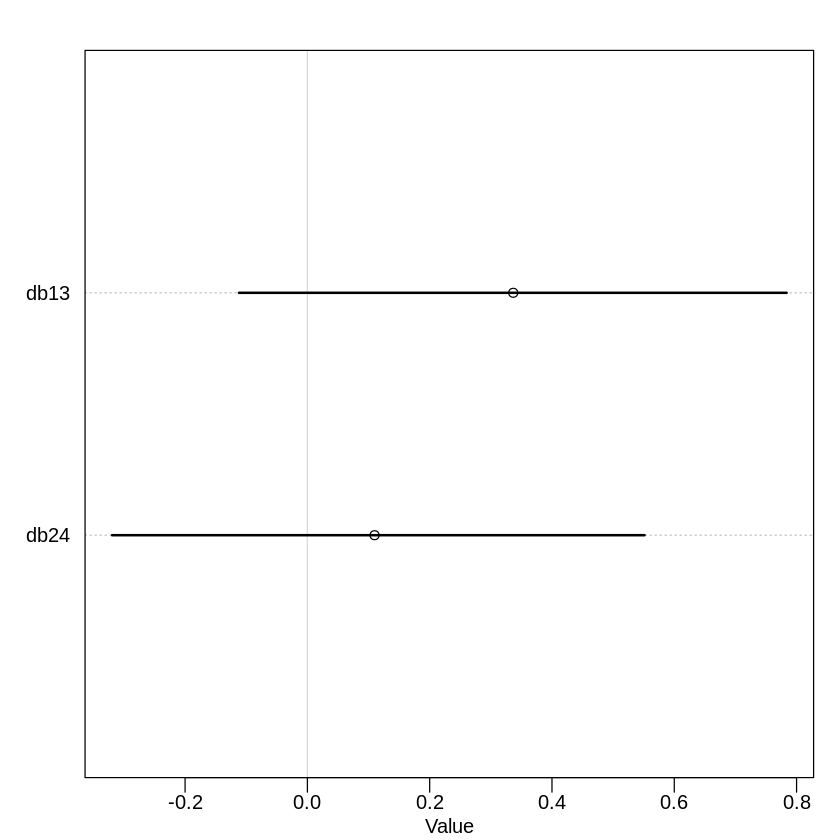

In [19]:
diffs <- list(
db13 = post$b[,1] - post$b[,3],
db24 = post$b[,2] - post$b[,4] )
plot( precis(diffs) )

In [20]:
pl <- by( d$pulled_left , list( d$actor , d$treatment ) , mean )
pl[1,]

1         2         3         4 
0.3333333 0.5000000 0.2777778 0.5555556

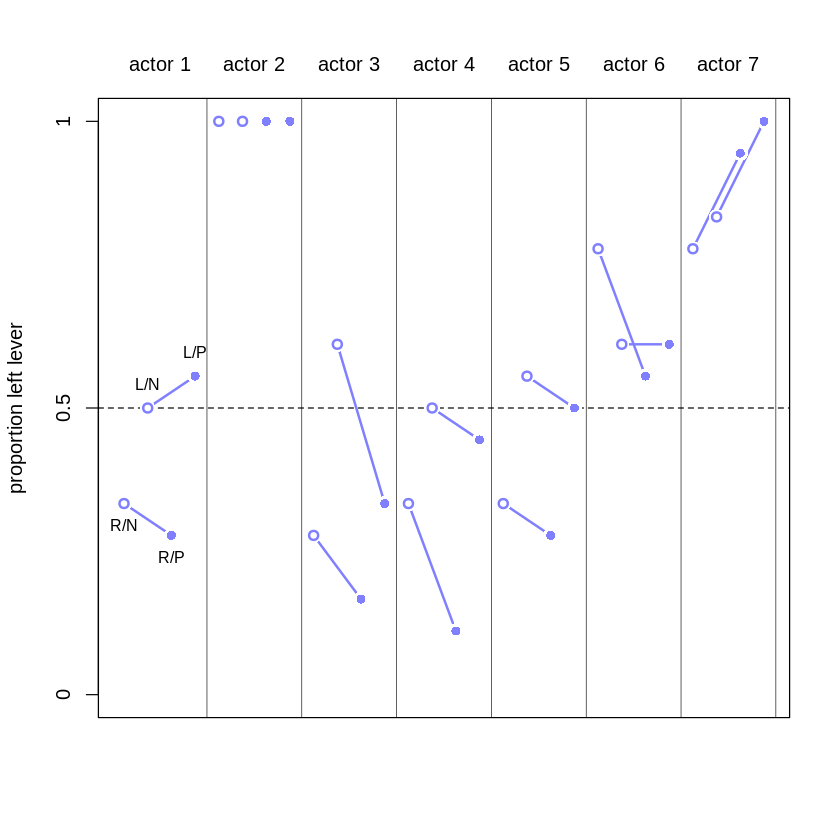

In [21]:
plot( NULL , xlim=c(1,28) , ylim=c(0,1) , xlab="" ,
ylab="proportion left lever" , xaxt="n" , yaxt="n" )
axis( 2 , at=c(0,0.5,1) , labels=c(0,0.5,1) )
abline( h=0.5 , lty=2 )
for ( j in 1:7 ) abline( v=(j-1)*4+4.5 , lwd=0.5 )
for ( j in 1:7 ) text( (j-1)*4+2.5 , 1.1 , concat("actor ",j) , xpd=TRUE )
for ( j in (1:7)[-2] ) {
lines( (j-1)*4+c(1,3) , pl[j,c(1,3)] , lwd=2 , col=rangi2 )
lines( (j-1)*4+c(2,4) , pl[j,c(2,4)] , lwd=2 , col=rangi2 )
}
points( 1:28 , t(pl) , pch=16 , col="white" , cex=1.7 )
points( 1:28 , t(pl) , pch=c(1,1,16,16) , col=rangi2 , lwd=2 )
yoff <- 0.01
text( 1 , pl[1,1]-yoff , "R/N" , pos=1 , cex=0.8 )
text( 2 , pl[1,2]+yoff , "L/N" , pos=3 , cex=0.8 )
text( 3 , pl[1,3]-yoff , "R/P" , pos=1 , cex=0.8 )
text( 4 , pl[1,4]+yoff , "L/P" , pos=3 , cex=0.8 )
#mtext( "observed proportions\n" )

In [22]:
dat <- list( actor=rep(1:7,each=4) , treatment=rep(1:4,times=7) )
p_post <- link_ulam( m11.4 , data=dat )
p_mu <- apply( p_post , 2 , mean )
p_ci <- apply( p_post , 2 , PI )

# p_muMat = matrix(list(), nrow=7, ncol=4)

# for (j in 1:7) {                 #actor
#     for (k in 1:4) {             #treatment    
#         p_muMat[[j,k]] <- p_mu[4*(j-1)+k]          #Note, this indexing is based on the assumed iterations of dat 
#         print(p_muMat[[j,k]])
#     }
# }

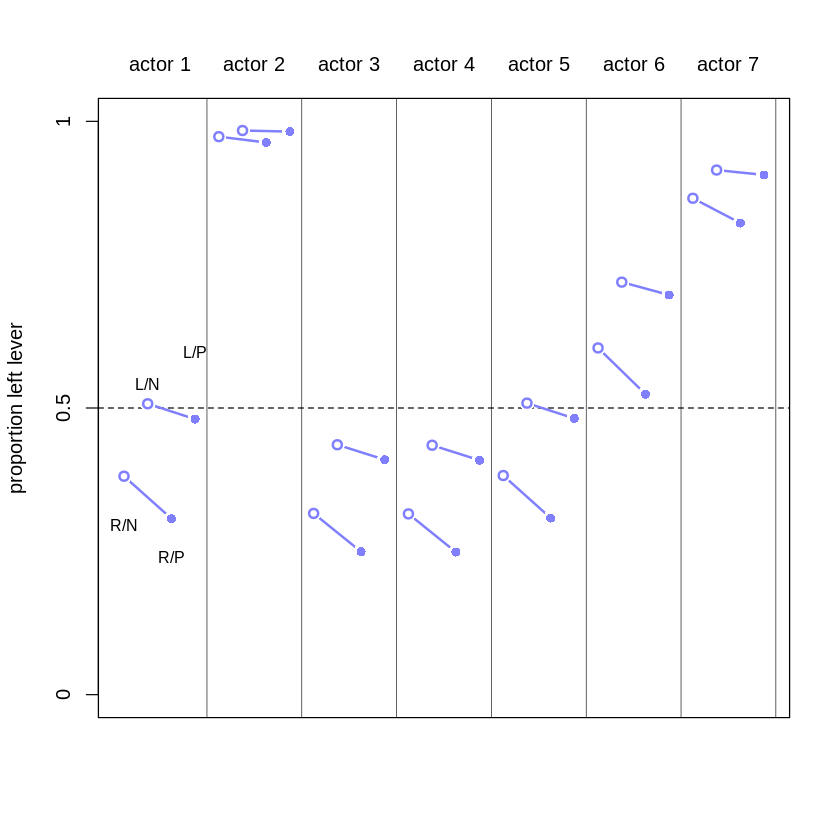

In [23]:
plot( NULL , xlim=c(1,28) , ylim=c(0,1) , xlab="" ,
ylab="proportion left lever" , xaxt="n" , yaxt="n" )
axis( 2 , at=c(0,0.5,1) , labels=c(0,0.5,1) )
abline( h=0.5 , lty=2 )
for ( j in 1:7 ) abline( v=(j-1)*4+4.5 , lwd=0.5 )
for ( j in 1:7 ) text( (j-1)*4+2.5 , 1.1 , concat("actor ",j) , xpd=TRUE )
for ( j in (1:7) ) {
    lines( (j-1)*4+c(1,3) , p_mu[4*(j-1)+c(1,3)] , lwd=2 , col=rangi2 )
    lines( (j-1)*4+c(2,4) , p_mu[4*(j-1)+c(2,4)] , lwd=2 , col=rangi2 )
}
points( 1:28 , t(p_mu) , pch=16 , col="white" , cex=1.7 )
points( 1:28 , t(p_mu) , pch=c(1,1,16,16) , col=rangi2 , lwd=2 )
yoff <- 0.01
text( 1 , pl[1,1]-yoff , "R/N" , pos=1 , cex=0.8 )
text( 2 , pl[1,2]+yoff , "L/N" , pos=3 , cex=0.8 )
text( 3 , pl[1,3]-yoff , "R/P" , pos=1 , cex=0.8 )
text( 4 , pl[1,4]+yoff , "L/P" , pos=3 , cex=0.8 )
#mtext( "predicted proportions\n" )

In [24]:
d$side <- d$prosoc_left + 1 # right 1, left 2
d$cond <- d$condition + 1 # no partner 1, partner 2

In [25]:
dat_list2 <- list(
                pulled_left = as.integer(d$pulled_left),
                actor = as.integer(d$actor),
                side = as.integer(d$side),
                cond = as.integer(d$cond) )

m11.5 <- ulam(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a[actor] + bs[side] + bc[cond] ,
                a[actor] ~ dnorm( 0 , 1.5 ),
                bs[side] ~ dnorm( 0 , 0.5 ),
                bc[cond] ~ dnorm( 0 , 0.5 )
            ) ,
            data=dat_list2 , chains=4 , cores=4, log_lik=TRUE )

In [26]:
compare( m11.5 , m11.4 , func=LOO )

LOO      pLOO     dLOO     weight    SE       dSE     
m11.5 530.3206 7.523766 0.000000 0.7300977 19.11186       NA
m11.4 532.3109 8.493251 1.990237 0.2699023 18.95250 1.280434

In [27]:
precis(m11.5, depth=2)

mean        sd        5.5%        94.5%       n_eff     Rhat    
a[1]  -0.63713281 0.4438332 -1.33861606  0.09561636  766.0570 1.002727
a[2]   3.72864608 0.7732747  2.58444164  5.04503536 1017.2935 1.003028
a[3]  -0.93303787 0.4542671 -1.63696092 -0.19786595  779.1328 1.003104
a[4]  -0.93580550 0.4381256 -1.62080485 -0.24258468  821.4855 1.002147
a[5]  -0.63820213 0.4450523 -1.34120497  0.08351570  864.1668 1.000571
a[6]   0.28822282 0.4432984 -0.42385617  0.98939558  865.8206 1.004941
a[7]   1.77819105 0.5045040  0.97161291  2.59139577  872.1537 1.005493
bs[1] -0.19466021 0.3266472 -0.72352779  0.32750660  915.2004 1.000597
bs[2]  0.49367316 0.3323763 -0.02578936  1.02167614  907.6227 1.000653
bc[1]  0.27901904 0.3299752 -0.24484476  0.81665978  764.0151 1.002513
bc[2]  0.02860271 0.3314261 -0.49655296  0.54340334  798.5299 1.000731

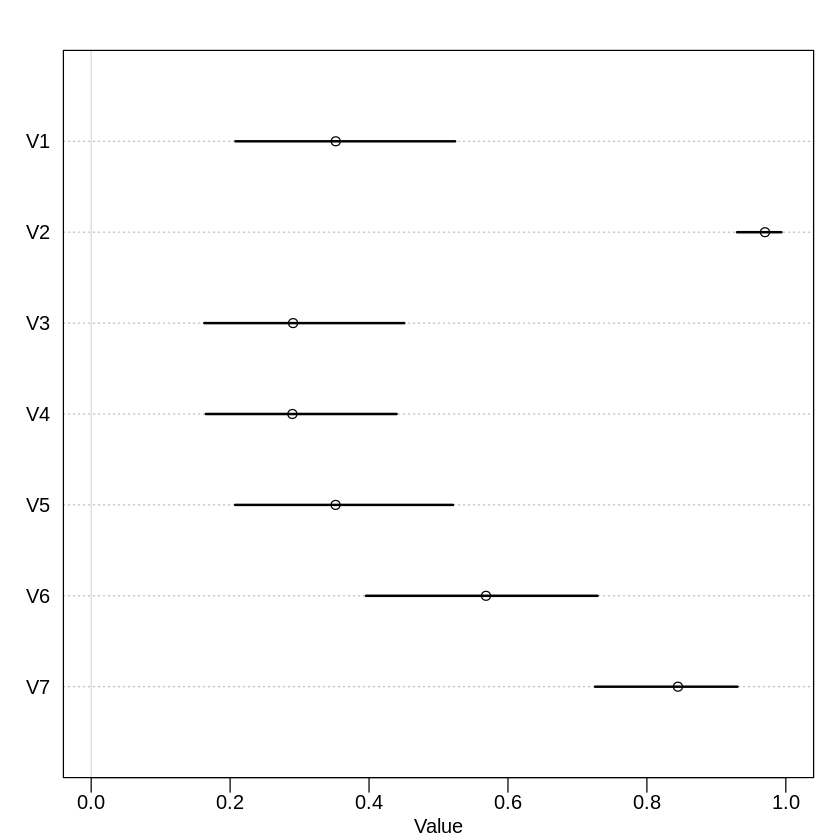

In [28]:
post <- extract.samples(m11.5)
p_left <- inv_logit( post$a )
plot( precis( as.data.frame(p_left) ) , xlim=c(0,1) )

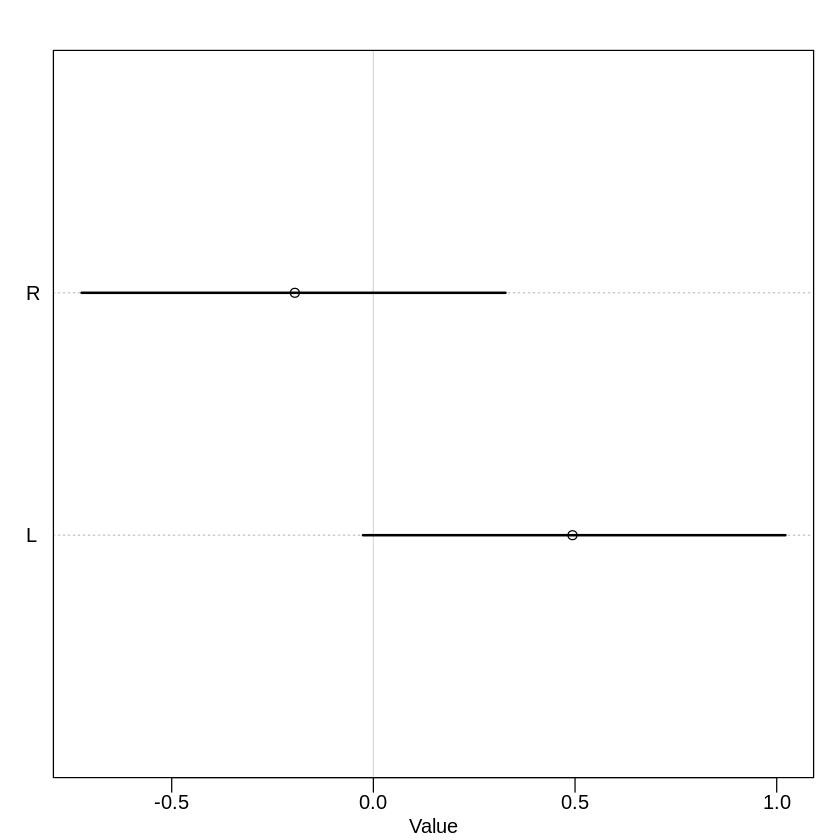

In [29]:
labs <- c("R","L")
plot( precis( m11.5 , depth=2 , pars=c("bs") ) , labels=labs )

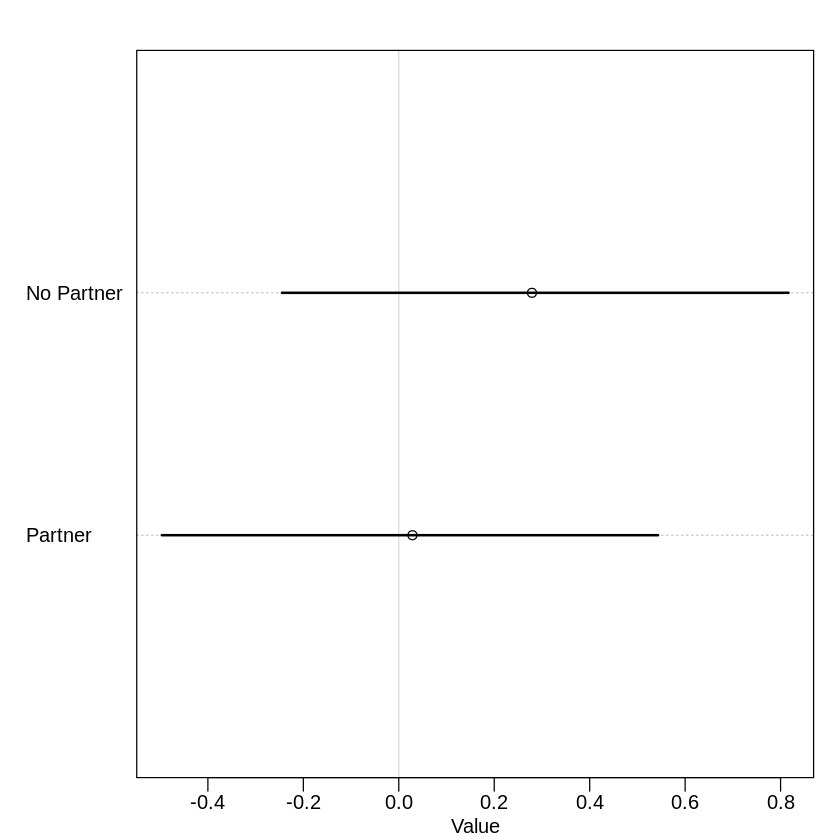

In [30]:
labs <- c("No Partner","Partner")
plot( precis( m11.5 , depth=2 , pars=c("bc") ) , labels=labs )

In [31]:
post <- extract.samples( m11.4 , clean=FALSE )
str(post)

List of 4
 $ log_lik: num [1:2000, 1:504] -0.506 -0.478 -0.445 -0.46 -0.273 ...
 $ a      : num [1:2000, 1:7] -0.554 -0.583 -0.979 -0.856 -1.021 ...
 $ b      : num [1:2000, 1:4] 0.1364 0.0947 0.4004 0.3182 -0.1363 ...
 $ lp__   : num [1:2000(1d)] -268 -266 -269 -270 -274 ...
 - attr(*, "source")= chr "ulam posterior: 2000 samples from m11.4"


In [32]:
stancode(m11.4)

data{
    int pulled_left[504];
    int treatment[504];
    int actor[504];
}
parameters{
    vector[7] a;
    vector[4] b;
}
model{
    vector[504] p;
    b ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    pulled_left ~ binomial( 1 , p );
}
generated quantities{
    vector[504] log_lik;
    vector[504] p;
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    for ( i in 1:504 ) log_lik[i] = binomial_lpmf( pulled_left[i] | 1 , p[i] );
}



In [33]:
m11.4_stan_code <- stancode(m11.4)
m11.4_stan <- stan( model_code=m11.4_stan_code , data=dat_list , chains=4, cores=4 )
compare( m11.4_stan , m11.4 )

data{
    int pulled_left[504];
    int treatment[504];
    int actor[504];
}
parameters{
    vector[7] a;
    vector[4] b;
}
model{
    vector[504] p;
    b ~ normal( 0 , 0.5 );
    a ~ normal( 0 , 1.5 );
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    pulled_left ~ binomial( 1 , p );
}
generated quantities{
    vector[504] log_lik;
    vector[504] p;
    for ( i in 1:504 ) {
        p[i] = a[actor[i]] + b[treatment[i]];
        p[i] = inv_logit(p[i]);
    }
    for ( i in 1:504 ) log_lik[i] = binomial_lpmf( pulled_left[i] | 1 , p[i] );
}



recompiling to avoid crashing R session
Warning message in compare(m11.4_stan, m11.4):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”

WAIC     pWAIC    dWAIC    weight    SE       dSE       
m11.4_stan 532.0418 8.370793 0.000000 0.5252168 18.91850         NA
m11.4      532.2437 8.459682 0.201906 0.4747832 18.93002 0.09709988

In [34]:
post <- extract.samples(m11.4)
mean( exp(post$b[,4]-post$b[,2]) )

[1] 0.9291066

In [35]:
data(chimpanzees)
d <- chimpanzees

d$treatment <- 1 + d$prosoc_left + 2*d$condition
d$side <- d$prosoc_left + 1 # right 1, left 2
d$cond <- d$condition + 1 # no partner 1, partner 2
d_aggregated <- aggregate(
                        d$pulled_left ,
                        list( treatment=d$treatment , actor=d$actor ,
                        side=d$side , cond=d$cond ) ,
                        sum )

colnames(d_aggregated)[5] <- "left_pulls"

In [36]:
dat <- with( d_aggregated , list(
    left_pulls = as.integer(left_pulls),
    treatment = as.integer(treatment),
    actor = as.integer(actor),
    side = as.integer(side),
    cond = as.integer(cond) ) )

m11.6 <- ulam(
            alist(
                left_pulls ~ dbinom( 18 , p ) ,
                logit(p) <- a[actor] + b[treatment] ,
                a[actor] ~ dnorm( 0 , 1.5 ) ,
                b[treatment] ~ dnorm( 0 , 0.5 )
            ) ,
            data=dat , chains=4 , cores = 4, log_lik=TRUE )

In [37]:
precis(m11.6, depth=2)

mean        sd        5.5%        94.5%       n_eff     Rhat    
a[1] -0.44553776 0.3244384 -0.96586781  0.07915137  819.5188 1.002669
a[2]  3.90903953 0.7541306  2.74067070  5.16841813 1251.0538 1.001746
a[3] -0.73774466 0.3377484 -1.27192381 -0.20346478  819.5574 1.002046
a[4] -0.74561112 0.3320157 -1.29659076 -0.22054288  858.2828 1.000916
a[5] -0.44511456 0.3225309 -0.97654198  0.08822611  800.8825 1.000276
a[6]  0.48185814 0.3390893 -0.05165398  1.02343039  855.0672 1.000820
a[7]  1.94871956 0.4077015  1.31172932  2.61370631  968.8555 1.001119
b[1] -0.04596465 0.2851596 -0.50056509  0.41707192  759.7261 1.004212
b[2]  0.48317490 0.2823704  0.03943336  0.94094437  729.0200 1.001439
b[3] -0.38621818 0.2860432 -0.84088923  0.07196680  761.1300 1.002260
b[4]  0.36358221 0.2780114 -0.08990646  0.80681565  743.7946 1.000760

In [38]:
precis(m11.4, depth=2)

mean        sd        5.5%        94.5%       n_eff     Rhat     
a[1] -0.45155673 0.3248619 -0.95751885  0.09107047  700.9265 0.9994659
a[2]  3.88025530 0.7582082  2.73939660  5.16639383 1304.9239 1.0008341
a[3] -0.74527240 0.3445583 -1.29129858 -0.17328721  721.2855 1.0018021
a[4] -0.74877752 0.3372641 -1.28770759 -0.20584359  576.2836 1.0022789
a[5] -0.44688407 0.3411853 -0.98843594  0.09708149  686.5122 1.0006648
a[6]  0.47889045 0.3416448 -0.06865506  1.03372436  695.7983 1.0019772
a[7]  1.96171102 0.4218421  1.29392469  2.63849367  732.6365 1.0010198
b[1] -0.04342476 0.2885877 -0.49070036  0.42560869  564.1820 1.0030952
b[2]  0.48184202 0.2879374  0.02939375  0.94399083  596.3379 1.0009929
b[3] -0.38006096 0.2922734 -0.83801278  0.09737401  508.1740 1.0015353
b[4]  0.37201389 0.2817451 -0.08157364  0.81127690  640.6752 1.0007045

In [39]:
compare(m11.6, m11.4, func=LOO)

Warning message in compare(m11.6, m11.4, func = LOO):
“Different numbers of observations found for at least two models.
Information criteria only valid for comparing models fit to exactly same observations.
Number of observations for each model:
m11.6 28 
m11.4 504 
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO      pLOO     dLOO     weight       SE        dSE     
m11.6 113.8282 8.204912   0.0000 1.000000e+00  8.324514       NA
m11.4 532.3109 8.493251 418.4827 1.341672e-91 18.952501 9.376231

In [40]:
# deviance of aggregated 6-in-9
-2*dbinom(6,9,0.2,log=TRUE)
# deviance of dis-aggregated
-2*sum(dbern(c(1,1,1,1,1,1,0,0,0),0.2,log=TRUE))

[1] 11.79048

[1] 20.65212

In [41]:
( k <- LOOPk(m11.6) )

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

[1] 0.19370045 0.18013173 0.22094518 0.16906709 0.24666529 0.42069010
 [7] 0.32418164 0.49935763 0.01009924 0.74633272 0.39295021 0.29923406
[13] 0.30077704 0.32753657 0.37664328 0.51698225 0.33961843 0.42013689
[19] 0.44016449 0.45043945 0.55408569 0.57754740 0.19728003 0.53346666
[25] 0.51798687 0.22508643 0.49766488 0.31736470

In [42]:
library(rethinking)
data(UCBadmit)
d <- UCBadmit
head(d)

dept applicant.gender admit reject applications
1 A    male             512   313    825         
2 A    female            89    19    108         
3 B    male             353   207    560         
4 B    female            17     8     25         
5 C    male             120   205    325         
6 C    female           202   391    593

In [43]:
d$gid <- ifelse( d$applicant.gender=="male" , 1 , 2 )

m11.7 <- quap(
            alist(
                admit ~ dbinom( applications , p ) ,
                logit(p) <- a[gid] ,
                a[gid] ~ dnorm( 0 , 1.5 )
                ) , data=d )

precis( m11.7 , depth=2 )

mean       sd         5.5%       94.5%     
a[1] -0.2199869 0.03877483 -0.2819566 -0.1580173
a[2] -0.8295362 0.05073357 -0.9106183 -0.7484542

In [44]:
post <- extract.samples(m11.7)

diff_a <- post$a[,1] - post$a[,2]
diff_p <- inv_logit(post$a[,1]) - inv_logit(post$a[,2])

precis( list( diff_a=diff_a , diff_p=diff_p ) )

mean      sd         5.5%      94.5%     histogram   
diff_a 0.6101835 0.06396001 0.5070183 0.7121378 ▁▁▁▃▇▇▅▂▁▁▁ 
diff_p 0.1415416 0.01439650 0.1181923 0.1643688 ▁▁▁▂▃▇▇▅▂▁▁▁

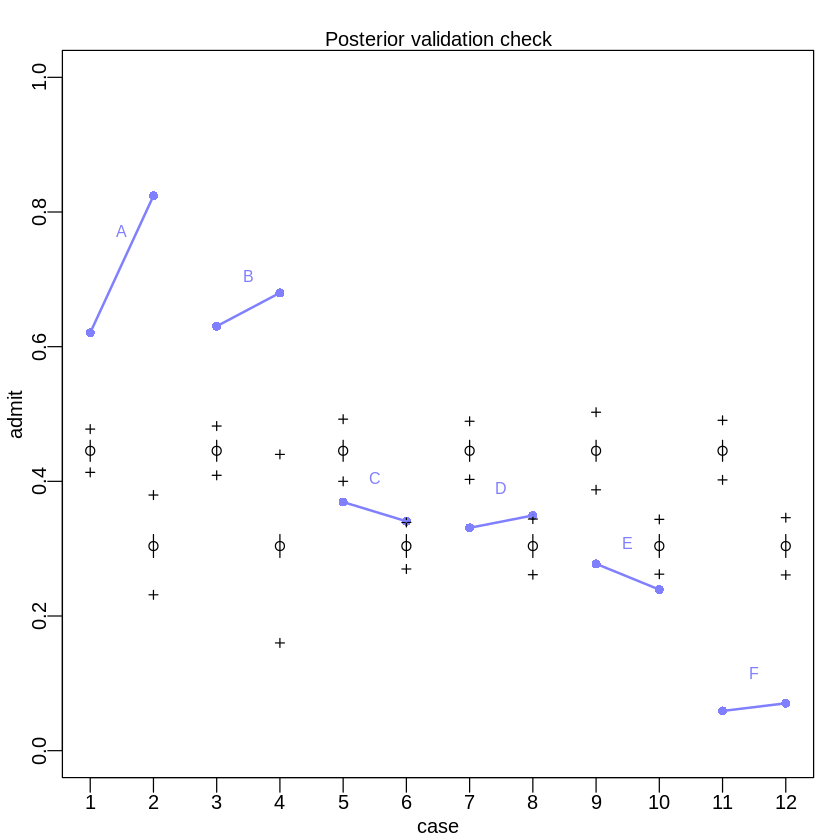

In [45]:
postcheck( m11.7 , n=1e4 )

# draw lines connecting points from same dept
d$dept_id <- rep( 1:6 , each=2 )
for ( i in 1:6 ) {
    x <- 1 + 2*(i-1)
    y1 <- d$admit[x]/d$applications[x]
    y2 <- d$admit[x+1]/d$applications[x+1]
    lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
    text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [46]:
#d$dept_id <- rep(1:6,each=2)
d$dept_id <- coerce_index(d$dept)

m11.8 <- quap(
            alist(
                admit ~ dbinom( applications , p ) ,
                logit(p) <- a[gid] + delta[dept_id] ,
                a[gid] ~ dnorm( 0 , 1.5 ) ,
                delta[dept_id] ~ dnorm( 0 , 1.5 )
            ) , data=d )

precis( m11.8 , depth=2 )

mean       sd        5.5%       94.5%     
a[1]     -0.5277303 0.5322783 -1.3784138  0.3229533
a[2]     -0.4310369 0.5330873 -1.2830134  0.4209395
delta[1]  1.1078380 0.5350322  0.2527532  1.9629229
delta[2]  1.0630456 0.5371968  0.2045013  1.9215898
delta[3] -0.1504277 0.5347763 -1.0051035  0.7042481
delta[4] -0.1828394 0.5350901 -1.0380167  0.6723380
delta[5] -0.6248337 0.5378490 -1.4844203  0.2347528
delta[6] -2.1728566 0.5468623 -3.0468481 -1.2988650

In [47]:
post <- extract.samples(m11.8)
diff_a <- post$a[,1] - post$a[,2]
diff_p <- inv_logit(post$a[,1]) - inv_logit(post$a[,2])
precis( list( diff_a=diff_a , diff_p=diff_p ) )

mean        sd         5.5%        94.5%       histogram     
diff_a -0.09714424 0.08072887 -0.22501738 0.032848442 ▁▁▁▁▂▅▇▇▅▂▁▁▁▁
diff_p -0.02169192 0.01840826 -0.05185965 0.007236311 ▁▁▁▂▇▇▂▁▁

In [48]:
pg <- sapply( 1:6 , function(k)
                        d$applications[d$dept_id==k]/sum(d$applications[d$dept_id==k]) )
rownames(pg) <- c("male","female")
colnames(pg) <- unique(d$dept)
round( pg , 2 )

A    B    C    D    E    F   
male   0.88 0.96 0.35 0.53 0.33 0.52
female 0.12 0.04 0.65 0.47 0.67 0.48

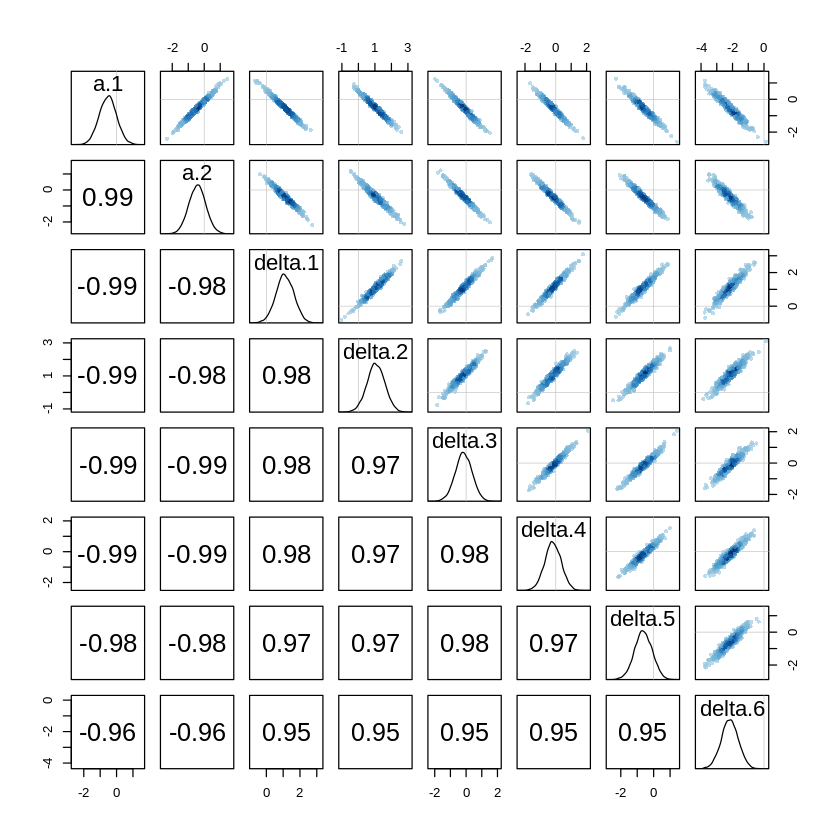

In [49]:
pairs(m11.8)

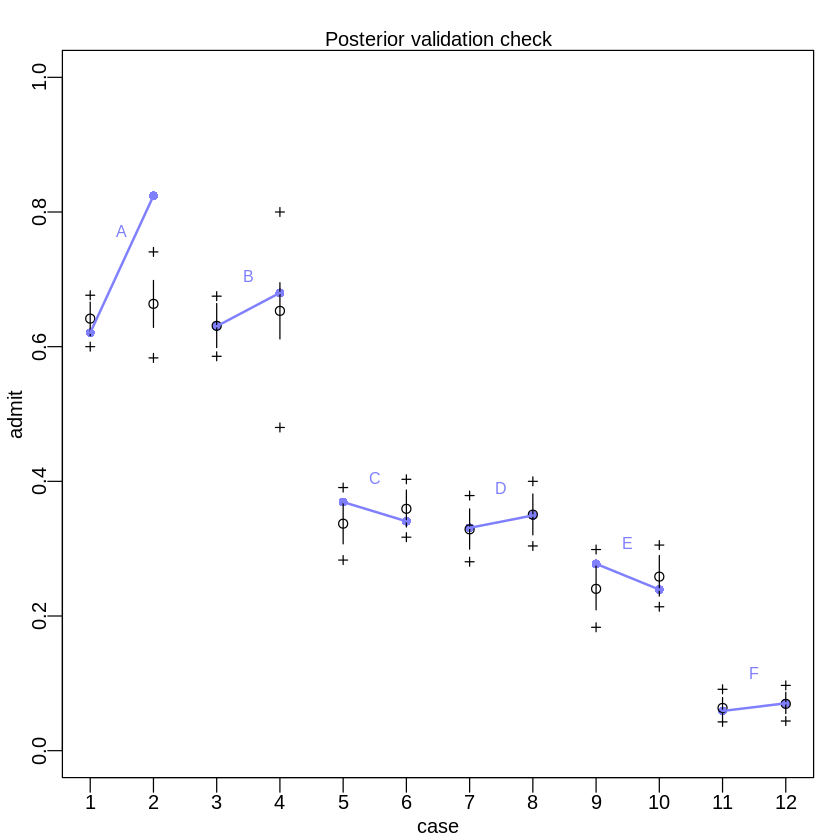

In [50]:
postcheck(m11.8)

# draw lines connecting points from same dept
d$dept_id <- rep( 1:6 , each=2 )
for ( i in 1:6 ) {
    x <- 1 + 2*(i-1)
    y1 <- d$admit[x]/d$applications[x]
    y2 <- d$admit[x+1]/d$applications[x+1]
    lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
    text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [51]:
# simulate career choices among 500 individuals
N <- 500 # number of individuals
income <- 1:3 # expected income of each career
score <- 0.5*income # scores for each career, based on income
# next line converts scores to probabilities
p <- softmax(score[1],score[2],score[3])

# now simulate choice
# outcome career holds event type values, not counts
career <- rep(NA,N) # empty vector of choices for each individual
# sample chosen career for each individual
for ( i in 1:N ) career[i] <- sample( 1:3 , size=1 , prob=p )

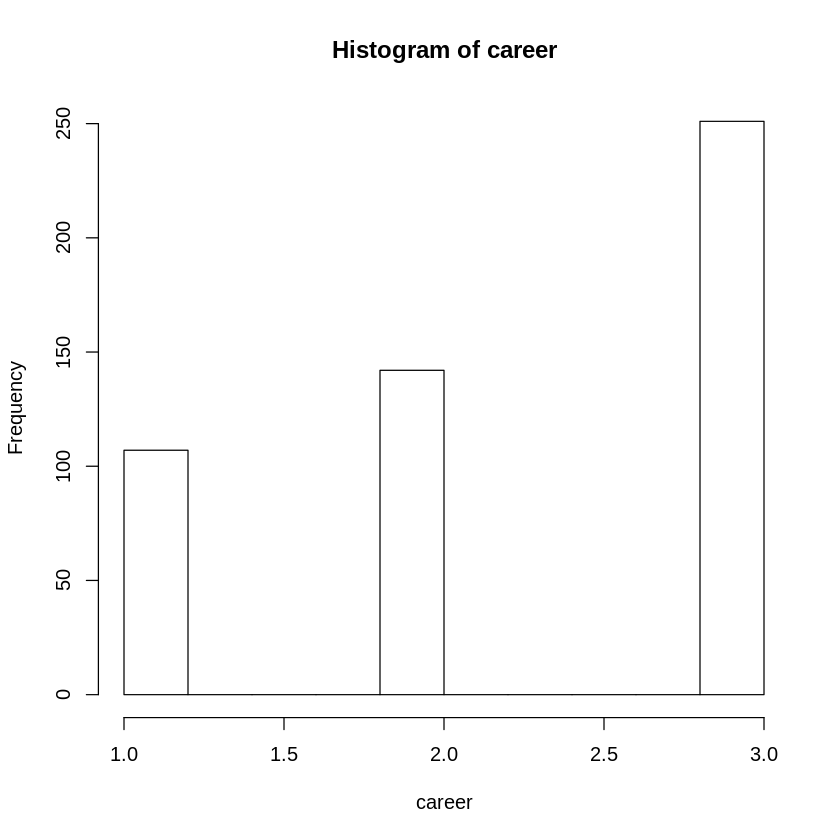

In [52]:
hist(career)

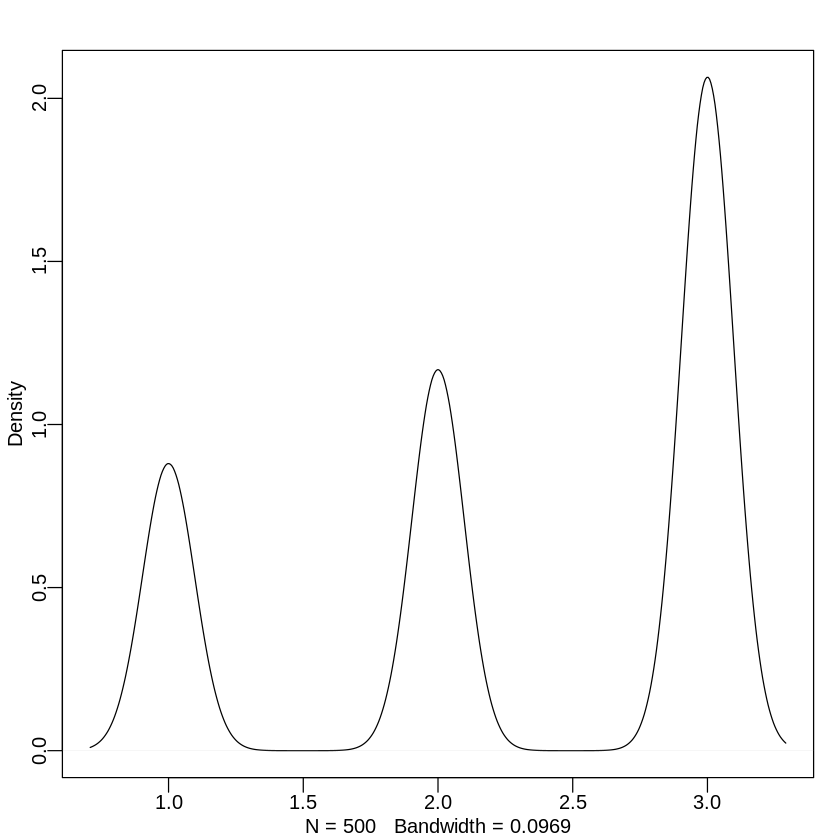

In [53]:
dens(career)

In [54]:
# fit the model, using dcategorical and softmax link
m10.16 <- map(
            alist(
            career ~ dcategorical( softmax(0,s2,s3) ),
            s2 <- b*2,
            # linear model for event type 2
            s3 <- b*3,
            # linear model for event type 3
            b ~ dnorm(0,5)
            ) ,
            data=list(career=career) )

In [55]:
precis(m10.16)

mean      sd         5.5%      94.5%    
b 0.2893335 0.04032278 0.2248899 0.3537771

In [56]:
post <- extract.samples(m10.16)

b <- post$b
zeros <- rep(0, length(b))
scores <- data.frame(zeros, 2*b, 3*b)
p <- softmax(scores)

#precis( list( b=b , scores=scores, p=p ) )
precis(list(p=p), depth=2)

mean      sd          5.5%      94.5%     histogram      
p[1] 0.1940805 0.016198771 0.1686761 0.2205495 ▁▁▂▃▇▇▇▃▁▁▁▁▁▁ 
p[2] 0.3449400 0.001129287 0.3427457 0.3460203 ▁▁▁▁▁▁▂▃▇▁     
p[3] 0.4609795 0.017203478 0.4334234 0.4885772 ▁▁▁▁▁▂▅▇▇▅▂▁▁▁▁

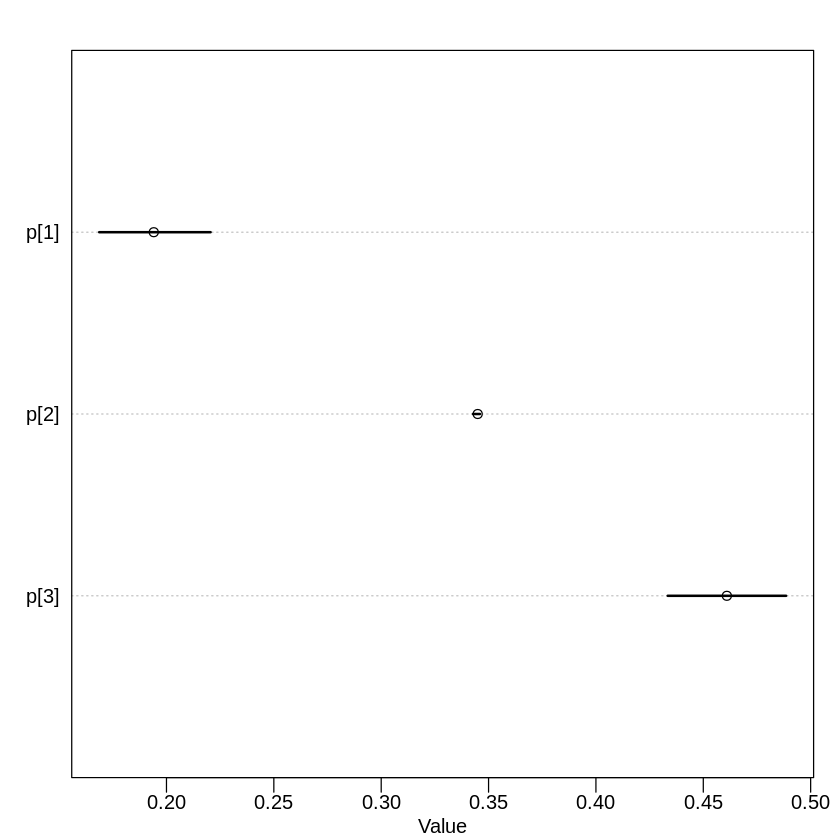

In [57]:
plot(precis(list(p=p), depth=2))

In [58]:
N <- 100
# simulate family incomes for each individual

family_income <- runif(N)
# assign a unique coefficient for each type of event

b <- (1:-1)
career <- rep(NA,N) # empty vector of choices for each individual

for ( i in 1:N ) {
    score <- 0.5*(1:3) + b*family_income[i]
    p <- softmax(score[1],score[2],score[3])
    career[i] <- sample( 1:3 , size=1 , prob=p )
}

m10.17 <- map(
            alist(
                career ~ dcategorical( softmax(0,s2,s3) ),
                s2 <- a2 + b2*family_income,
                s3 <- a3 + b3*family_income,
                c(a2,a3,b2,b3) ~ dnorm(0,5)
            ) ,
            data=list(career=career,family_income=family_income) )

In [59]:
precis(m10.17)

mean       sd        5.5%       94.5%    
a2  0.3041407 0.4971993 -0.4904797 1.0987612
a3 -0.1443563 0.5232521 -0.9806142 0.6919016
b2 -1.2165610 0.8519709 -2.5781751 0.1450531
b3 -0.1990054 0.8419557 -1.5446133 1.1466024

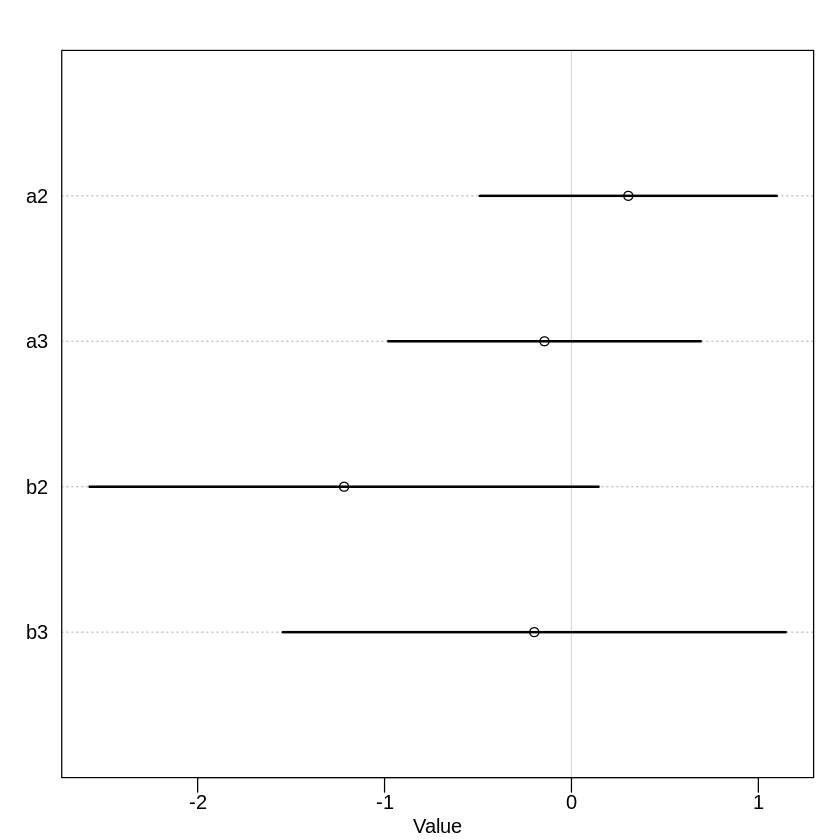

In [60]:
plot(precis(m10.17))

In [61]:
post <- extract.samples(m10.17)

fi.seq <- seq( from=0 , to=1 , length.out=30 )
s2 <- post$a2 + post$b2*fi.seq
s3 <- post$a3 + post$b3*fi.seq
#zeros <- rep(0, length(post))
scores <- data.frame(0, s2, s3)
p <- softmax(scores)

precis(list(p=p), depth=2)

Warning message in post$b2 * fi.seq:
“longer object length is not a multiple of shorter object length”Warning message in post$b3 * fi.seq:
“longer object length is not a multiple of shorter object length”

mean      sd         5.5%      94.5%     histogram     
p[1] 0.3933012 0.08293252 0.2572681 0.5251316 ▁▁▁▂▅▇▇▃▂▁▁▁▁▁
p[2] 0.2973385 0.09310390 0.1575925 0.4596297 ▁▁▃▅▇▇▃▂▁▁▁▁▁▁
p[3] 0.3093603 0.06859743 0.2034260 0.4200848 ▁▁▁▃▇▇▃▂▁▁▁▁▁

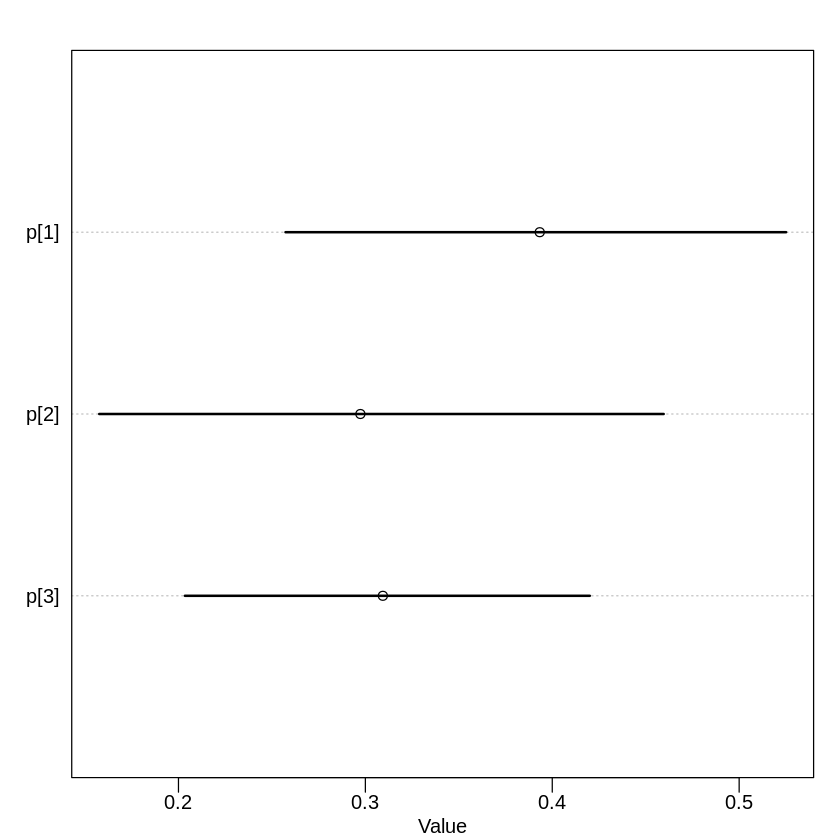

In [62]:
plot(precis(list(p=p), depth=2))

In [63]:
y <- rbinom(1e5,1000,1/1000)
c( mean(y) , var(y) )

[1] 0.99975 1.00548

In [64]:
library(rethinking)
data(Kline)
d <- Kline
d

culture    population contact total_tools mean_TU
1  Malekula     1100     low     13          3.2    
2  Tikopia      1500     low     22          4.7    
3  Santa Cruz   3600     low     24          4.0    
4  Yap          4791     high    43          5.0    
5  Lau Fiji     7400     high    33          5.0    
6  Trobriand    8000     high    19          4.0    
7  Chuuk        9200     high    40          3.8    
8  Manus       13000     low     28          6.6    
9  Tonga       17500     high    55          5.4    
10 Hawaii     275000     low     71          6.6

In [65]:
d$P <- scale( log(d$population) )
d$contact_id <- ifelse( d$contact=="high" , 2 , 1 )
d

culture    population contact total_tools mean_TU P            contact_id
1  Malekula     1100     low     13          3.2     -1.291473310 1         
2  Tikopia      1500     low     22          4.7     -1.088550750 1         
3  Santa Cruz   3600     low     24          4.0     -0.515764892 1         
4  Yap          4791     high    43          5.0     -0.328773359 2         
5  Lau Fiji     7400     high    33          5.0     -0.044338980 2         
6  Trobriand    8000     high    19          4.0      0.006668287 2         
7  Chuuk        9200     high    40          3.8      0.098109204 2         
8  Manus       13000     low     28          6.6      0.324317564 1         
9  Tonga       17500     high    55          5.4      0.518797917 2         
10 Hawaii     275000     low     71          6.6      2.321008320 1

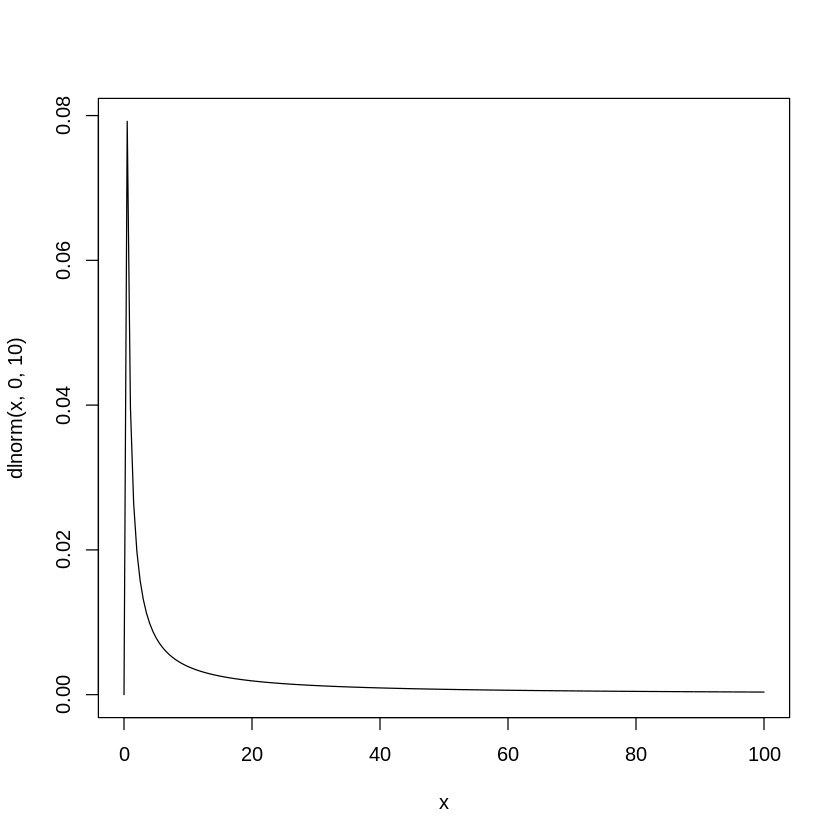

In [66]:
curve( dlnorm( x , 0 , 10 ) , from=0 , to=100 , n=200 )

In [67]:
a <- rnorm(1e6,0,10)
lambda <- exp(a)
mean( lambda )

[1] 1.522236e+17

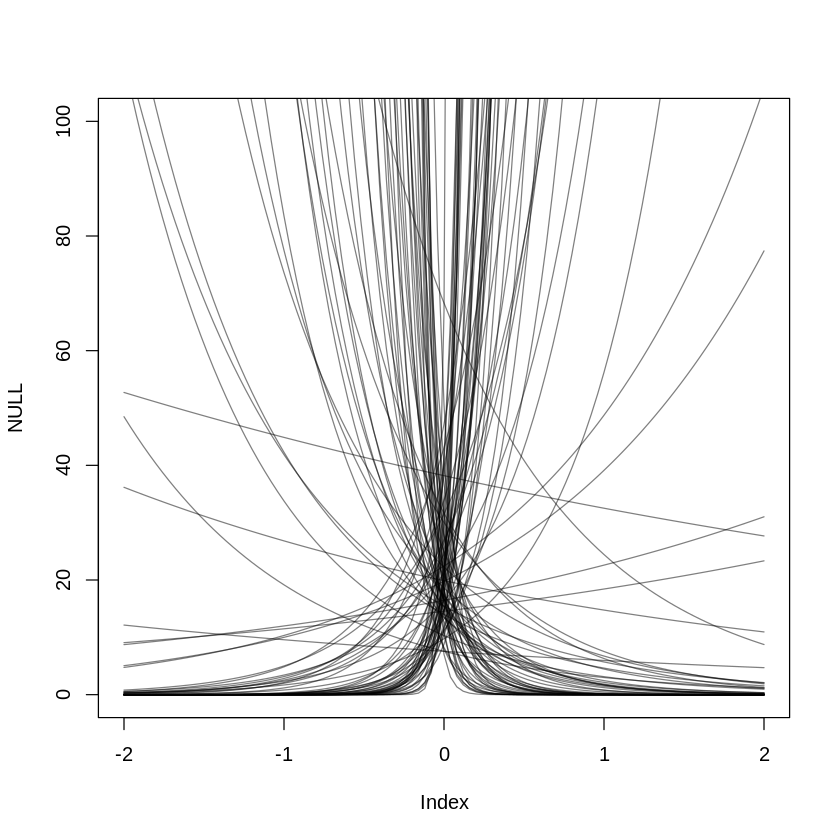

In [69]:
N <- 100
a <- rnorm( N , 3 , 0.5 )
b <- rnorm( N , 0 , 10 )
plot( NULL , xlim=c(-2,2) , ylim=c(0,100) )
for ( i in 1:N ) curve( exp( a[i] + b[i]*x ) , add=TRUE , col=col.alpha("black",0.5) )

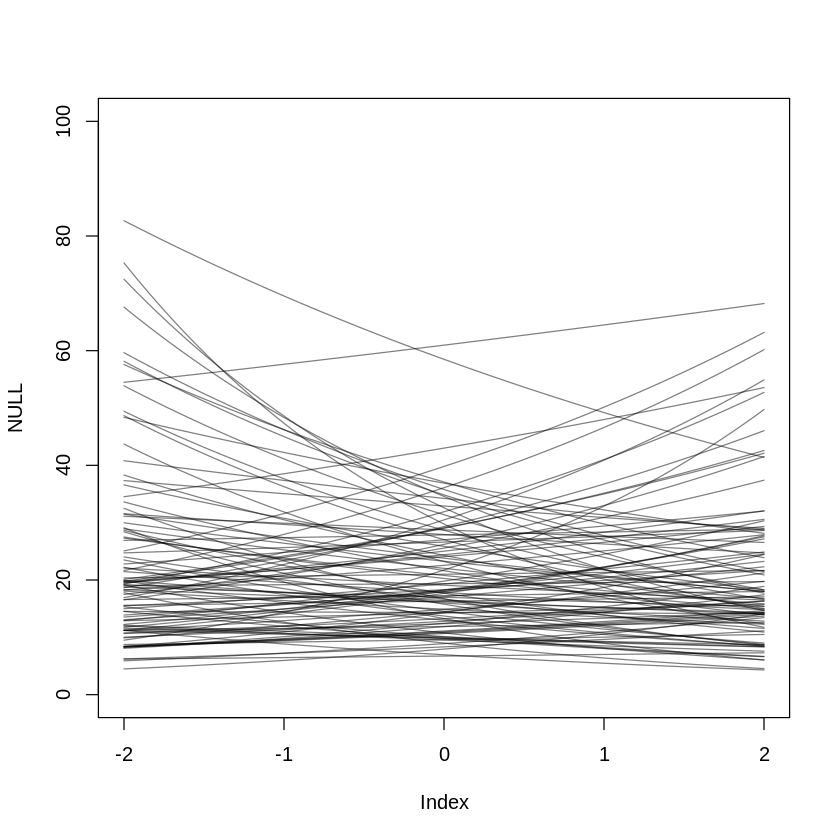

In [70]:
set.seed(10)

N <- 100
a <- rnorm( N , 3 , 0.5 )
b <- rnorm( N , 0 , 0.2 )
plot( NULL , xlim=c(-2,2) , ylim=c(0,100) )
for ( i in 1:N ) curve( exp( a[i] + b[i]*x ) , add=TRUE , col=col.alpha("black",0.5) )

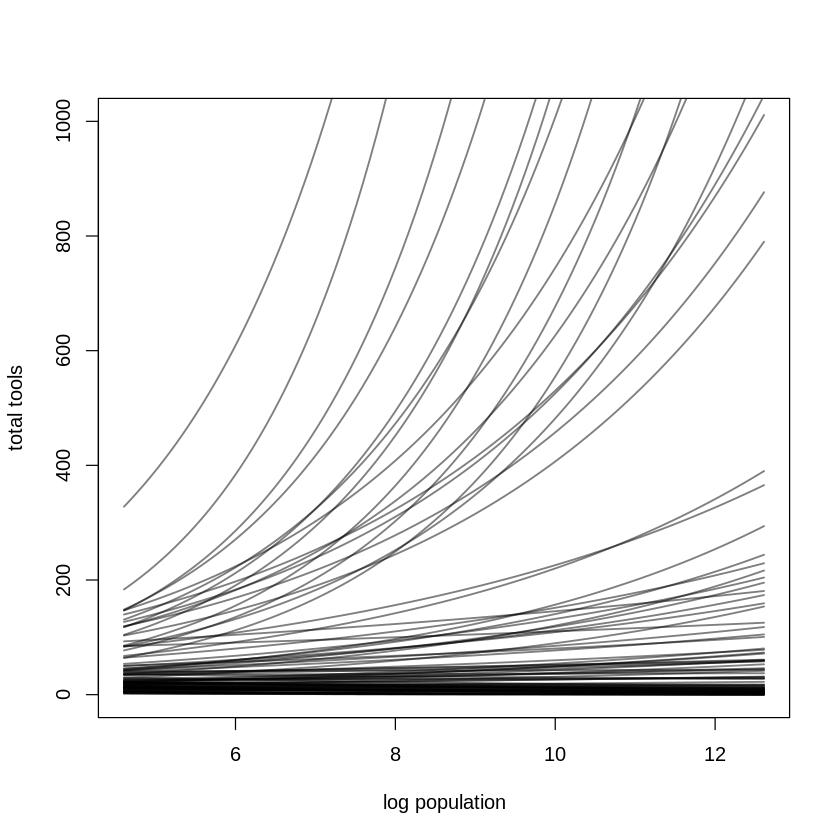

In [71]:
a <- rnorm( N , 3 , 0.5 )
b <- rnorm( N , 0 , 0.2 )

x_seq <- seq( from=log(100) , to=log(300000) , length.out=100 )
lambda <- sapply( x_seq , function(x) exp( a + b*x ) )

plot( NULL , xlim=range(x_seq) , ylim=c(0,1000) , xlab="log population" , ylab="total tools")
for ( i in 1:N ) lines( x_seq , lambda[i,] , col=col.alpha("black",0.5) , lwd=1.5 )

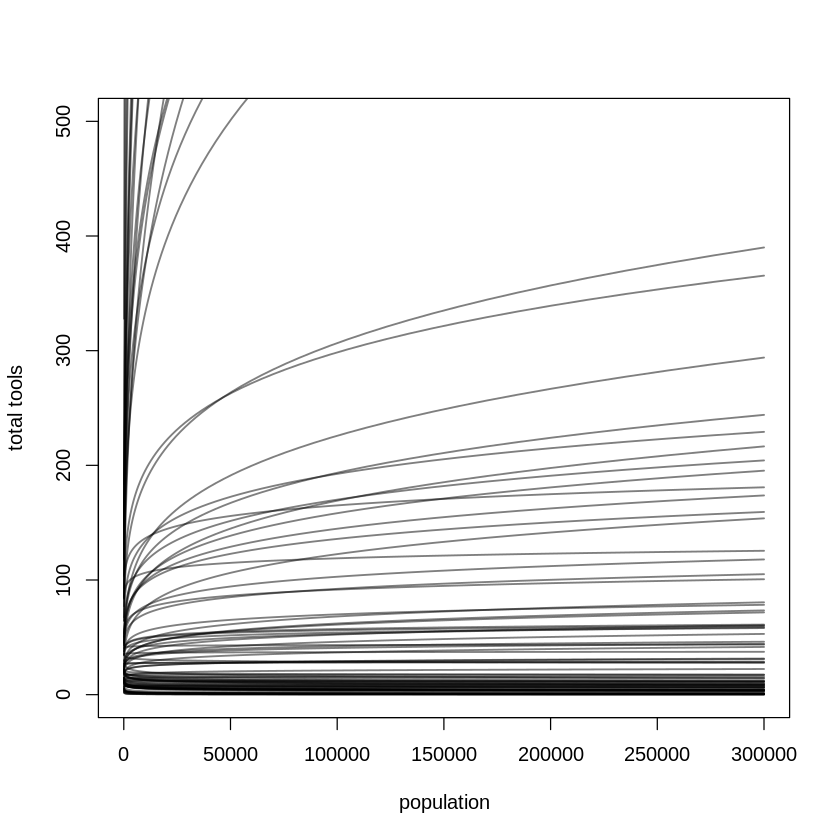

In [72]:
plot( NULL , xlim=range(exp(x_seq)) , ylim=c(0,500) , xlab="population" , ylab="total tools")
for ( i in 1:N ) lines( exp(x_seq) , lambda[i,] , col=col.alpha("black",0.5) , lwd=1.5 )

In [73]:
dat <- list(
T = d$total_tools ,
P = d$P ,     #log population
cid = as.integer(d$contact_id ))

In [74]:
# intercept only
m11.9 <- ulam(
                alist(
                T ~ dpois( lambda ),
                log(lambda) <- a,
                a ~ dnorm(3,0.5)
            ), data=dat , chains=4 , cores=4, log_lik=TRUE )

In [75]:
precis(m11.9)

mean     sd         5.5%     94.5%    n_eff    Rhat    
a 3.541898 0.05460725 3.453394 3.633189 409.5898 1.006541

In [76]:
# interaction model
m11.10 <- ulam(
            alist(
                T ~ dpois( lambda ),
                log(lambda) <- a[cid] + b[cid]*P,           #P is log population
                a[cid] ~ dnorm( 3 , 0.5 ),
                b[cid] ~ dnorm( 0 , 0.2 )
            ), data=dat , chains=4 , cores=4, log_lik=TRUE )

In [77]:
precis(m11.10, depth=2)

mean      sd         5.5%        94.5%     n_eff    Rhat     
a[1] 3.3185794 0.08586636  3.18178049 3.4548104 1884.550 0.9984944
a[2] 3.6070171 0.07148728  3.49047921 3.7190606 2049.121 0.9991673
b[1] 0.3770120 0.05053866  0.29474290 0.4584331 1996.048 0.9986337
b[2] 0.1926301 0.15674207 -0.06257918 0.4438618 2021.881 0.9995820

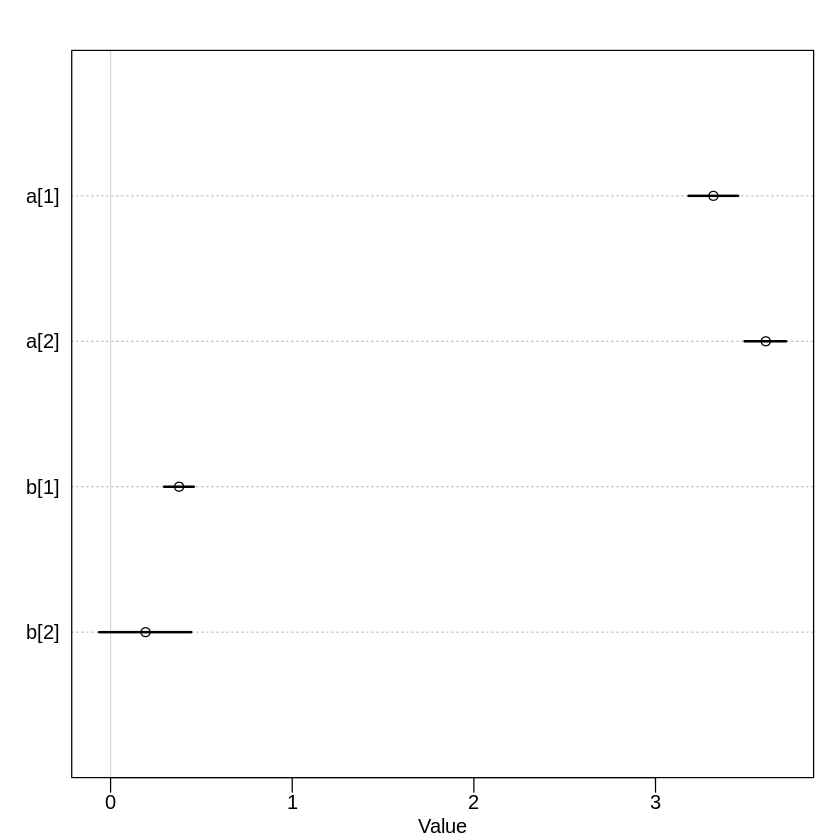

In [78]:
plot(precis(m11.10, depth=2))

In [79]:
compare( m11.9 , m11.10 , func=LOO )

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO       pLOO     dLOO     weight       SE       dSE     
m11.10  83.93456 6.279441  0.00000 1.000000e+00 13.02807       NA
m11.9  141.86744 8.531028 57.93288 2.630484e-13 33.84042 33.82365

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

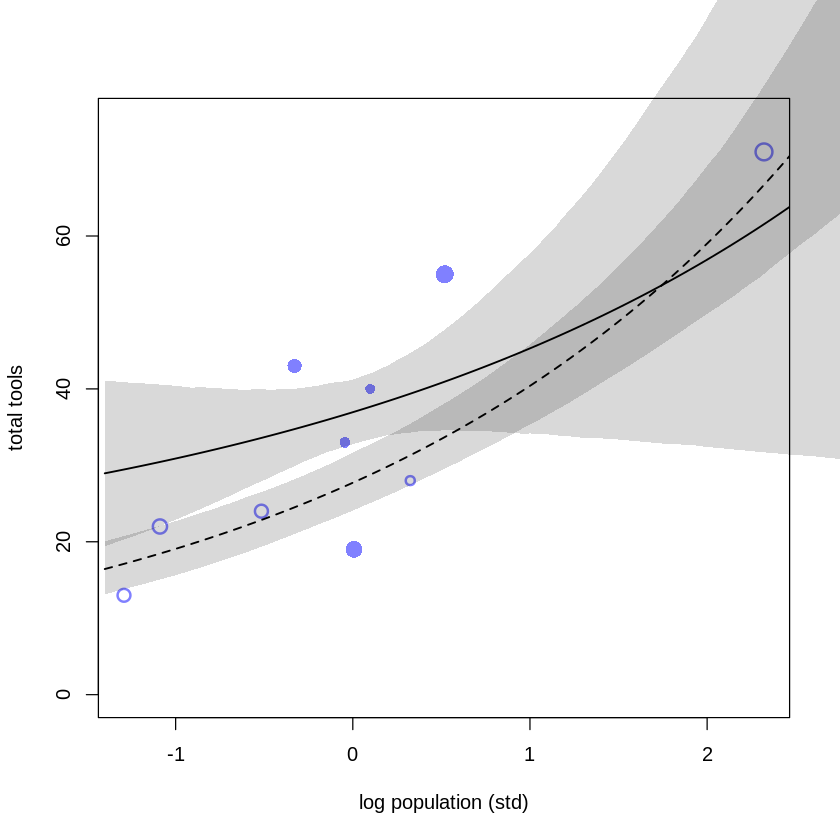

In [80]:
k <- LOOPk(m11.10)
plot( dat$P , dat$T , xlab="log population (std)" , ylab="total tools" ,
col=rangi2 , pch=ifelse( dat$cid==1 , 1 , 16 ) , lwd=2 ,
ylim=c(0,75) , cex=1+normalize(k) )
# set up the horizontal axis values to compute predictions at
ns <- 100
P_seq <- seq( from=-1.4 , to=3 , length.out=ns )

# predictions for cid=1 (low contact)
lambda <- link( m11.10 , data=data.frame( P=P_seq , cid=1 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines(P_seq , lmu , lty=2 , lwd=1.5 )
shade(lci , P_seq , xpd=TRUE )

# predictions for cid=2 (high contact)
lambda <- link( m11.10 , data=data.frame( P=P_seq , cid=2 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( P_seq , lmu , lty=1 , lwd=1.5 )
shade( lci , P_seq , xpd=TRUE )

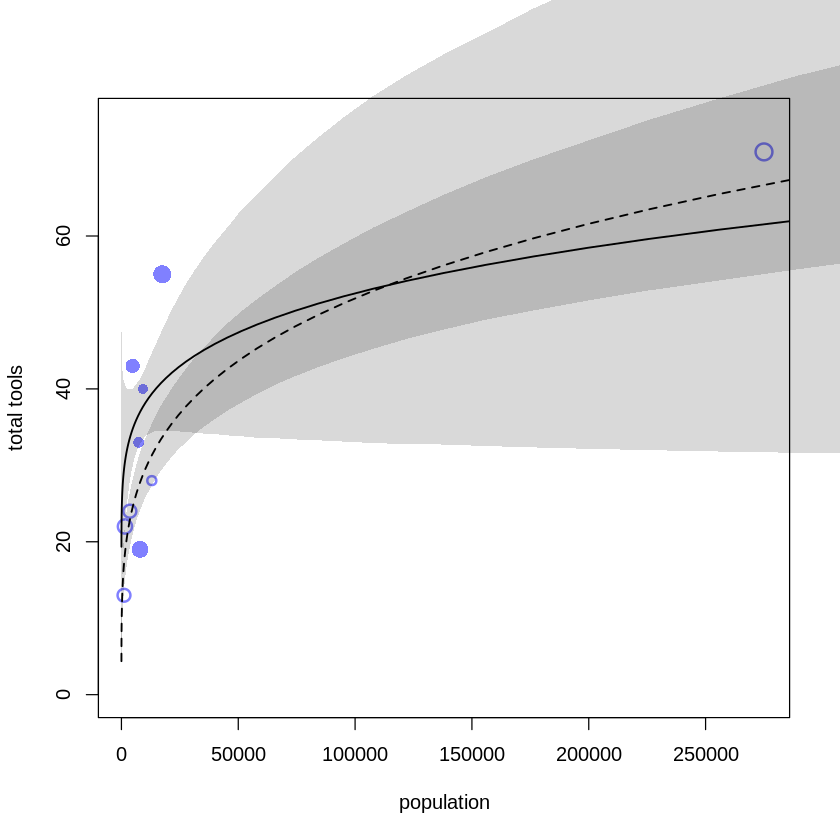

In [81]:
plot( d$population , d$total_tools , xlab="population" , ylab="total tools" ,
col=rangi2 , pch=ifelse( dat$cid==1 , 1 , 16 ) , lwd=2 ,
     ylim=c(0,75) , cex=1+normalize(k) )

ns <- 100
P_seq <- seq( from=-5 , to=3 , length.out=ns )
# 1.53 is sd of log(population)
# 9 is mean of log(population)
pop_seq <- exp( P_seq*sd(log(d$population)) + mean(log(d$population)) )


lambda <- link( m11.10, data=data.frame( P=P_seq , cid=1 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( pop_seq , lmu , lty=2 , lwd=1.5 )
shade( lci , pop_seq , xpd=TRUE )


lambda <- link( m11.10, data=data.frame( P=P_seq , cid=2 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( pop_seq , lmu , lty=1 , lwd=1.5 )
shade( lci , pop_seq , xpd=TRUE )

In [82]:
dat2 <- list( T=d$total_tools, P=d$population, cid=as.integer(d$contact_id ) )

m11.11 <- ulam(
            alist(
                T ~ dpois( lambda ),
                lambda <- exp(a[cid])*P^b[cid]/g,
                a[cid] ~ dnorm(1,1),
                b[cid] ~ dexp(1),
                g ~ dexp(1)
            ), data=dat2 , chains=4 , cores=4, log_lik=TRUE )

In [83]:
precis(m11.11, depth=2)

mean      sd        5.5%       94.5%     n_eff     Rhat    
a[1] 0.9122635 0.6928526 -0.2415538 1.9460013  783.2819 1.005095
a[2] 0.9079731 0.8664092 -0.4782253 2.3063478  823.0922 1.000821
b[1] 0.2603681 0.0344425  0.2065469 0.3130241 1182.5783 1.002825
b[2] 0.2932654 0.1079017  0.1146001 0.4648875  627.0995 1.002883
g    1.1698978 0.7772315  0.2975053 2.6111369  883.4179 1.003904

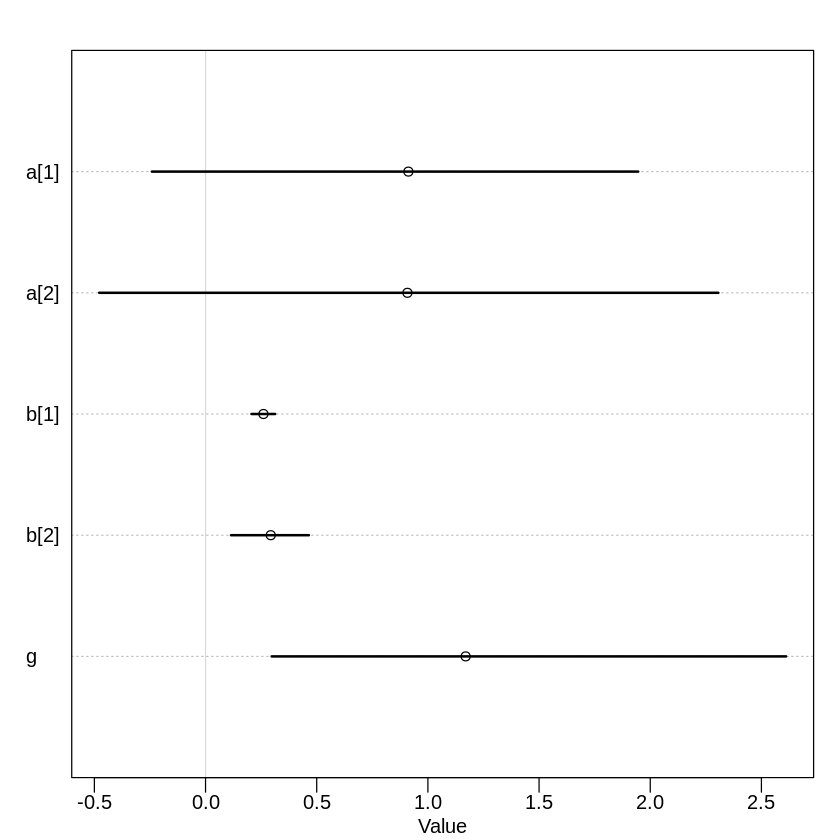

In [84]:
plot(precis(m11.11, depth=2))

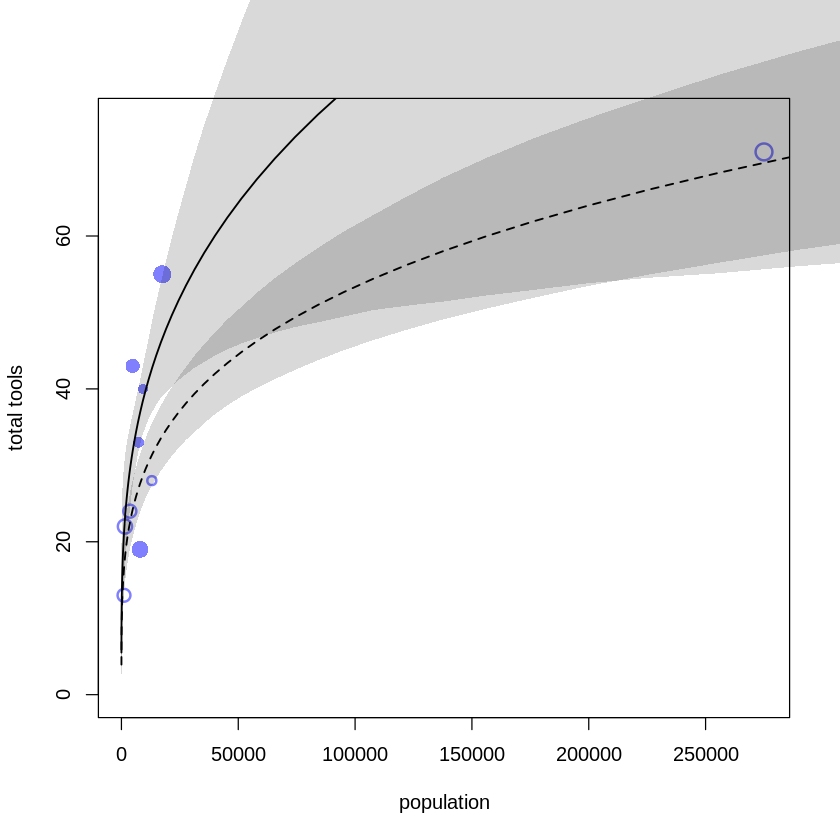

In [85]:
plot( d$population , d$total_tools , xlab="population" , ylab="total tools" ,
col=rangi2 , pch=ifelse( dat$cid==1 , 1 , 16 ) , lwd=2 ,
     ylim=c(0,75) , cex=1+normalize(k) )

ns <- 100
P_seq <- seq( from=-5 , to=3 , length.out=ns )
# 1.53 is sd of log(population)
# 9 is mean of log(population)
pop_seq <- exp( P_seq*sd(log(d$population)) + mean(log(d$population)) )


lambda <- link( m11.11, data=data.frame( P=pop_seq , cid=1 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( pop_seq , lmu , lty=2 , lwd=1.5 )
shade( lci , pop_seq , xpd=TRUE )


lambda <- link( m11.11, data=data.frame( P=pop_seq , cid=2 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( pop_seq , lmu , lty=1 , lwd=1.5 )
shade( lci , pop_seq , xpd=TRUE )

In [86]:
num_days <- 30
y <- rpois( num_days , 1.5 )

In [87]:
num_weeks <- 4
y_new <- rpois( num_weeks , 0.5*7 )

In [88]:
y_all <- c( y , y_new )
exposure <- c( rep(1,30) , rep(7,4) )
monastery <- c( rep(0,30) , rep(1,4) )
d <- data.frame( y=y_all , days=exposure , monastery=monastery )

In [89]:
# compute the offset
d$log_days <- log( d$days )

# fit the model
m11.12 <- quap(
            alist(
                y ~ dpois( lambda ),
                log(lambda) <- log_days + a + b*monastery,
                a ~ dnorm( 0 , 1 ),
                b ~ dnorm( 0 , 1 )
            ), data=d )

In [90]:
precis(m11.12)

mean       sd        5.5%        94.5%     
a  0.2128028 0.1600037 -0.04291409  0.4685196
b -0.6729710 0.2765608 -1.11496860 -0.2309734

In [91]:
# compute the offset
d$m <- monastery + 1

# fit the model
m11.12b <- quap(
            alist(
                    y ~ dpois( lambda ),
                    log(lambda) <- log_days + a[m],
                    a[m] ~ dnorm( 0 , 1 )
              ), data=d 
          )

precis(m11.12b, depth=2)

mean       sd        5.5%       94.5%      
a[1]  0.2303013 0.1606037 -0.0263744  0.48697702
a[2] -0.4716222 0.2326733 -0.8434790 -0.09976532

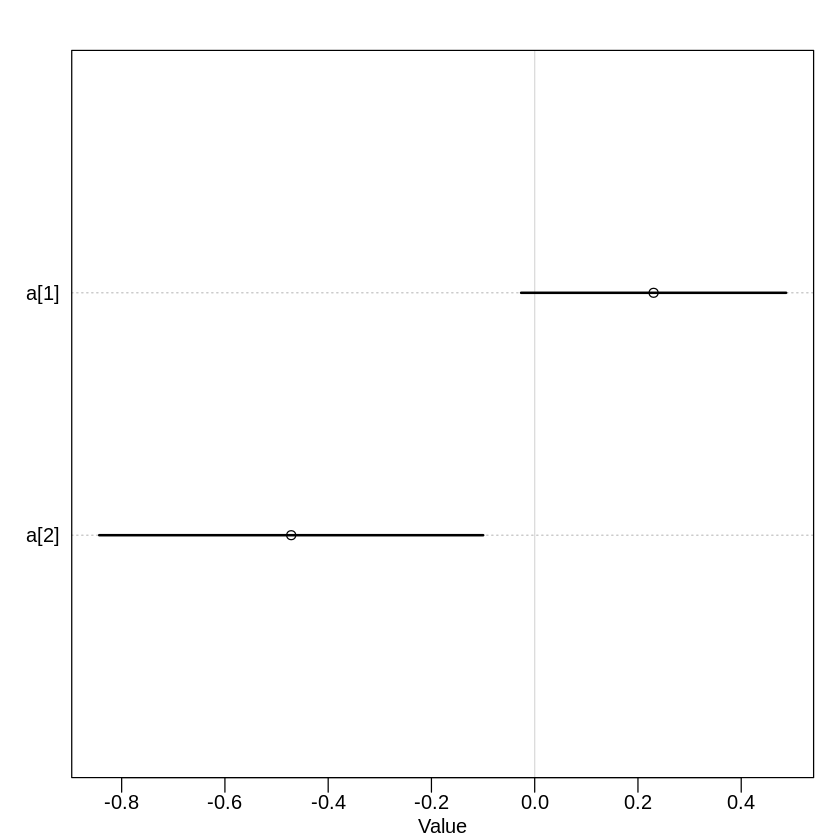

In [92]:
plot(precis(m11.12b, depth=2))

In [93]:
post <- extract.samples( m11.12 )
lambda_old <- exp( post$a )
lambda_new <- exp( post$a + post$b )
precis( data.frame( lambda_old , lambda_new ) )

mean     sd        5.5%      94.5%     histogram     
lambda_old 1.257029 0.2018453 0.9640908 1.5996658 ▁▂▇▇▃▁▁▁▁     
lambda_new 0.646423 0.1514290 0.4355215 0.9098231 ▁▁▃▇▇▅▂▁▁▁▁▁▁▁

In [94]:
post <- extract.samples( m11.12b )
lambda_old <- exp( post$a[,1] )
lambda_new <- exp( post$a[,2] )
precis( data.frame( lambda_old , lambda_new ) )

mean      sd        5.5%      94.5%    histogram
lambda_old 1.2763362 0.2085868 0.9744806 1.636041 ▁▂▇▇▃▁▁▁▁
lambda_new 0.6394757 0.1511817 0.4295485 0.902206 ▁▇▇▂▁▁▁▁

In [95]:
library(rethinking)
data(UCBadmit)
d <- UCBadmit
head(d)

dept applicant.gender admit reject applications
1 A    male             512   313    825         
2 A    female            89    19    108         
3 B    male             353   207    560         
4 B    female            17     8     25         
5 C    male             120   205    325         
6 C    female           202   391    593

In [96]:
dat_slim=data.frame(admit=d$admit, rej=d$reject, applications=d$applications)

In [97]:
dat_slim

admit rej applications
1  512   313 825         
2   89    19 108         
3  353   207 560         
4   17     8  25         
5  120   205 325         
6  202   391 593         
7  138   279 417         
8  131   244 375         
9   53   138 191         
10  94   299 393         
11  22   351 373         
12  24   317 341

In [98]:
# binomial model of overall admission probability
m_binom <- quap(
            alist(
                admit ~ dbinom(applications,p),
                logit(p) <- a,
                a ~ dnorm(0,100)
                ),
            data=d )

In [99]:
# # Poisson model of overall admission rate and rejection rate
# d$rej <- d$reject # 'reject' is a reserved word

m_poisUlam <- ulam(
            alist(
                admit ~ dpois(lambda1),
                rej ~ dpois(lambda2),
                log(lambda1) <- a1,
                log(lambda2) <- a2,
                c(a1,a2) ~ dnorm(0,100)
            ),
            data=dat_slim , chains=4 , cores=4 )

In [100]:
precis(m_binom)

mean       sd         5.5%       94.5%     
a -0.4567393 0.03050707 -0.5054955 -0.4079832

In [101]:
precis(m_poisUlam)

mean     sd         5.5%     94.5%    n_eff    Rhat    
a2 5.441488 0.01956336 5.409867 5.472803 1375.521 1.001338
a1 4.985365 0.02473220 4.945835 5.025648 1349.459 1.000872

In [102]:
logistic(coef(m_binom))      #Perhaps this is the old function from 1st edition of book???

a 
0.3877596

In [103]:
inv_logit(coef(m_binom))

a 
0.3877596

In [104]:
#k <- as.numeric(coef(m_poisUlam)) # This is a dangerous way of doing this, as it depends on the order in which the coeffs are produced.  The ulam() order is different to map2stan(), so we end up with the wrong value.
# exp(k[1])/(exp(k[1])+exp(k[2]))
postUlam <- extract.samples(m_poisUlam)
a1 <- mean(postUlam$a1)
a2 <- mean(postUlam$a2)
exp(a1)/(exp(a1)+exp(a2))

[1] 0.3879061

In [105]:
# Poisson model of overall admission rate and rejection rate
d$rej <- d$reject # 'reject' is a reserved word

m_poisStan <- map2stan(
            alist(
                admit ~ dpois(lambda1),
                rej ~ dpois(lambda2),
                log(lambda1) <- a1,
                log(lambda2) <- a2,
                c(a1,a2) ~ dnorm(0,100)
            ),
            data=dat_slim , chains=4 , cores=4 )

Computing WAIC


In [106]:
precis(m_poisStan)

mean     sd         5.5%     94.5%    n_eff    Rhat     
a1 4.985251 0.02407310 4.947190 5.022882 2609.062 0.9999138
a2 5.442220 0.01952858 5.410632 5.472979 2442.897 1.0008605

In [107]:
# k <- as.numeric(coef(m_poisStan))    # This is a dangerous way of doing this, as it depends on the order in which the coeffs are produced.  The ulam() order is different to map2stan(), so we end up with the wrong value.
# exp(k[1])/(exp(k[1])+exp(k[2]))
postStan <- extract.samples(m_poisStan)
a1 <- mean(postStan$a1)
a2 <- mean(postStan$a2)
exp(a1)/(exp(a1)+exp(a2))

[1] 0.3877052

In [108]:
N <- 5
x <- replicate( 1e5 , min(runif(N,1,100)) )

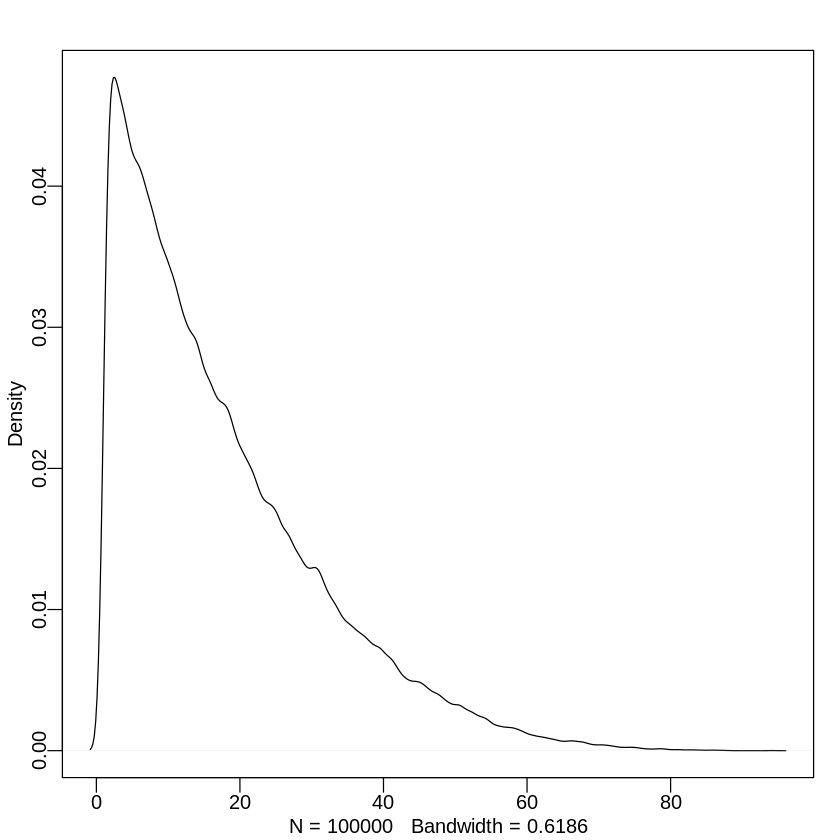

In [109]:
dens(x)

In [110]:
N <- 5
M <- 1
x <- replicate( 1e5 , sort(runif(N,1,100))[M] )

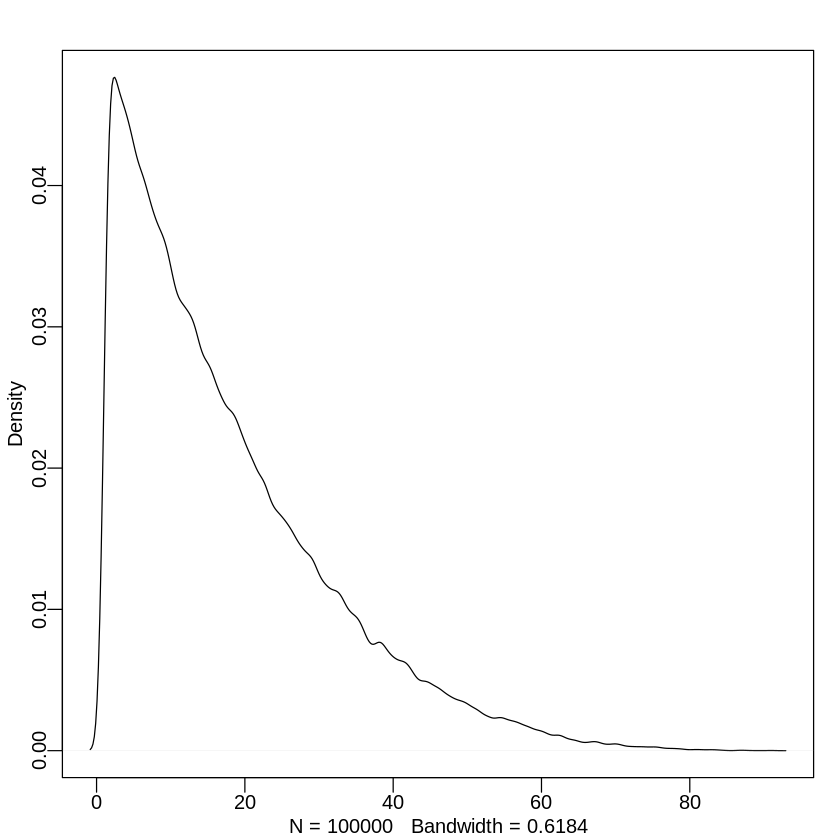

In [111]:
dens(x)

In [112]:
library(rethinking)
data(AustinCats)
d <- AustinCats

d$adopt <- ifelse( d$out_event=="Adoption" , 1L , 0L )

dat <- list(
                days_to_event = as.integer( d$days_to_event ),
                color_id = ifelse( d$color=="Black" , 1L , 2L ) ,
                adopted = d$adopt
            )

m11.14 <- ulam(
                alist(
                    days_to_event|adopted==1 ~ exponential( lambda ),
                    days_to_event|adopted==0 ~ custom(exponential_lccdf( !Y | lambda )),
                    lambda <- 1.0/mu,
                    log(mu) <- a[color_id],
                    a[color_id] ~ normal(0,1)
                ), data=dat , chains=4 , cores=4 )

precis( m11.14 , 2 )

mean     sd         5.5%     94.5%   n_eff    Rhat    
a[1] 4.050407 0.02669567 4.007751 4.09317 1277.242 1.002340
a[2] 3.880170 0.01029221 3.864176 3.89716 1315.689 1.000199

In [113]:
post <- extract.samples(m11.14 )
post$D <- exp(post$a)
precis( post , 2 )

mean      sd         5.5%      94.5%    histogram     
a[1]  4.050407 0.02669567  4.007751  4.09317 ▁▁▂▅▇▅▂▁▁▁    
a[2]  3.880170 0.01029221  3.864176  3.89716 ▁▁▁▂▃▅▇▇▅▃▂▁▁▁
D[1] 57.441299 1.53654542 55.023008 59.92956 ▁▁▃▇▇▅▂▁▁▁▁   
D[2] 48.435027 0.49867447 47.663958 49.26236 ▁▁▃▇▇▂▁▁

In [114]:
stancode(m11.14)

data{
    int adopted[22356];
    int days_to_event[22356];
    int color_id[22356];
}
parameters{
    vector[2] a;
}
model{
    vector[22356] lambda;
    vector[22356] mu;
    a ~ normal( 0 , 1 );
    for ( i in 1:22356 ) {
        mu[i] = a[color_id[i]];
        mu[i] = exp(mu[i]);
    }
    for ( i in 1:22356 ) {
        lambda[i] = 1/mu[i];
    }
    for ( i in 1:22356 ) 
        if ( adopted[i] == 0 ) target += exponential_lccdf(days_to_event[i] | lambda[i]);
    for ( i in 1:22356 ) 
        if ( adopted[i] == 1 ) days_to_event[i] ~ exponential( lambda[i] );
}



Practice

10E1

In [115]:
p <- 0.35
log(p/(1-p))

[1] -0.6190392

In [116]:
logit(p)

[1] -0.6190392

10E2

In [117]:
log_odds <- 3.2
inv_logit(log_odds)

[1] 0.9608343

In [118]:
exp(log_odds)/(exp(log_odds) + 1)

[1] 0.9608343

10E3

Proportional change of odds is 1.7 times the predictor.  I.e.

log(odds) = 1.7 * x
d(odds)/ odds = 1.7 * dx
d(odds)/dx = 1.7 * odds

The rate of change of odds with respect to the predictor x is 1.7 times the value of the odds.

10E4

Poisson regressions sometimes require the use of an offset to handle different exposure lengths, i.e. different lengths of time over which the random variates were sampled.  This is because you can consider the parameter lambda as a rate, not just an expected value of a poisson distributed random variable.  

In a model with Y ~ Poisson ( lambda_i),

log(lambda_i) = log(mu_i / tau_i) = a + b * x

then

log(mu_i) = log(tau_i) + a + b * x

Here tau_i is the offset, the data term we add that is analogous to a predictor.

The example in the book is that of comparing the number of manuscripts produced by monks at two monasteries, one of which records daily data, the other weekly data.

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9:


Poisson distribution models number of events per some unit of time/spatial region.
Measurement of the outcome variable can be provided on the different scale for each observation (daily vs weekly).
Offset is used to bring all observations on the same scale.
* Consider an example from the chapter, where a number of manuscripts produced by the monastery is measured on the daily or weekly basis. The offset parameter is used to convert all measurements to the daily basis.  
* Number of animals in the area is another possible example where offset is helpful. Square of the area can be treated as an offset in this case.
* While predicting number of conversions per ad campaign, number of impressions can be treated as an offset. I think it is a Poisson regression and not Binomial, because conversion rate is extremely small usually and number of impressions is huge (1 vs 1e+6)


10M1

Disaggregated binomial data (really, using a Bernoulli distribution), ignores the multiplicities of the aggregate data.  For example, in the globe tossing experiment, if the data was disaggregate, each line in the data would have an outcome of either 1 or 0 (let's assume).  The regression fits the parameter(s) of the model to this specific sequence of outcomes.  At the aggregate level, we use the Binomial distribution to model data where each line contains the aggregate outcome (m) of several (n) trials, so the outcome m can be 0, 1, ... n.  The binomial distribution contains the multiplicity term of the binomial coefficient (n choose m), i.e. (n! / (m! * (n-m)!).  This considers all the many different permutations in which we get the aggregate outcome m, and so the likelihood has been increased by a factor corresponding to the binomial coefficient (which >= 1, and often is a very large number).

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9:

Binomial likelihood in the aggregated form contains C(n,m) multiplier. This multiplier is converted to an additional constant at the log-scale of the likelihood. For non-aggregated format, each event is modeled independently as a number of heads in the single drop of the coin.

likelihood in the aggregated format: C(n,m)*p^m*(1-p)^n-m

likelihood in the non-aggregated format: p^m*(1-p)^n-m

10M2

y_i ~ Poisson(l_i)

log(l_i) = b * x

Thus

l_i = exp(b * x)

d(l_i) = b * exp(b * x) dx = b * l_i * dx

or 

d(l_i) / l_i = b * dx

or 

d(l_i) = l_i * b * dx

Thus, a coefficient of b=1.7 on x means that the <b>proportional</b> change of l_i (the expected value or rate of a Poisson random variate) increases by 1.7 per unit increase in the predictor x.  Alternatively, a unit increase of x leads to an increase in l_i by a factor of 1.7.

10M3

The logit link :

log(p / (1-p) ) = a + b * x

is appropriate for a binomial generalized linear model because it allows a linear model to be linked to a probability variable that must be bounded beteween 0 and 1.

10M4

Likewise for the explanation in 10M3 above, the log link model:

log lambda = a + b * x

is appropriate for a Poisson generalized linear model because it allows a linear model to be linked to a positive valued variable lambda that represents a average count or a rate.

10M5

Using a logit link function for a Poisson genealized linear model:
    
y ~ Poisson (l)

log (l / (l - i)) = a + b * x

or 

l = exp(a + b * x) / (1 + exp(a + b * x))

This would imply that the rate or average count per unit displacement (time or distance) is bounded between 0 and 1, or after scaling time, between 0 and an upper bound.  

In practice, it would refer to a process that has many 0 or 1 counts, but there is a possibility of a few low digit counts.  This could be counting the number of buses at your local bus stop in successive periods of time tau.   We simulate below:

In [119]:
y <- rpois(1e+7, .99)
prop.table(table(y))

y
        0         1         2         3         4         5         6         7 
0.3715942 0.3678636 0.1820151 0.0600824 0.0149012 0.0029739 0.0004929 0.0000682 
        8         9        10 
0.0000071 0.0000012 0.0000002 

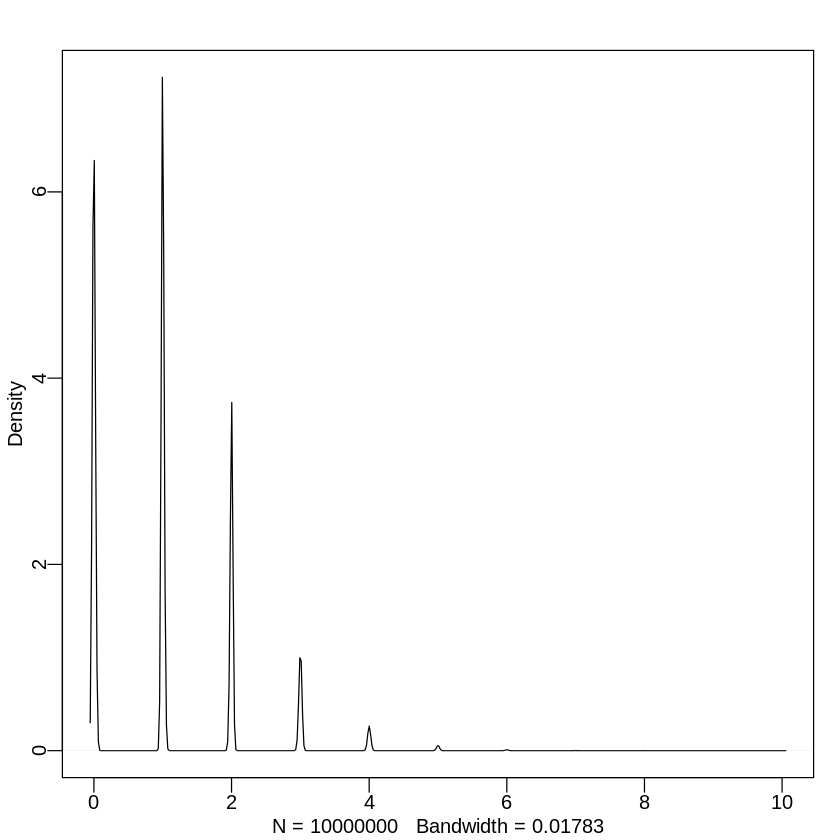

In [120]:
dens(y)

10M6

Binomial distribution is maximum entropy distribution when a discrete random variable is positive and:
1) only two (unordered) states / events possible
2) a mean (expected value) is defined.  In the binomial case, this mean = Np.


Poisson distribution is the maximum entropy distribution when discrete random variable is positive and:
1) a mean (expected value) is defined.  In the Poisson case, this mean = lambda = variance.

The Poisson distribution is a special case of the binomial distribution when the number of trials tend to +infinity (or a very large number) and the probability of successes p tends to 0 (or a very small number), such that the upper bound is never hit by the process.  As such, the same constraints as for the binomial distribution lead to it being a maximum entropy distribution.

10H1

In [121]:
library(rethinking)
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2*d$condition
head(d)

actor recipient condition block trial prosoc_left chose_prosoc pulled_left
1 1     NA        0         1      2    0           1            0          
2 1     NA        0         1      4    0           0            1          
3 1     NA        0         1      6    1           0            0          
4 1     NA        0         1      8    0           1            0          
5 1     NA        0         1     10    1           1            1          
6 1     NA        0         1     12    1           1            1          
  treatment
1 1        
2 1        
3 2        
4 1        
5 2        
6 2

In [122]:
# prior trimmed data list
dat_list <- list(
                pulled_left = d$pulled_left,
                actor = d$actor,
                treatment = as.integer(d$treatment) )

# particles in 11-dimensional space
m11.4 <- ulam(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a[actor] + b[treatment] ,
                a[actor] ~ dnorm( 0 , 1.5 ),
                b[treatment] ~ dnorm( 0 , 0.5 )
            ) ,
            data=dat_list , chains=4, cores=4, log_lik=TRUE )

precis( m11.4 , depth=2 )

mean        sd        5.5%        94.5%       n_eff     Rhat     
a[1] -0.48126981 0.3235592 -0.98446883  0.03666891  894.5075 1.0047517
a[2]  3.86157374 0.7453229  2.76590037  5.14245010 1279.0898 1.0002714
a[3] -0.75879681 0.3185687 -1.25229623 -0.24036765  889.2258 1.0044773
a[4] -0.76428344 0.3259193 -1.26498030 -0.24442814 1042.5745 1.0054435
a[5] -0.46828575 0.3187134 -0.97708383  0.04127027  983.7804 1.0014414
a[6]  0.45678718 0.3153290 -0.03600498  0.97256835  874.9941 1.0042302
a[7]  1.93939020 0.4122875  1.28790596  2.62051183 1243.2977 0.9993417
b[1] -0.02979956 0.2762245 -0.47952897  0.41698665  881.5549 1.0046904
b[2]  0.49458581 0.2715384  0.03617338  0.90803828  917.4917 1.0030388
b[3] -0.36442956 0.2771884 -0.79677624  0.07754848  889.7009 1.0027473
b[4]  0.38579481 0.2786720 -0.05979391  0.82323309  950.8883 1.0046067

In [123]:
m11.4b <- quap(
            alist(
                pulled_left ~ dbinom( 1 , p ) ,
                logit(p) <- a[actor] + b[treatment] ,
                a[actor] ~ dnorm( 0 , 1.5 ),
                b[treatment] ~ dnorm( 0 , 0.5 )
                ) ,
            data=dat_list)

precis( m11.4b , depth=2 )

mean        sd        5.5%        94.5%      
a[1] -0.43920160 0.3276017 -0.96277244  0.08436924
a[2]  3.70608132 0.7217545  2.55257818  4.85958446
a[3] -0.73275971 0.3329759 -1.26491952 -0.20059991
a[4] -0.73276718 0.3329761 -1.26492728 -0.20060709
a[5] -0.43922311 0.3276020 -0.96279438  0.08434817
a[6]  0.46892910 0.3317743 -0.06131031  0.99916851
a[7]  1.90508273 0.4136457  1.24399699  2.56616846
b[1] -0.04066397 0.2837321 -0.49412259  0.41279465
b[2]  0.47214424 0.2842163  0.01791165  0.92637683
b[3] -0.37836133 0.2852444 -0.83423691  0.07751425
b[4]  0.36201716 0.2838329 -0.09160258  0.81563691

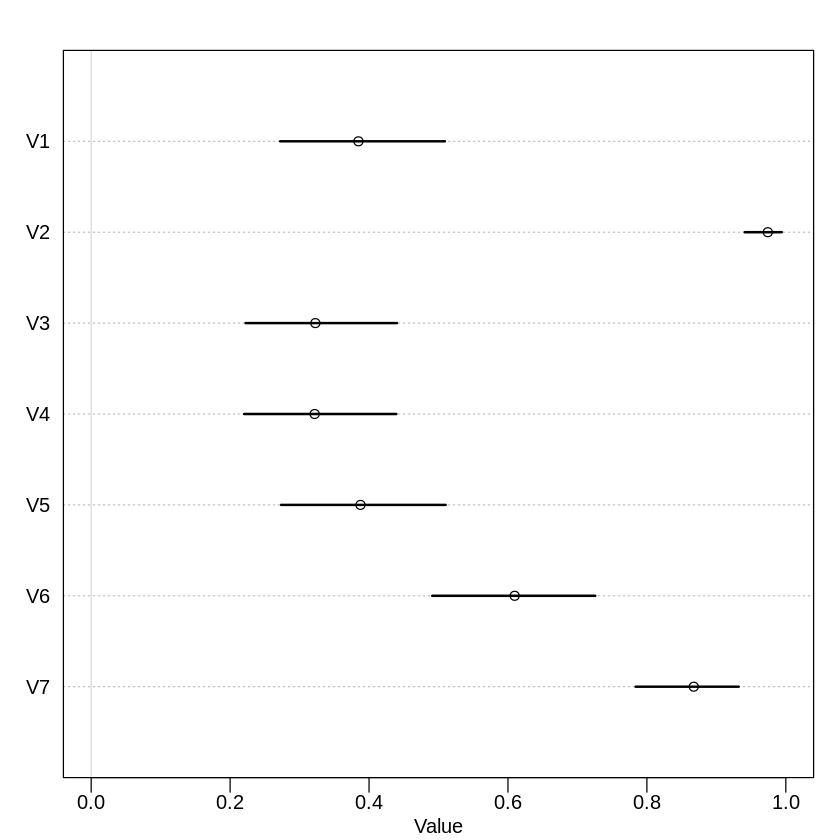

In [124]:
post <- extract.samples(m11.4)
p_left <- inv_logit( post$a )
plot( precis( as.data.frame(p_left) ) , xlim=c(0,1) )

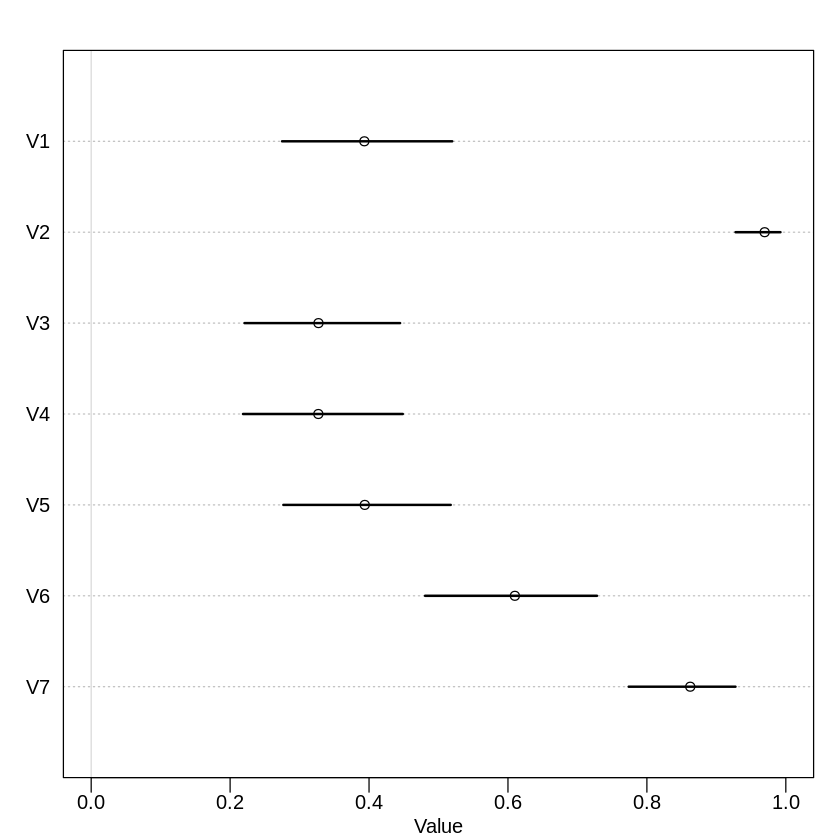

In [125]:
post_B <- extract.samples(m11.4b)
p_left_B <- inv_logit( post_B$a )
plot( precis( as.data.frame(p_left_B) ) , xlim=c(0,1) )

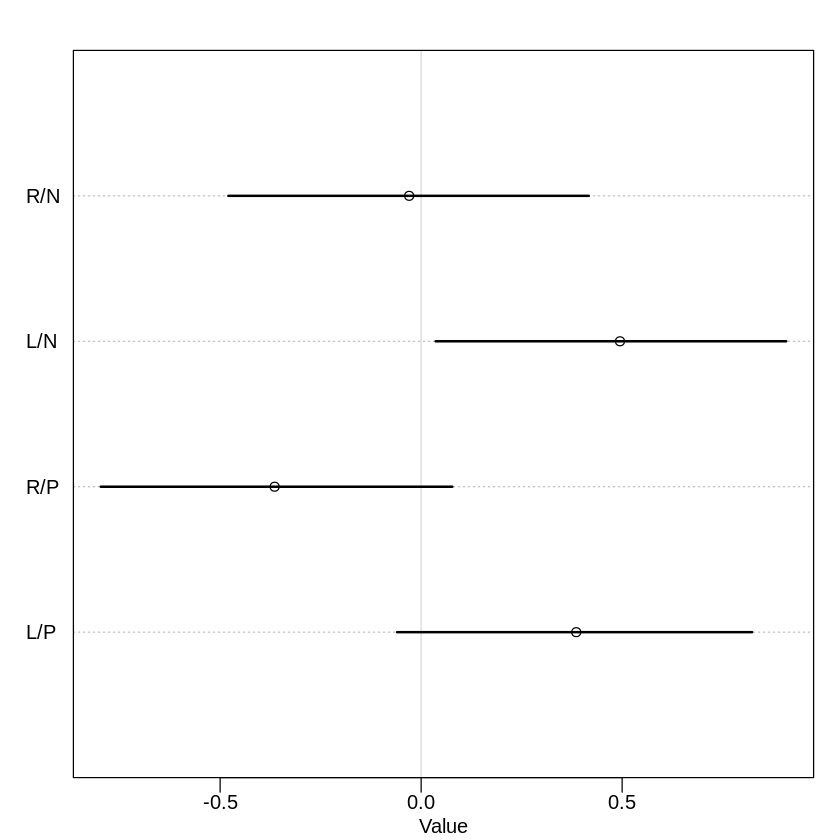

In [126]:
labs <- c("R/N","L/N","R/P","L/P")
plot( precis( m11.4 , depth=2 , pars="b" ) , labels=labs )

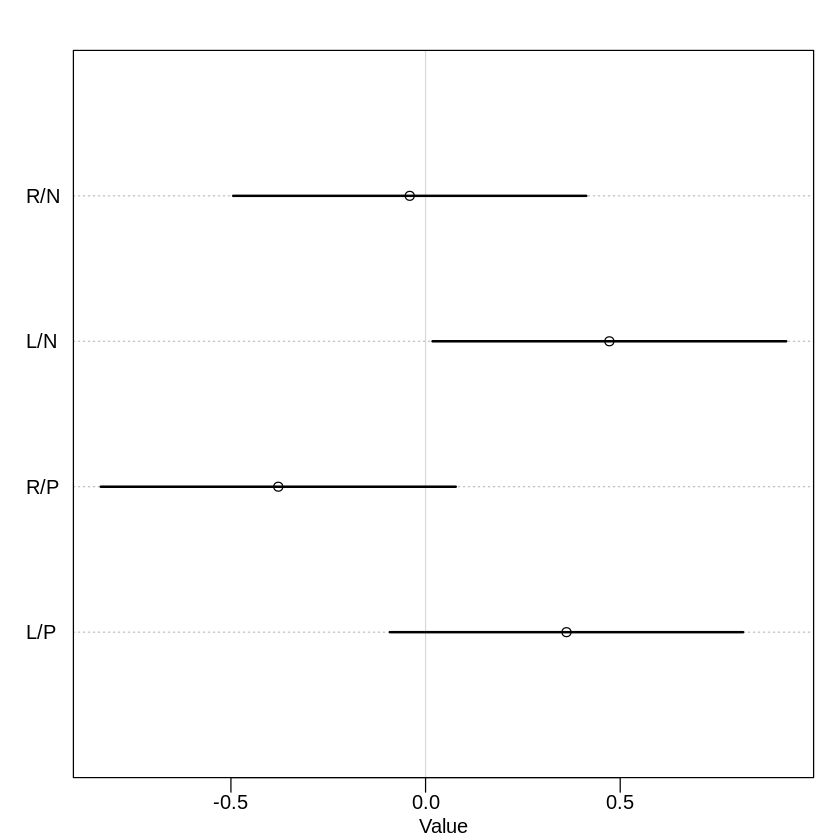

In [127]:
labs <- c("R/N","L/N","R/P","L/P")
plot( precis( m11.4b , depth=2 , pars="b" ) , labels=labs )

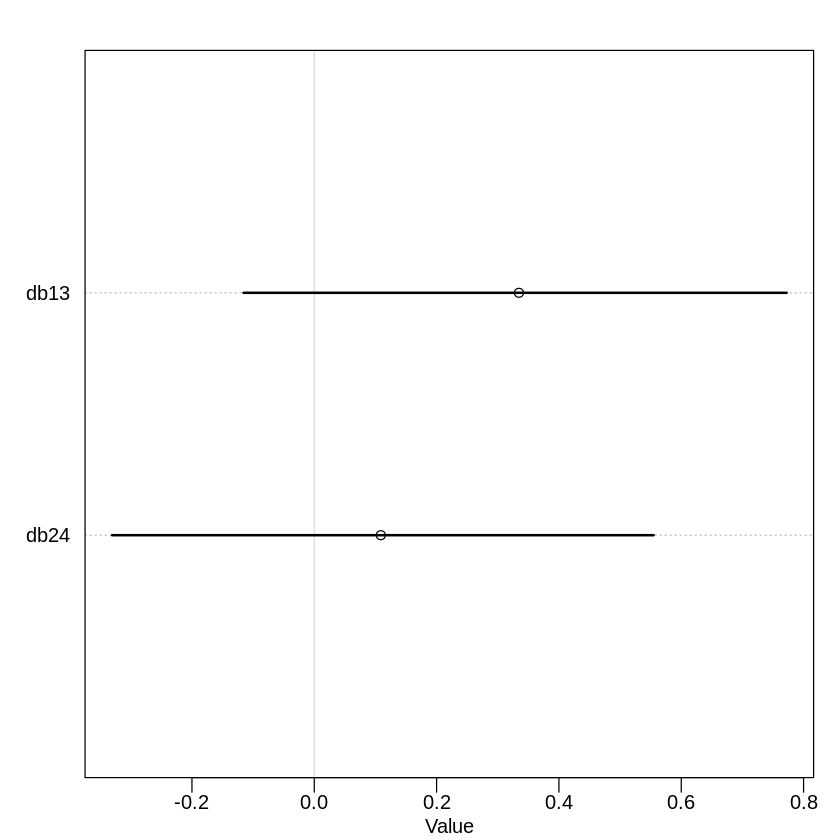

In [128]:
diffs <- list(
db13 = post$b[,1] - post$b[,3],
db24 = post$b[,2] - post$b[,4] )
plot( precis(diffs) )

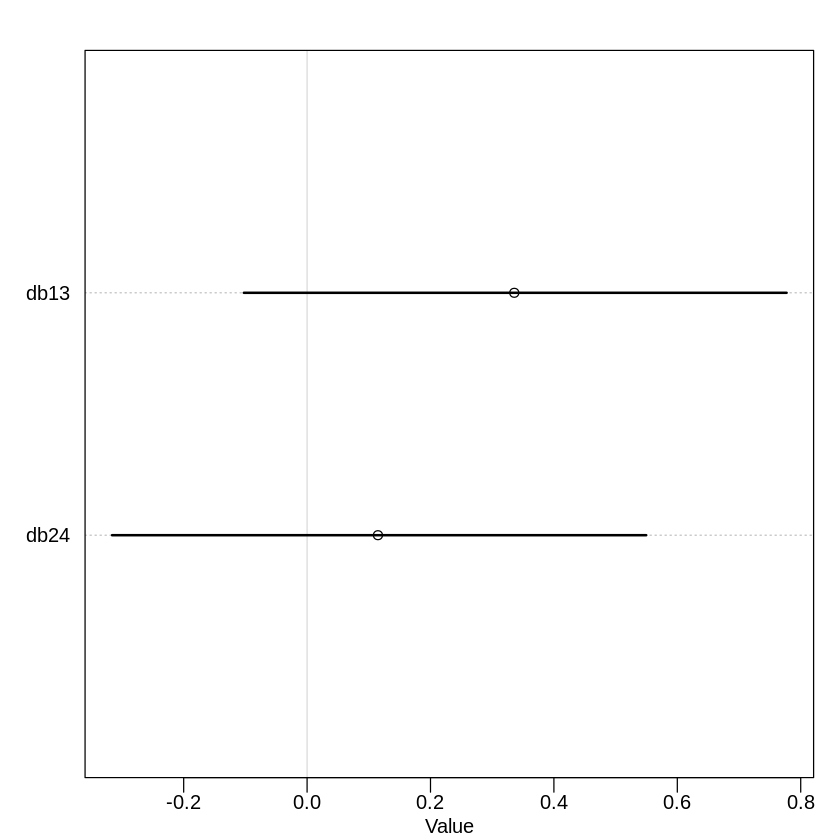

In [129]:
diffs_B <- list(
db13 = post_B$b[,1] - post_B$b[,3],
db24 = post_B$b[,2] - post_B$b[,4] )
plot( precis(diffs_B) )

In [130]:
dat <- list( actor=rep(1:7,each=4) , treatment=rep(1:4,times=7) )
p_post <- link_ulam( m11.4 , data=dat )
p_mu <- apply( p_post , 2 , mean )
p_ci <- apply( p_post , 2 , PI )

In [131]:
p_post_B <- link( m11.4b , data=d )
p_mu_B <- apply( p_post_B , 2 , mean )
p_ci_B <- apply( p_post_B , 2 , PI )

In [132]:
compare( m11.4 , m11.4b , func=LOO )

Warning message in compare(m11.4, m11.4b, func = LOO):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”

LOO      pLOO     dLOO      weight    SE       dSE      
m11.4  532.1128 8.397247 0.0000000 0.5868109 18.92678        NA
m11.4b 532.8144 8.408264 0.7015943 0.4131891 18.65092 0.3731555

Both ulam (m11.4) and quap (m11.4b) models have similar LOO values.  The difference of their squared errors (dSE) is small enough though to resolve that the ulam m11.4 is the best predictive model.

From the analysis here (as explored in Chapter 11), there is very little difference between ulam and quap models.  There are very small differences in the estimates, but nothing apparently significant.  Except possibly for actor 2, whose intercept a[2] is extremely large (this was the actor who always pulled left).

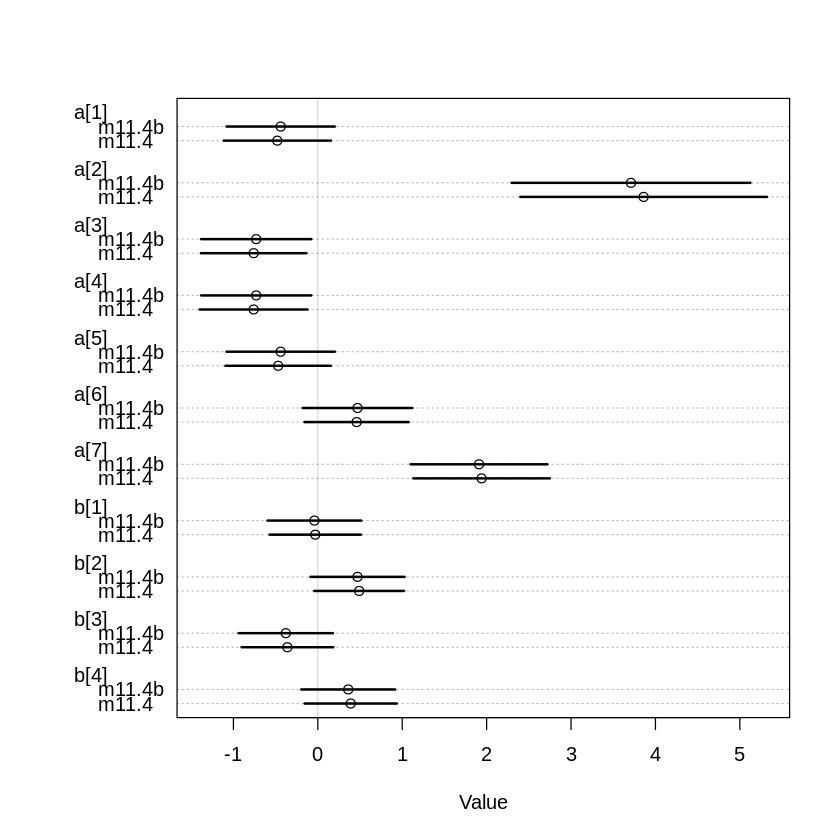

In [133]:
plot(coeftab(m11.4, m11.4b))

In [134]:
#Cannot compare like below, because the samples of the posterior are different between two methods.  
#So sample i in post has nothing to do with sample i in post_B.  
#So the difference between the two is not the correct way to interpret difference between the two distributions.

# diffA <- list()
# diffB <- list()

# diffAs <- sapply( 1:7 , function(k) ( post_B$a[,k] - post$a[,k] ) )
                 
# diffBs <- sapply( 1:4 , function(k) ( post_B$b[,k] - post$b[,k] ) )

# diffAs <- data.frame(diffAs)
                 
# plot(precis(diffAs))

Greatest variation (as expected) in actor 2 (X2).  The mean of the distribution is skewed to the negative side, meaning quap was on average lower than the ulam estimate.  Given that quap approximates with a quadratic (so symmetric), this implies that the distribution of a[2] estimated by ulam procedure must be skewed to the positive side nearer a probability of 1 (given that actor 2 always pulled the left lever).  We see this a bit in the parameter space using coeftab above.

In [135]:
# diffBs <- data.frame(diffBs)
# plot(precis(diffBs))

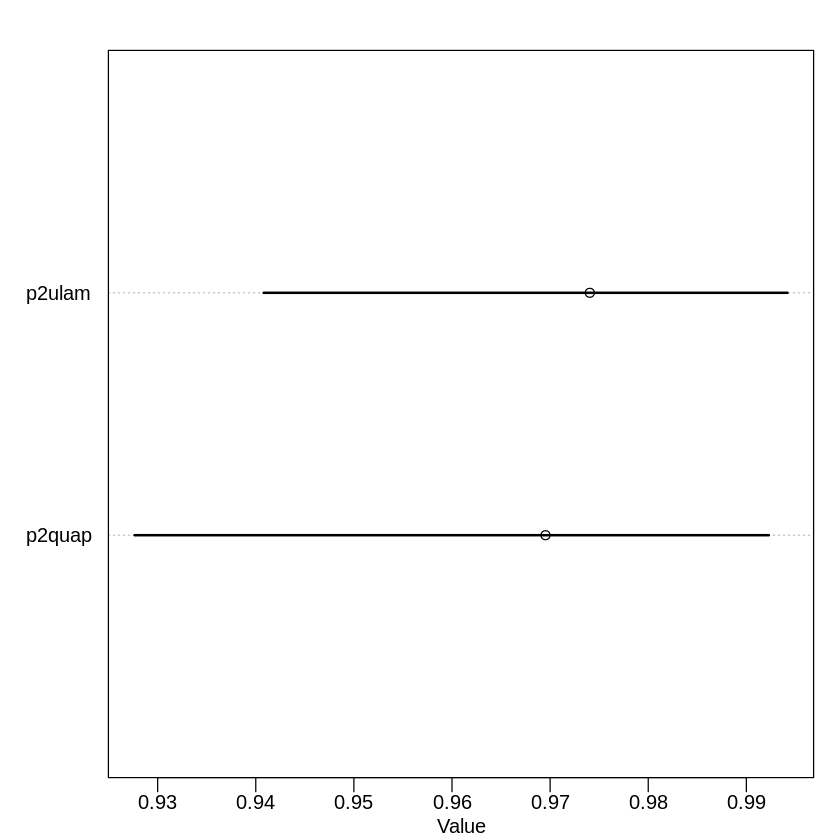

In [136]:
p2ulam <- inv_logit(post$a[,2])
p2quap <- inv_logit(post_B$a[,2])
                    
df <- data.frame( p2ulam, p2quap)

plot(precis(df))

This chart above is in probability space.  Now it appears that the quap distribution is more skewed in probability space.  As mentioned above, the mean for quap is below the mean for ulam.

From https://github.com/cavaunpeu/statistical-rethinking/blob/master/chapter-10/homework.R:

"The MAP estimation of a GLM assumes symmetric uncertainty around the posterior mode. In a logistic regression, uncertainty around a given parameter -
`bpC` in this case, for example - should not be assumed to be symmetric, as middling values of this coefficient will produce altogether different
marginal (proportional) changes in `p` (the probability of the positive event) than will extreme ones.

In this particular model, the estimates for the intercept for the second chimp differ greatly. This chimp never pulled the righthand lever, implying that
an infinite number of values for this intercept (given the fundamental behavior of the sigmoid, i.e. "saturation" when the values are really big
or small) would be valid. MCMC can recover this "long-tail" of the associated posterior, while MAP - which assumes symmetry - cannot."

10H2

In [142]:
compare(m11.3, m11.4, m11.5, m11.4b)

Warning message in compare(m11.3, m11.4, m11.5, m11.4b):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”

WAIC     pWAIC    dWAIC      weight       SE        dSE      
m11.5  530.2680 7.497482   0.000000 5.984293e-01 19.090102        NA
m11.4  532.0543 8.367990   1.786227 2.449845e-01 18.905373  1.313353
m11.4b 532.9495 8.416135   2.681403 1.565862e-01 18.619633  1.341700
m11.3  682.5452 3.656375 152.277170 5.133878e-34  9.183552 18.413618

In [141]:
compare(m11.1b, m11.3, m11.4)

Warning message in compare(m11.1b, m11.3, m11.4):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”

WAIC     pWAIC    dWAIC    weight       SE        dSE     
m11.4  532.0543 8.367990   0.0000 1.000000e+00 18.905373       NA
m11.3  682.6679 3.693151 150.6136 1.970935e-33  8.983780 18.40141
m11.1b 687.9113 0.985379 155.8570 1.432467e-34  7.165985 18.97385

m11.6 which uses aggregate binomial dist has lowest WAIC for reasons discussed in chapter and in practice question 10M1.  Difference is due to multiplicity of aggregate data.

m11.5 has marginally better predictive power, but difference of m11.4 is within 2*dSE, so cannot rule out m11.4 as good predictive model. m11.5 ignores interaction effects, unlike m11.4.

But question asks to compare m11.4 with simpler models.  
This really means m11.3, which has the same intercept for all actors, but different coefficients for different treatments (obviously, given they are the predictors).  Note that this model DOES feature interaction affects between prosocial side and presence of partner.
Models m11.1b just has one intercept for all actors and treatments, I suppose it's useful as a baseline.

Clearly, model m11.4 has the best prediction ability, with a dWAIC much larger than dSE.  Note the much larger pWAIC (effective number of paramters) for m11.4 though.

Remarkably, there is very little difference between the m11.1b baseline model and m11.3, which actually controls for the different treatments.  This suggests that the greatest explanatory power lies in the variation among actors, which is only controlled for in m11.4.  Indeed, practically all the WAIC weight is given to m11.4, if this was an ensemble model.

10H3

In [1]:
library(MASS);
data(eagles)

In [3]:
d <- eagles
d$Psize <- ifelse(d$P=='L',2L,1L)
d$Age <- ifelse(d$A=='A',2L,1L)
d$Vsize <- ifelse(d$V=='L',2L,1L)
# d$Psize <- as.integer(ifelse(d$P=='L',2,1))
# d$Age <- as.integer(ifelse(d$A=='A',2,1))
# d$Vsize <- as.integer(ifelse(d$V=='L',2,1))
d

y  n  P A V Psize Age Vsize
1 17 24 L A L 2     2   2    
2 29 29 L A S 2     2   1    
3 17 27 L I L 2     1   2    
4 20 20 L I S 2     1   1    
5  1 12 S A L 1     2   2    
6 15 16 S A S 1     2   1    
7  0 28 S I L 1     1   2    
8  1  4 S I S 1     1   1

We will change the structure of the model by replacing dummy variables with index variables, as advocated in the 2nd edition of the book.

In [20]:
m10H3q <- quap(
            alist(
                y ~ dbinom(n, p),
                logit(p) <- a + bP[Psize] + bA[Age] + bV[Vsize],
                a ~ dnorm(0,10),
#                c(bP[Psize], bA[Age], bV[Vsize]) ~ dnorm(0,5)
                bP[Psize] ~ dnorm(0,5), 
                bA[Age] ~ dnorm(0,5),
                bV[Vsize] ~ dnorm(0,5)
            ), data=d
        )

precis(m10H3q, depth=2)

mean       sd       5.5%      94.5%   
a      0.6907336 5.227363 -7.663602 9.045069
bP[1] -2.1035634 3.405223 -7.545768 3.338641
bP[2]  2.2787687 3.405370 -3.163670 7.721208
bA[1] -0.4487896 3.382030 -5.853926 4.956347
bA[2]  0.6389644 3.381806 -4.765815 6.043744
bV[1]  2.4688250 3.411663 -2.983671 7.921321
bV[2] -2.2782856 3.408502 -7.725730 3.169159

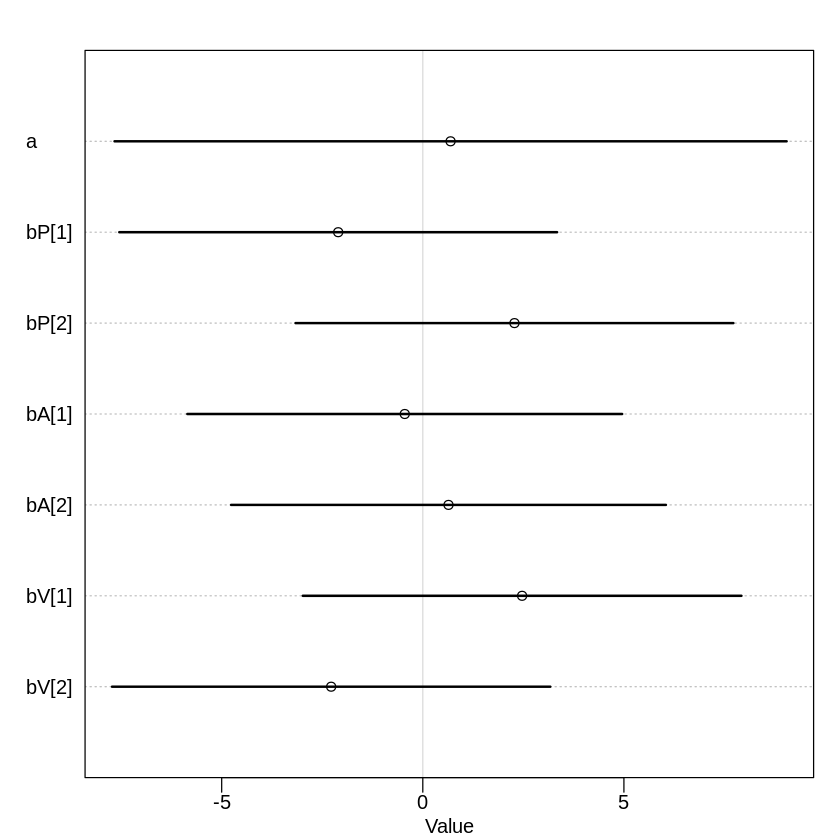

In [21]:
plot(precis(m10H3q, depth=2))

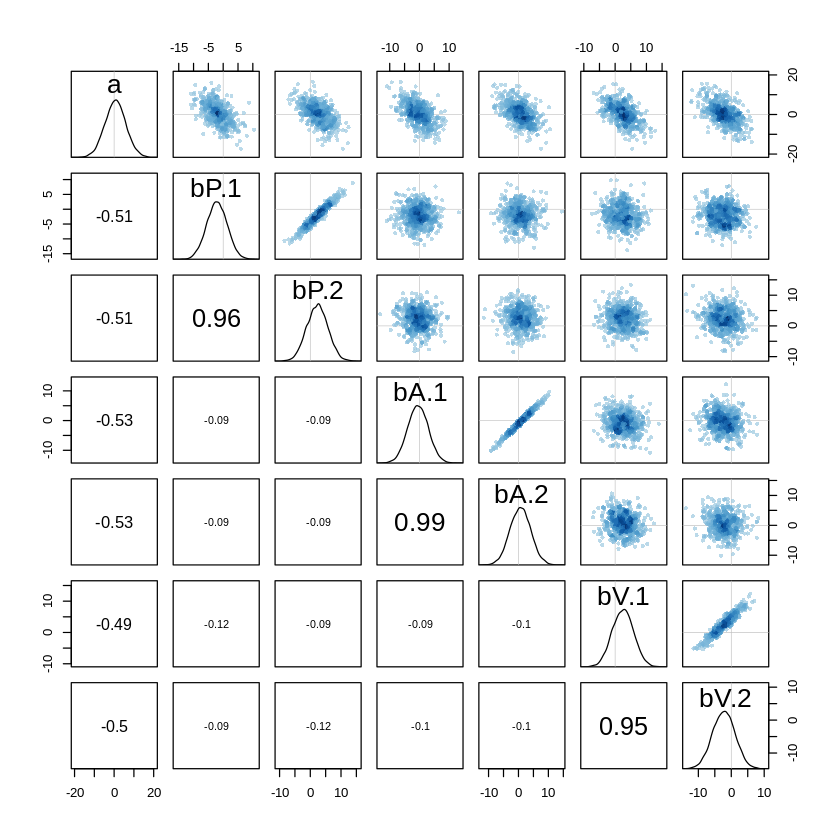

In [31]:
pairs(m10H3q)

In [4]:
dat_slim = list(y=d$y, n=d$n, Psize=d$Psize, Age=d$Age, Vsize=d$Vsize)

m10H3u <- ulam(
            alist(
                y ~ dbinom(n, p),
                logit(p) <- a + bP[Psize] + bA[Age] + bV[Vsize],
                a ~ dnorm(0,10),
#                c(bP[Psize], bA[Age], bV[Vsize]) ~ dnorm(0,5)
                bP[Psize] ~ dnorm(0,5), 
                bA[Age] ~ dnorm(0,5),
                bV[Vsize] ~ dnorm(0,5)
            ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
        )

In [28]:
precis(m10H3u, depth=2)

mean       sd       5.5%      94.5%    n_eff     Rhat     
a      0.6188014 5.266908 -7.936005 9.129662 1040.3567 1.0009824
bP[1] -2.3259384 3.447046 -7.699437 3.388774  925.8257 0.9990830
bP[2]  2.4872335 3.438853 -2.918443 8.123038  894.3197 0.9991055
bA[1] -0.3884887 3.241033 -5.461428 4.909924  917.9051 0.9996771
bA[2]  0.7746325 3.227581 -4.280398 5.993185  906.9941 0.9996095
bV[1]  2.7581931 3.435432 -2.690115 8.382437  960.2721 1.0024720
bV[2] -2.4790546 3.442251 -7.927806 3.033358  978.1909 1.0020758

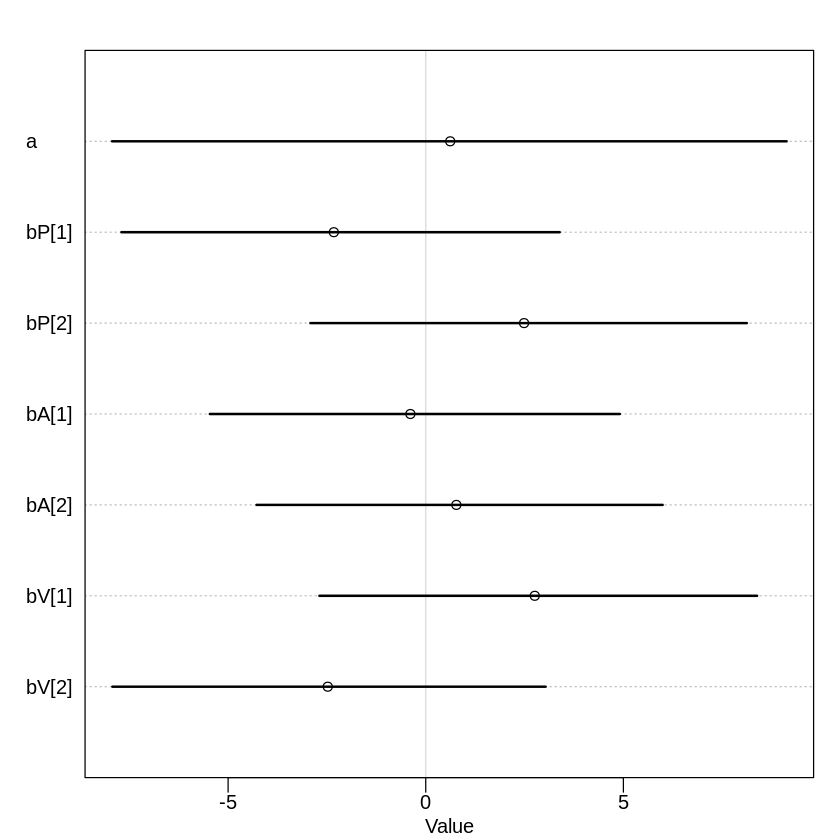

In [29]:
plot(precis(m10H3u, depth=2))

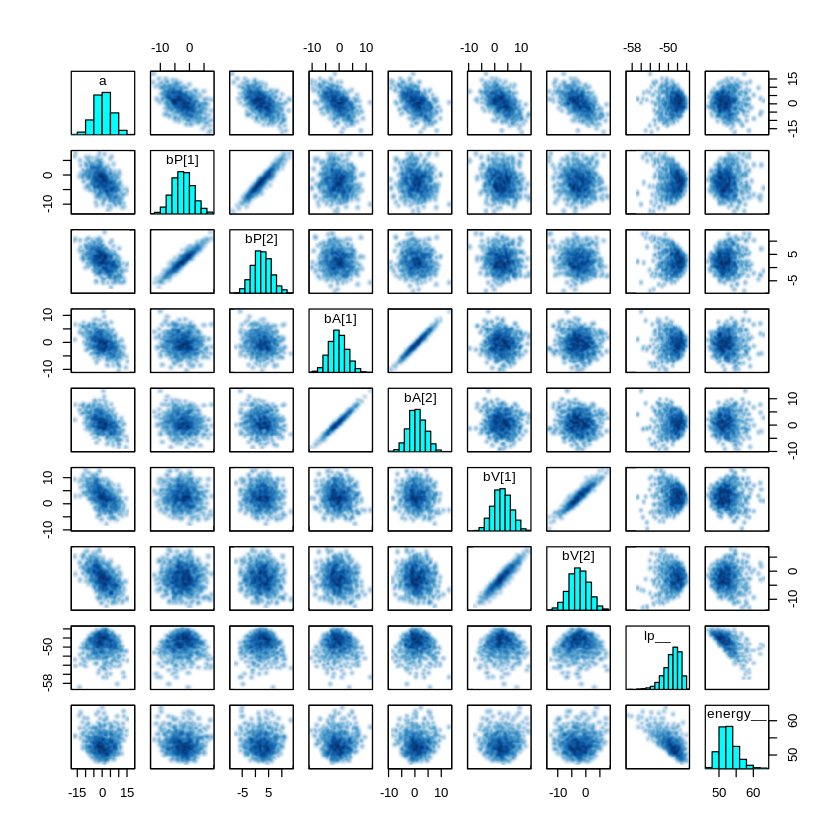

In [30]:
pairs(m10H3u@stanfit)

As discussed in an example in Chapter 11, the covariates have some correlation structure.  The pairs bP[1] with bP[2], bA[1] with bA[2] and bV[1] with bV[2].  This suggests co-linearity between these covariate pairs.  This is because b..[1] could be interpreted as 'not b..[2]'.  This adds to the standard error of the estimates, however it will not change the overall inference.  The same structure can be seen in the quap estimates too.  Perhaps we should look at the difference in between the indexed coefficients (the contrasts).  This tells us (in logit space) the effect of pirate size, age (experience) and victim size in the success of stealing food:

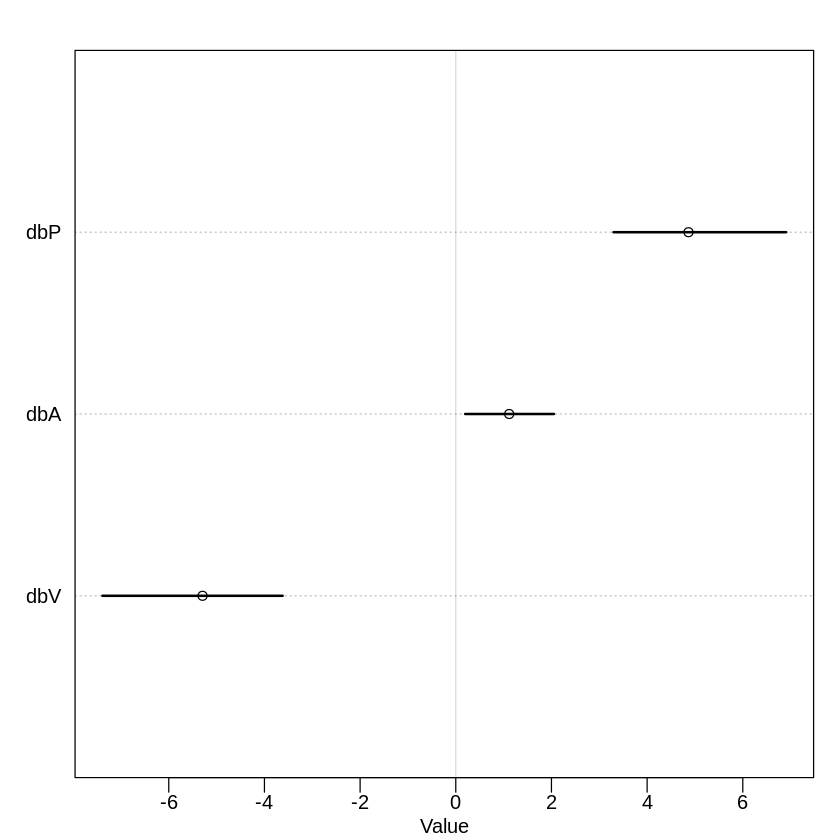

In [67]:
post <- extract.samples(m10H3u)

diffCoeffs <- list(
            dbP = post$bP[,2] - post$bP[,1],
            dbA = post$bA[,2] - post$bA[,1],
            dbV = post$bV[,2] - post$bV[,1]
            )

plot( precis(diffCoeffs) )

Clearly, being a larger pirate has a massive impact on success, as does the victim being smaller (in fact, these appear almost mirror images of distributions).  Age (experience) gives a slight advantage on average, across all size of pirate and victim, but it is quite close to zero.  Let's look at the implications in probability space:

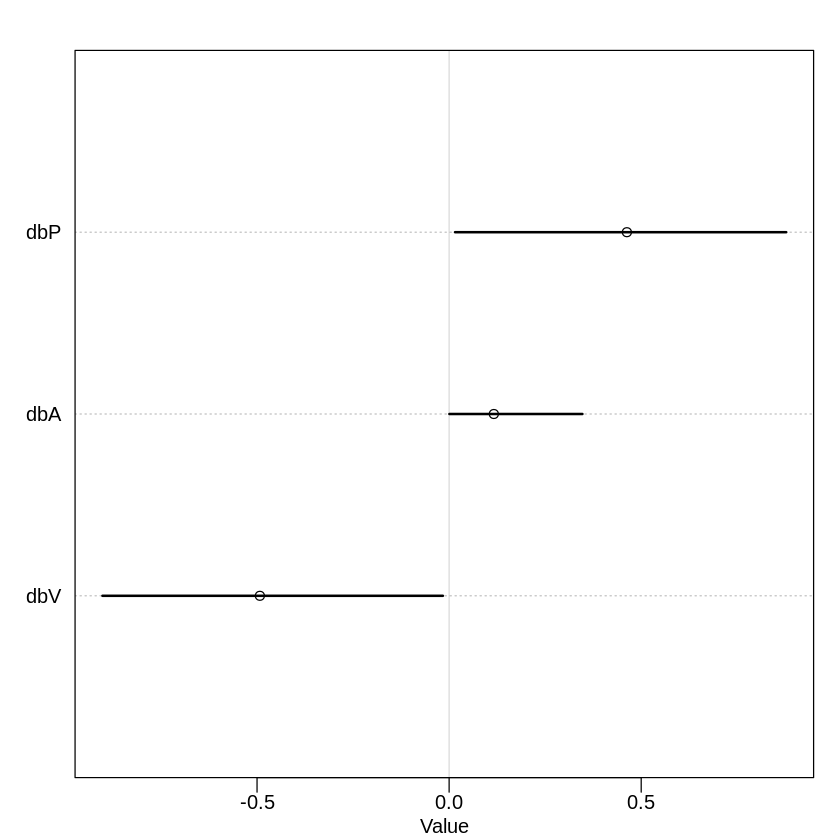

In [69]:
post <- extract.samples(m10H3u)

diffProbs <- list(
            dbP = inv_logit(post$bP[,2]) - inv_logit(post$bP[,1]),
            dbA = inv_logit(post$bA[,2]) - inv_logit(post$bA[,1]),
            dbV = inv_logit(post$bV[,2]) - inv_logit(post$bV[,1])
            )

plot( precis(diffProbs) )

So the large size of Pirate (Victim) has a massive increase (decrease) in probability of success, with mean 0.5, i.e. a 50% change in probability, but with a distribution covering values of 0 to almost 1.  Age (experience) has a modest increase, with mean of around 15% and distribution with 0 to 40$.

In our formulation, the estimates between quap and ulam appear to closely match:

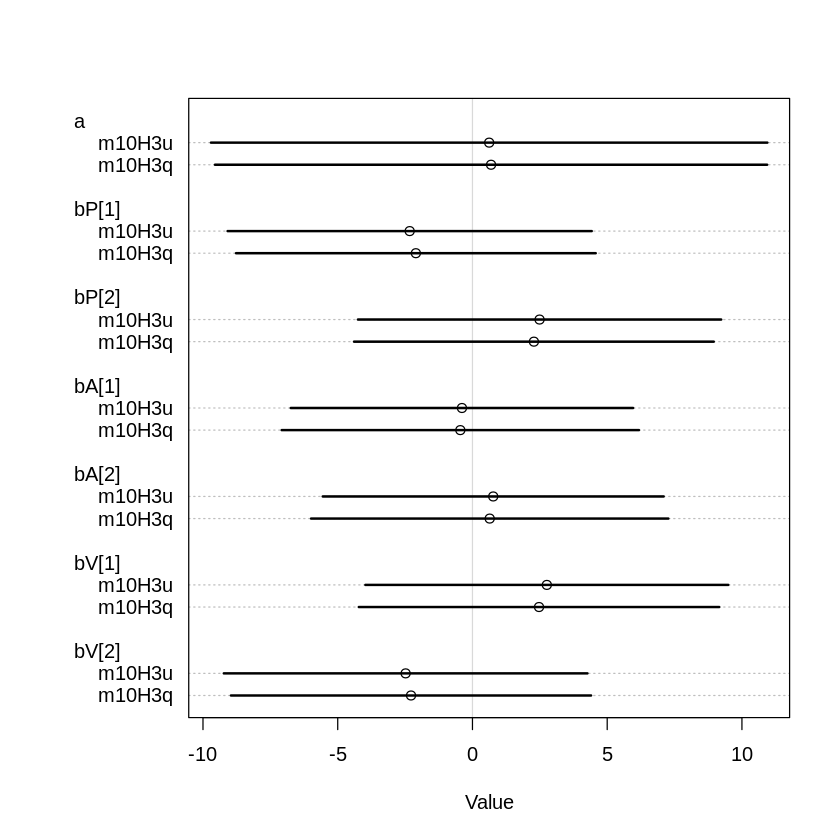

In [36]:
plot(coeftab(m10H3q, m10H3u))

The problem with these estimates is that, because we have used very flat priors, the estimates have large values in the logit space.  In the parameter space, this will be viewed as extreme values of p, either near 0 or near 1.  Perhaps we should consider more informative, regularizing priors, as discussed in Chapter 11?

In [49]:
dat_slim = list(y=d$y, n=d$n, Psize=d$Psize, Age=d$Age, Vsize=d$Vsize)

m10H3u2 <- ulam(
            alist(
                y ~ dbinom(n, p),
                logit(p) <- a + bP[Psize] + bA[Age] + bV[Vsize],
                a ~ dnorm(0,1.5),
#                c(bP[Psize], bA[Age], bV[Vsize]) ~ dnorm(0,5)
                bP[Psize] ~ dnorm(0,0.5), 
                bA[Age] ~ dnorm(0,0.5),
                bV[Vsize] ~ dnorm(0,0.5)
            ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
        )

In [38]:
precis(m10H3u2, depth=2)

mean       sd        5.5%       94.5%      n_eff     Rhat     
a      0.5640175 0.6043330 -0.3926889  1.5085161  919.7289 1.0016136
bP[1] -1.0301473 0.3903459 -1.6630495 -0.3993040 1057.9700 1.0001462
bP[2]  1.0990642 0.3961765  0.4643962  1.7315338 1009.5205 1.0005335
bA[1] -0.3734945 0.3825446 -0.9786173  0.2588967 1232.9957 0.9992898
bA[2]  0.4194874 0.3899983 -0.2000677  1.0616573 1326.1693 0.9992233
bV[1]  1.1688045 0.4105424  0.5006600  1.8273002 1235.3425 1.0036652
bV[2] -1.0693166 0.4007292 -1.7112345 -0.4302338 1255.8673 1.0027144

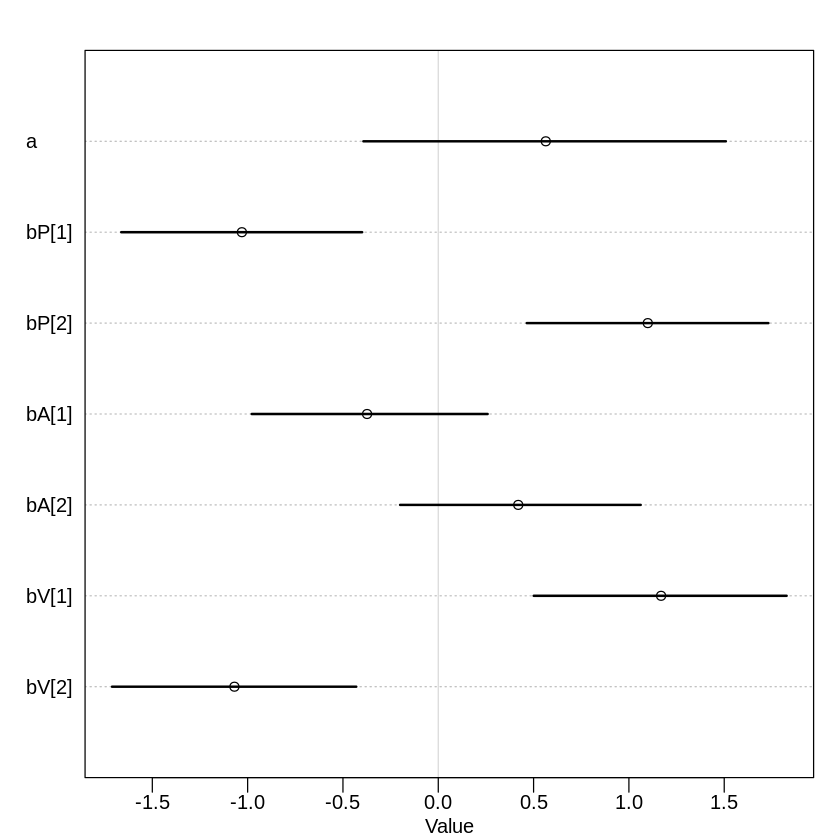

In [39]:
plot(precis(m10H3u2, depth=2))

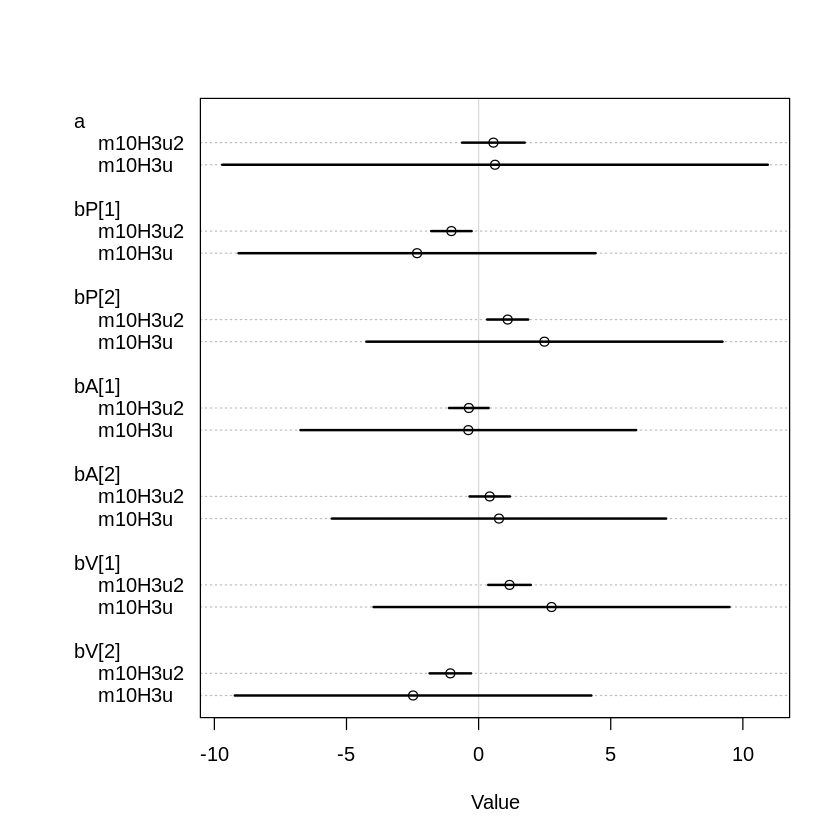

In [40]:
plot(coeftab(m10H3u, m10H3u2))

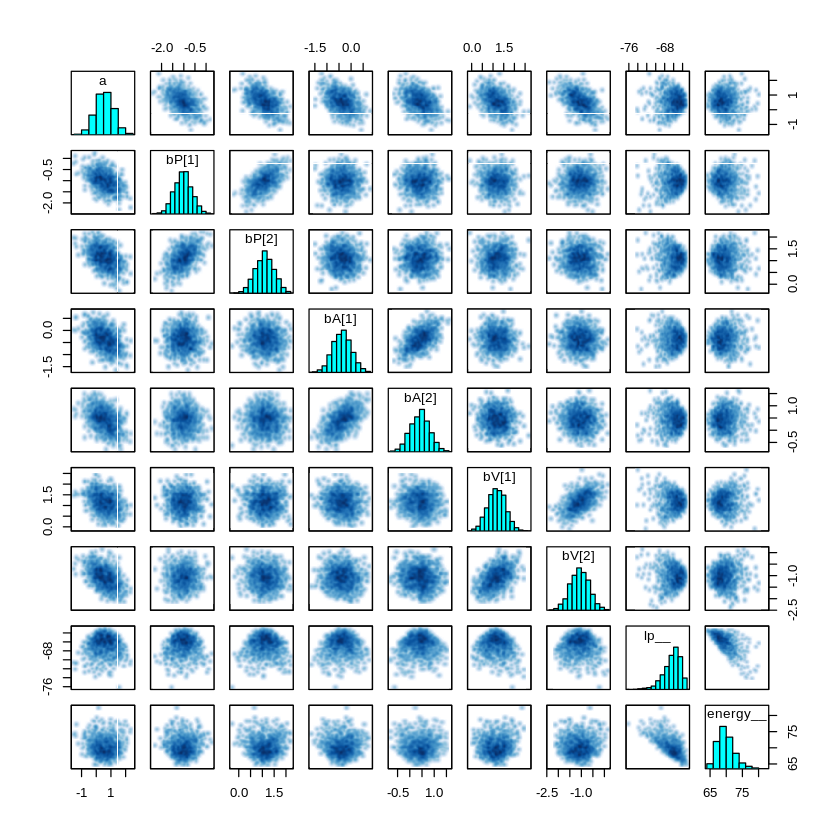

In [41]:
pairs(m10H3u2@stanfit)

The correlation of the coefficient pairs (b..[1] with b..[2]) has now be much reduced.  Comparing the coefficients, the age coefficients bA are very similar with the flat prior model.  In fact, the magnitude of the mean of the estimates is fairly close to zero, showing that age does not influence the probability of successful catching very much.  Much more important are the sizes of the victim and pirate, with coefficients having magnitudes much further from zero.  In fact, with the flat prior, the magnitudes grow even more, and it seems from comparing the mean of the coefficients, that regularizing has prevented the magnitudes from growing so much.  However, the trade off is that we do not overfit so much.

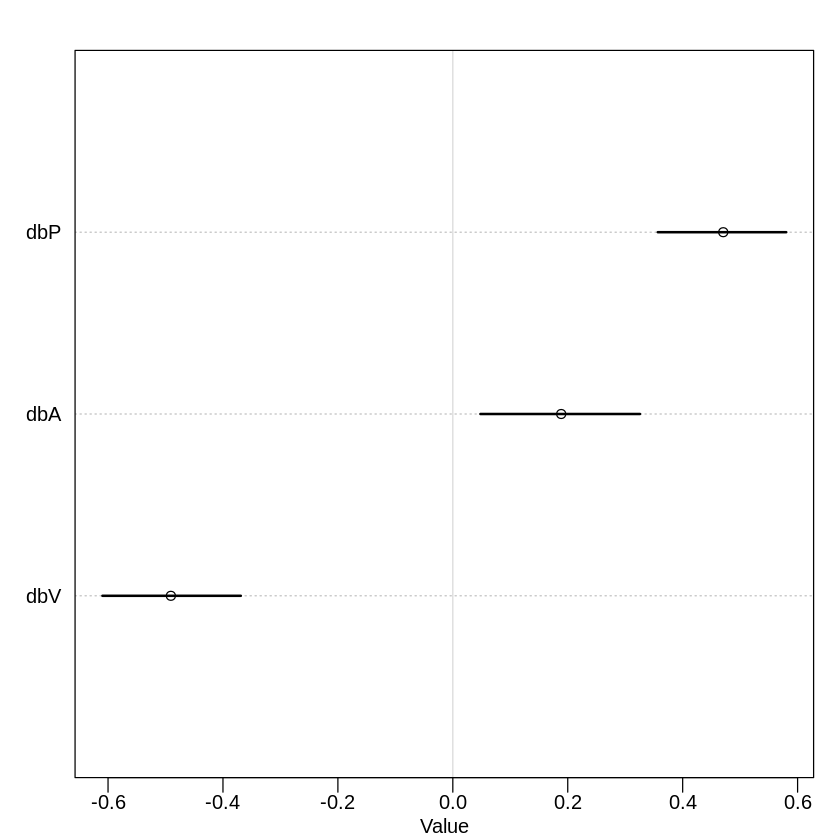

In [71]:
post <- extract.samples(m10H3u2)

diffProbs <- list(
            dbP = inv_logit(post$bP[,2]) - inv_logit(post$bP[,1]),
            dbA = inv_logit(post$bA[,2]) - inv_logit(post$bA[,1]),
            dbV = inv_logit(post$bV[,2]) - inv_logit(post$bV[,1])
            )

plot( precis(diffProbs) )

Actually, the large size of Pirate (Victim) has a similar mean effect on success as in the flat prior version of the model.  Just the extreme changes in probability of 0 or almost 1 have been removed (standard error of 0.5), so that the standard error in the change of probability is now around 10% probability.  The age (experience) contrast is also still around 20% with a standard error of around 15%.

We should check how quap handles the regularizing priors, and also compare the models using WAIC or LOO.

In [43]:
m10H3q2 <- quap(
            alist(
                y ~ dbinom(n, p),
                logit(p) <- a + bP[Psize] + bA[Age] + bV[Vsize],
                a ~ dnorm(0,1.5),
#                c(bP[Psize], bA[Age], bV[Vsize]) ~ dnorm(0,5)
                bP[Psize] ~ dnorm(0,0.5), 
                bA[Age] ~ dnorm(0,0.5),
                bV[Vsize] ~ dnorm(0,0.5)
            ), data=d
        )

precis(m10H3q2, depth=2)

mean       sd        5.5%       94.5%     
a      0.5632077 0.5979207 -0.3923851  1.5188005
bP[1] -1.0131880 0.3917740 -1.6393184 -0.3870575
bP[2]  1.0757666 0.3908947  0.4510414  1.7004918
bA[1] -0.3536766 0.3896532 -0.9764178  0.2690645
bA[2]  0.4162558 0.3895095 -0.2062555  1.0387672
bV[1]  1.1258330 0.3992853  0.4876980  1.7639680
bV[2] -1.0632541 0.3956189 -1.6955295 -0.4309787

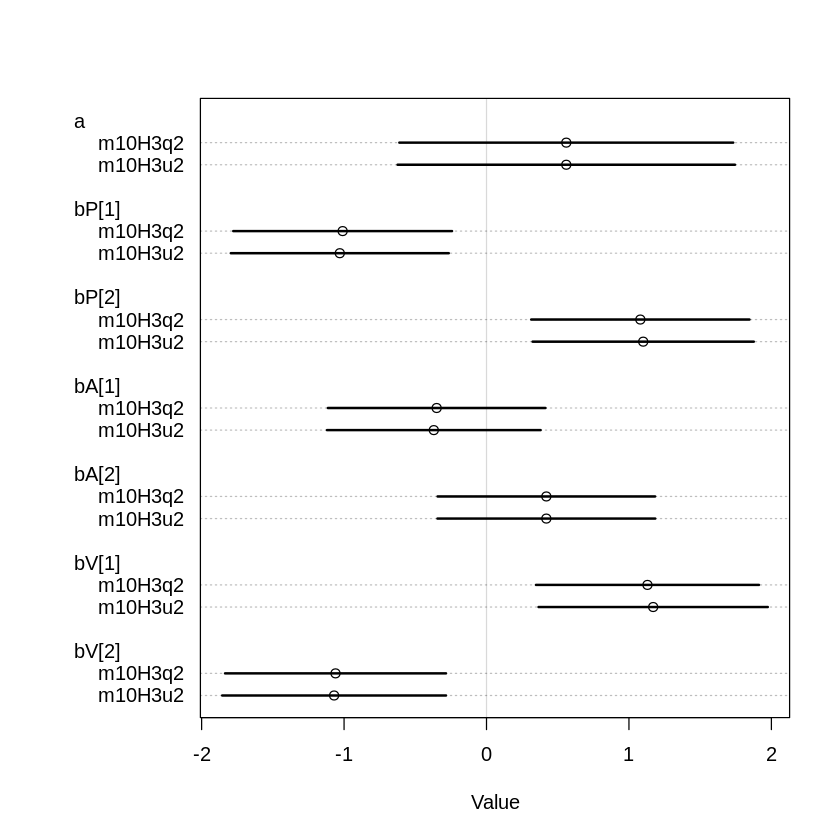

In [46]:
plot(coeftab(m10H3u2, m10H3q2))

Again, very little difference in the coefficients estimated using quap instead of ulam.  Ulam occasionally produces coefficients that have a slightly greater magnitude (e.g. bV[1]), but the difference is insignificant.  Therefore, we an use the quap estimates if we want.  Let's check the pairs plot for quap:

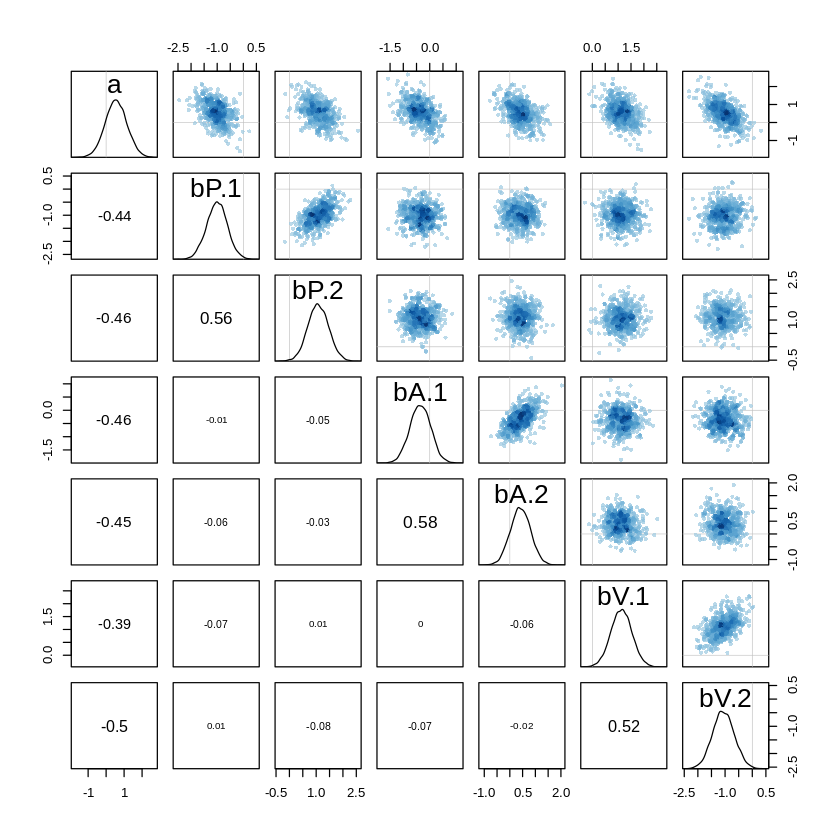

In [47]:
pairs(m10H3q2)

Again, the correlation structure of the pairs of coefficients has been much reduced, restricting the colinearity of the covariates, which has led to much smaller standard errors in the estimation of the coefficients.

Let's just check the contrasts in probability space of the restricted quap model.

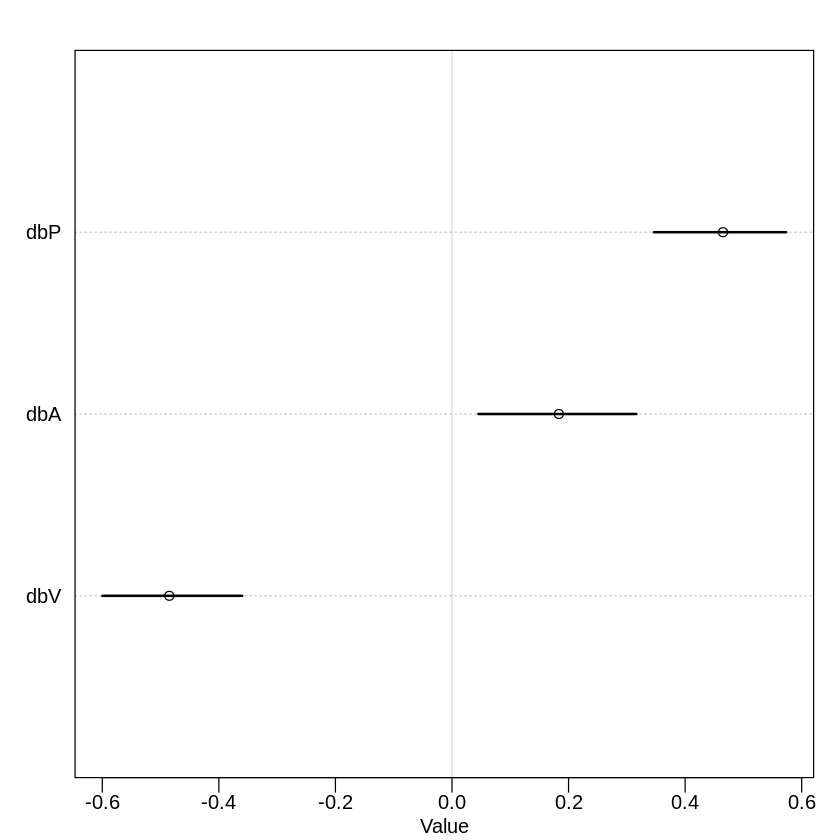

In [72]:
post <- extract.samples(m10H3q2)

diffProbs <- list(
            dbP = inv_logit(post$bP[,2]) - inv_logit(post$bP[,1]),
            dbA = inv_logit(post$bA[,2]) - inv_logit(post$bA[,1]),
            dbV = inv_logit(post$bV[,2]) - inv_logit(post$bV[,1])
            )

plot( precis(diffProbs) )

They unsurprisingly are similar to the ulam restricted prior contrasts.

Let's compare the models so far:

In [52]:
compare(m10H3q, m10H3u, m10H3q2, m10H3u2, func=LOO)

Warning message in compare(m10H3q, m10H3u, m10H3q2, m10H3u2, func = LOO):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO       pLOO     dLOO     weight       SE        dSE     
m10H3u   36.38775 8.004037  0.00000 9.955105e-01 10.640451       NA
m10H3u2  47.19076 7.053118 10.80301 4.489547e-03  8.075912 14.24088
m10H3q   98.57678 3.824735 62.18903 3.117949e-14 12.768710 46.54218
m10H3q2 110.92805 1.985783 74.54030 6.483736e-17  8.769024 10.19127

Comparing the models using LOO, despite the warnings about using different algorithms to fit the models, despite the similarity in the coefficients between MCMC and quadratic approximation, the MCMC (ulam) models have much more predictive power than the quap models  OK, they also have many more effective parameters, so an overfit is more likely.  In fact, there are only 8 data points in the data and the effective parameters of the flat prior MCMC is 8, so it's quite probable the model is overfit.  The ulam with restrictive priors has effective parameters of 7.  Going by what the book says, outside of normal linear regression, there is not a clear relationship between effective parameters and model complexity (especially so, when using logit link function, which suggests the parameters of the model are bounded, i.e. 0 <= p <= 1).

In [78]:
(k <- LOOPk(m10H3u))
(k2 <- LOOPk(m10H3u2))

# plot( d$y , d$T , xlab="log population (std)" , ylab="total tools" ,
# col=rangi2 , pch=ifelse( dat$cid==1 , 1 , 16 ) , lwd=2 ,
# ylim=c(0,75) , cex=1+normalize(k) )
# # set up the horizontal axis values to compute predictions at
# ns <- 100
# P_seq <- seq( from=-1.4 , to=3 , length.out=ns )

# # predictions for cid=1 (low contact)
# lambda <- link( m11.10 , data=data.frame( P=P_seq , cid=1 ) )
# lmu <- apply( lambda , 2 , mean )
# lci <- apply( lambda , 2 , PI )
# lines(P_seq , lmu , lty=2 , lwd=1.5 )
# shade(lci , P_seq , xpd=TRUE )

# # predictions for cid=2 (high contact)
# lambda <- link( m11.10 , data=data.frame( P=P_seq , cid=2 ) )
# lmu <- apply( lambda , 2 , mean )
# lci <- apply( lambda , 2 , PI )
# lines( P_seq , lmu , lty=1 , lwd=1.5 )
# shade( lci , P_seq , xpd=TRUE )

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”

[1] 1.2598556 0.1350376 1.1121385 0.3255307 0.5009369 0.8093087 0.4737264
[8] 0.9971960

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

[1] 0.4003749 0.3054922 0.9160933 0.6331841 0.5712100 0.7132176 0.8346990
[8] 0.2577578

From the book: "Larger [k] values indicate less reliable pointwise estimates and more influential points.  In theory, values between 0.5 and 1 are worrisome, and anything above 1 is wildly untrustworthy."

The flat prior model has very high k diagnostics - i.e. the first and third data points are incredibly influential on the fit (these are the large pirate on large victim data points for adult and immature pirates) and also the 6th and 8th (small pirate on small victim).
                                                                                                                               
The restricted prior model has somewhat lower, but still a bit too high k diagnostics, i.e. for data points 3, 6 and 7.                                                                                            

In [79]:
#help('pareto-k-diagnostic')

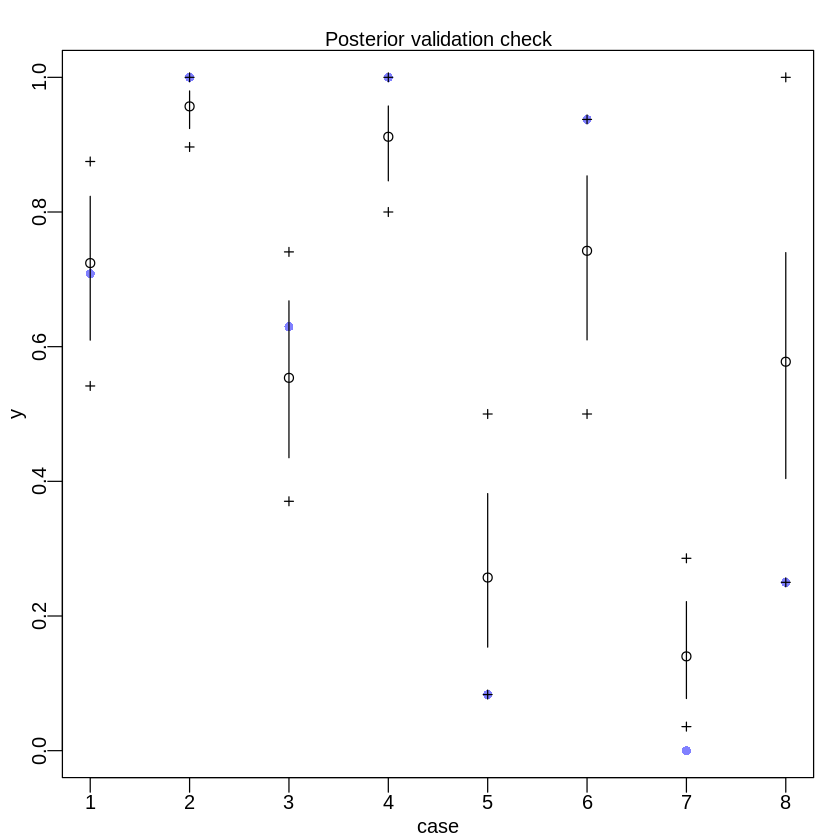

In [54]:
postcheck( m10H3q2 , n=1e4 )

# # draw lines connecting points from same dept
# d$dept_id <- rep( 1:6 , each=2 )
# for ( i in 1:6 ) {
#     x <- 1 + 2*(i-1)
#     y1 <- d$admit[x]/d$applications[x]
#     y2 <- d$admit[x+1]/d$applications[x+1]
#     lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
#     text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
# }

This suggests the regularized model does a poor job of predicting.  From the data, it seems that there are a lot of extreme values of p, i.e. a bird is very successful or not.  Let's look at the regularized version for ulam , before looking at the flat prior versions.

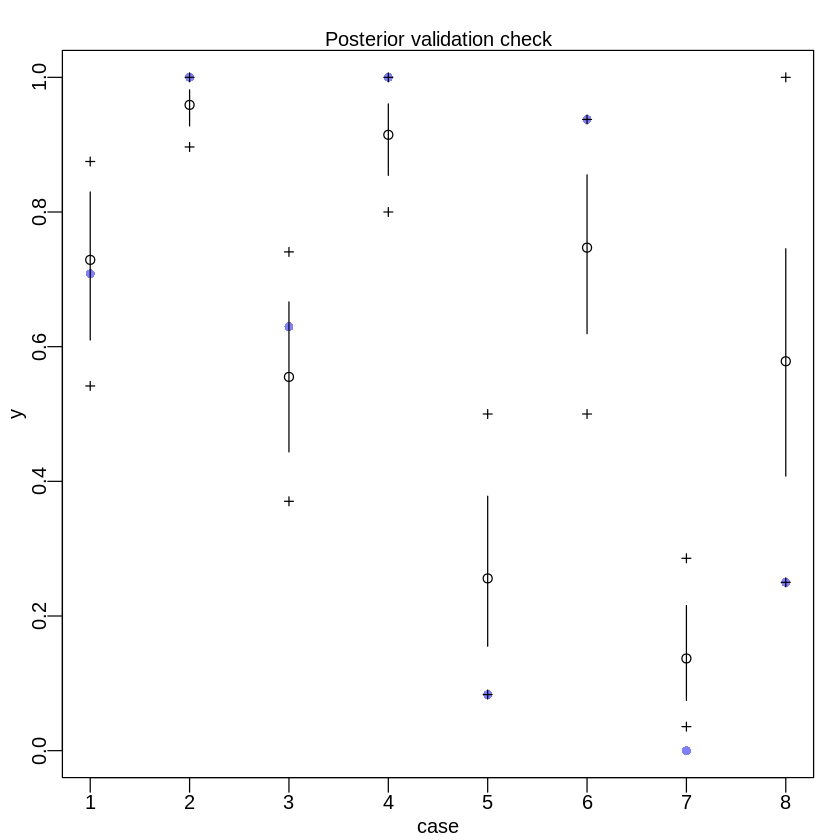

In [57]:
postcheck( m10H3u2 , n=1e4 )

The ulam version is similar to quap, as expected due to the similar estimates.  Both versions with regularizing priors do a poor job of matching the data.

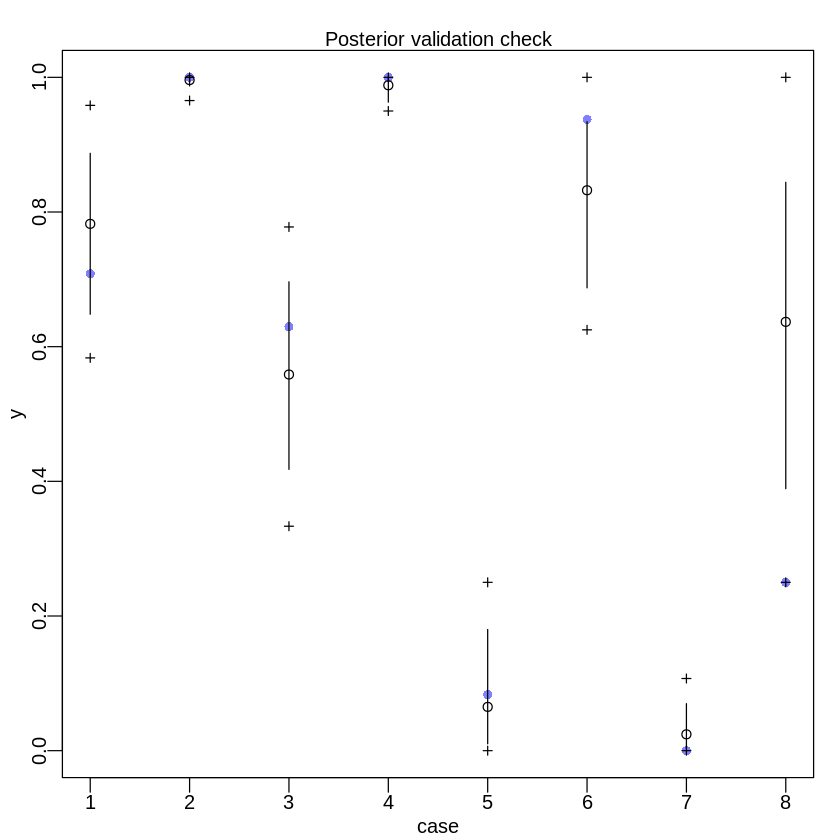

In [59]:
postcheck( m10H3q , n=1e4 )

The flat prior version of quap fit does a much better job of capturing the extreme values of p of the data.  Let's look at the flat prior ulam fit.

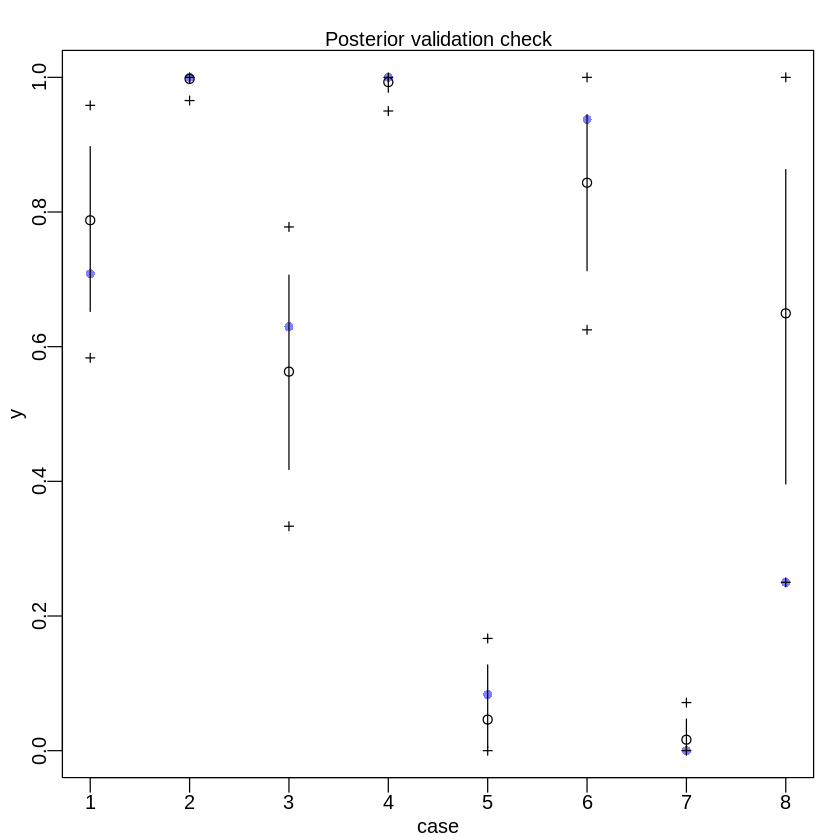

In [60]:
postcheck( m10H3u , n=1e4 )

As expected, ulam performs similarly to quap because the estimates are similar.  Note the difficulty in predicting bird type 8 (small, immature birds trying to steal from other small birds); the data is far outside the predicted distribution of success.  Compare with the success of small adult birds stealing from other small birds (bird type 6.  In this case, age (experience) really does make a difference.  (And note that age doesn't seem to have much of an effect on large pirate on large victim, this really seems to only apply to small on small).  So an improved model would have an interaction term for age interacting with size of pirate and victim.  Given this is a 3-way effect, perhaps we should also include 2-way effects?

In order to answer question (b), we need to produce posterior predictions of (i) predicted probability of success and (ii) predicted success count.  In the second case, what should the number of trials, n, be?  Should we stick with the values of n in the data or just use a fixed constant, such as 100 or 1000?

Let's first make the posterior predictions of probability of success.

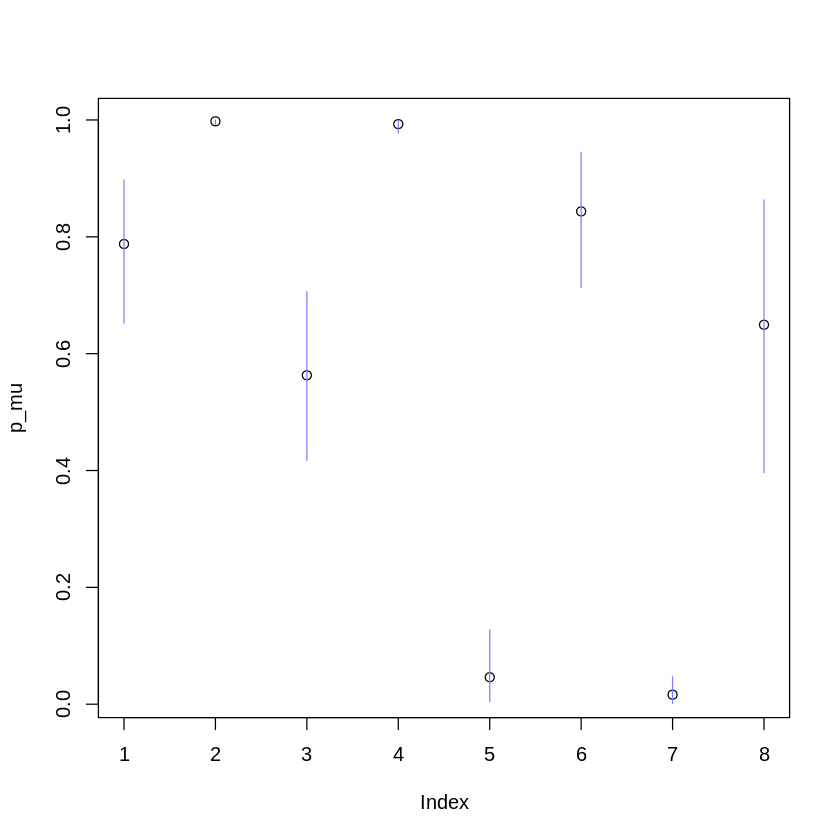

In [158]:
#dat = list(Psize=d$Psize, Age=d$Age, Vsize=d$Vsize)

p_post <- link_ulam( m10H3u )
p_mu <- apply( p_post , 2 , mean )
p_pi <- apply( p_post , 2 , PI, prob=0.89 )

plot(p_mu)
for ( i in 1:8 ) lines( rep(i,2) , p_pi[,i] , col=rangi2 )

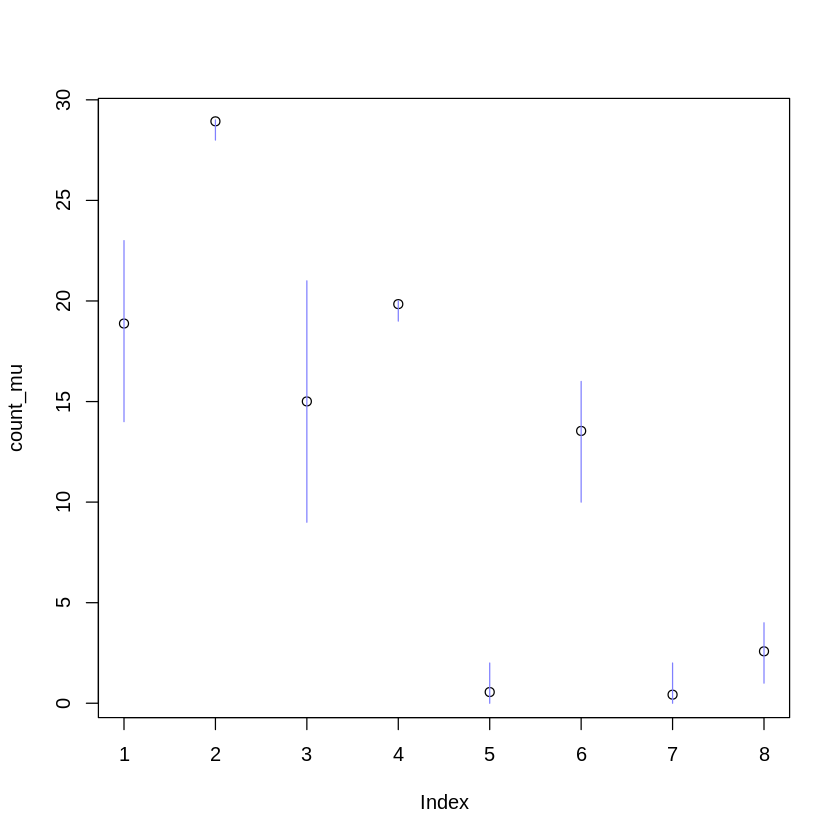

In [155]:
counts <- sim_ulam( m10H3u )
count_mu <- apply( counts , 2 , mean )
count_pi <- apply( counts , 2 , PI, prob=0.89 )

plot(count_mu)
for ( i in 1:8 ) lines( rep(i,2) , count_pi[,i] , col=rangi2 )

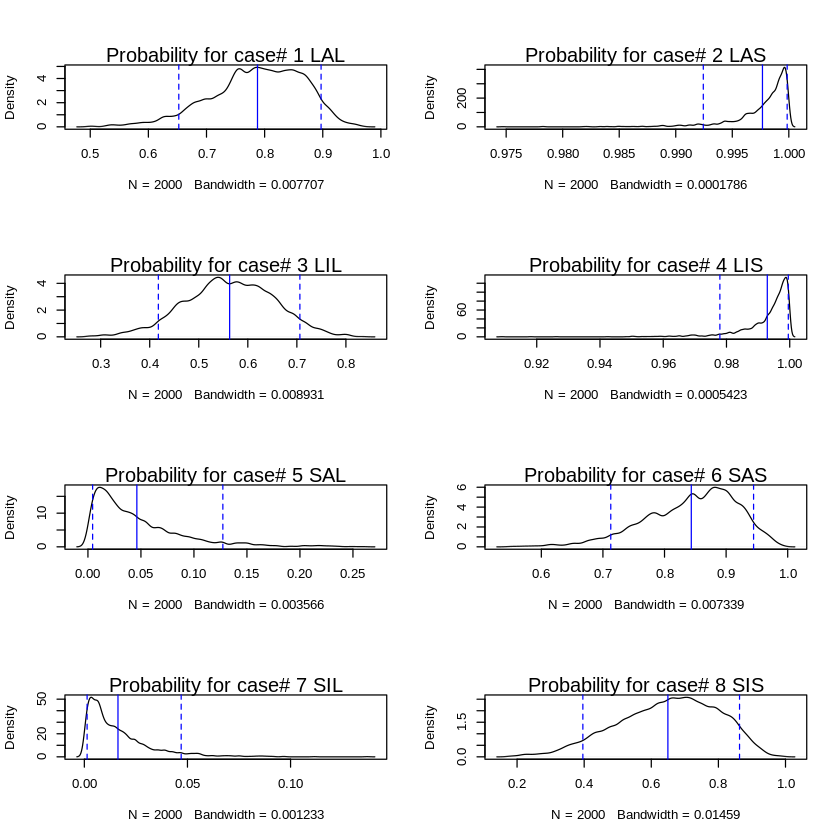

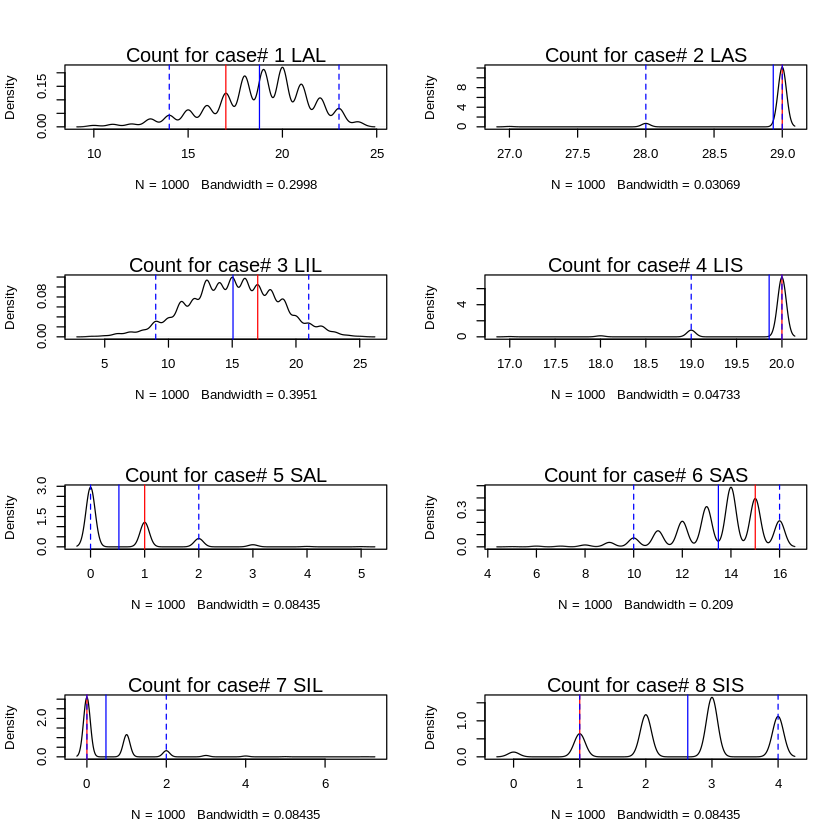

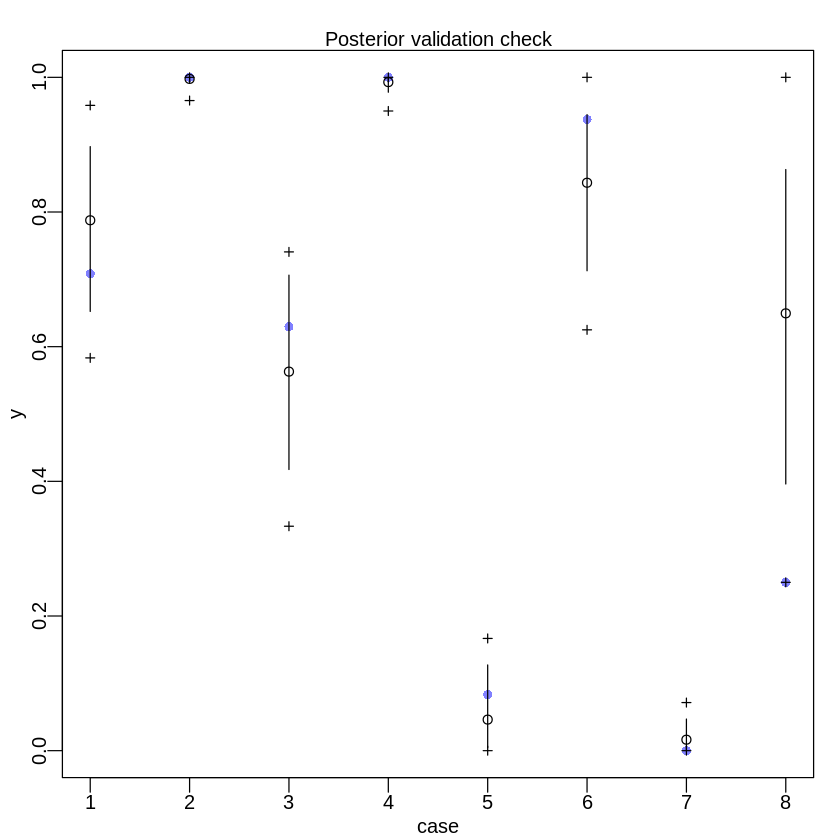

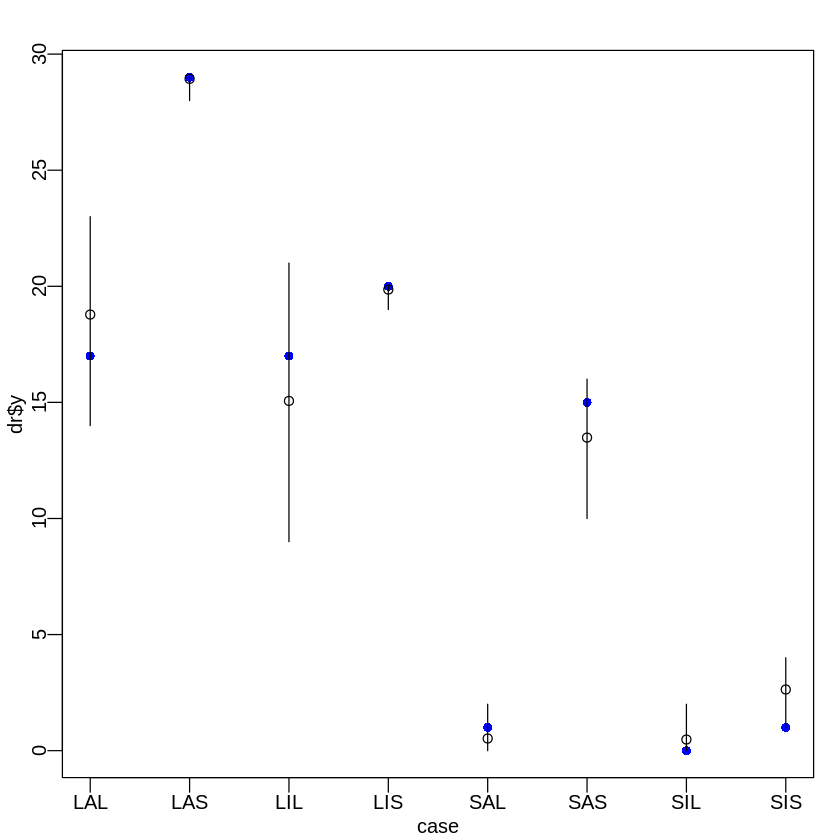

In [153]:
# From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9:

d$lbl <- with(d, paste0(P,A,V))
post_dens_probs <- function(model, d){
  prob.sample <- link(model)
  prob.mean <- apply(prob.sample, 2, mean)
  prob.pi <- apply(prob.sample, 2, PI, 0.89)
  
  dr <- d
  dr$p_pred <- prob.mean
  dr$p_pred_low <- prob.pi[1,]
  dr$p_pred_high <- prob.pi[2,]
  
  par(mfrow=c(4,2))
  for(i in 1:8){
    dens(prob.sample[,i]) #, xlim=c(0,1)
    abline(v=d$prob[i], col='red')
    abline(v=prob.mean[i], col='blue')
    abline(v=prob.pi[,i], col='blue', lty=2)
    mtext(paste('Probability for case#',i,dr$lbl[i]))
  }
  dr
}

# plot counts
post_dens_counts <- function(model, d){
  cnt.sample <- sim(model)
  cnt.mean <- apply(cnt.sample, 2, mean)
  cnt.pi <- apply(cnt.sample, 2, PI, 0.89)
  
  dr <- d
  dr$y_pred <- cnt.mean
  dr$y_pred_low <- cnt.pi[1,]
  dr$y_pred_high <- cnt.pi[2,]
  dr

  par(mfrow=c(4,2))
  for(i in 1:8){
    dens(cnt.sample[,i]) 
    abline(v=d$y[i], col='red')
    abline(v=cnt.mean[i], col='blue')
    abline(v=cnt.pi[,i], col='blue', lty=2)
    mtext(paste('Count for case#',i,dr$lbl[i]))
  }
  dr
}

dr <- post_dens_probs(m10H3u, d)
dr <- post_dens_counts(m10H3u, dr)
par(mfrow=c(1,1))
postcheck(m10H3u, prob=0.89)

# case 8 has the worst predictions

par(mfrow=c(1,1))
plot(dr$y, col='blue', pch=16,  xlab="case", xaxt="n" )
points(dr$y_pred)
for(i in 1:8){
  lines( c(i, i), c(dr$y_pred_low[i], dr$y_pred_high[i]) )
}
axis(1, at=1:8, labels=dr$lbl)

In [159]:
d

y  n  P A V Psize Age Vsize lbl
1 17 24 L A L 2     2   2     LAL
2 29 29 L A S 2     2   1     LAS
3 17 27 L I L 2     1   2     LIL
4 20 20 L I S 2     1   1     LIS
5  1 12 S A L 1     2   2     SAL
6 15 16 S A S 1     2   1     SAS
7  0 28 S I L 1     1   2     SIL
8  1  4 S I S 1     1   1     SIS

Part c).  Improving the model.  Having seen the data, it appears that a three-way interaction of Psize, Age and Vsize would be appropriate.  However the question asks for a two-way interaction of Psize and Age.  So, at least starting things simply, we will go along with this.

In [5]:
d$cond <- as.integer(2*(d$Psize-1) + d$Age)
d$condB <- 1:8
d

y  n  P A V Psize Age Vsize cond condB
1 17 24 L A L 2     2   2     4    1    
2 29 29 L A S 2     2   1     4    2    
3 17 27 L I L 2     1   2     3    3    
4 20 20 L I S 2     1   1     3    4    
5  1 12 S A L 1     2   2     2    5    
6 15 16 S A S 1     2   1     2    6    
7  0 28 S I L 1     1   2     1    7    
8  1  4 S I S 1     1   1     1    8

In [6]:
dat_slim = list(y=d$y, n=d$n, Psize=d$Psize, Age=d$Age, Vsize=d$Vsize, cond=d$cond)

m10H3uCond <- ulam(
            alist(
                y ~ dbinom(n, p),
                logit(p) <- a + bP[Psize] + bA[Age] + bV[Vsize] + bPA[cond],
                a ~ dnorm(0,10),
#                c(bP[Psize], bA[Age], bV[Vsize]) ~ dnorm(0,5)
                bP[Psize] ~ dnorm(0,5), 
                bA[Age] ~ dnorm(0,5),
                bV[Vsize] ~ dnorm(0,5),
                bPA[cond] ~ dnorm(0,2)
            ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
        )

In [198]:
precis(m10H3uCond, depth=2)

mean       sd       5.5%      94.5%    n_eff    Rhat     
a       0.5964945 5.308597 -7.868711 9.288810 1169.943 1.0010883
bP[1]  -2.5152292 3.551422 -8.316096 2.958240 1296.727 0.9998535
bP[2]   2.7330439 3.560622 -3.000808 8.267626 1324.024 0.9988526
bA[1]  -0.7867747 3.607660 -6.394291 4.969708 1251.695 1.0008297
bA[2]   1.2992835 3.464044 -4.167851 6.971446 1450.763 1.0007621
bV[1]   2.7800643 3.431268 -2.776195 8.223406 1349.046 1.0033859
bV[2]  -2.9731443 3.421837 -8.398860 2.396414 1407.345 1.0020561
bPA[1] -1.1667129 1.711218 -3.955604 1.606727 1987.066 1.0001639
bPA[2]  0.7477240 1.660402 -1.864744 3.434342 1688.566 0.9989430
bPA[3]  0.9639264 1.730121 -1.891361 3.763153 1762.574 1.0007775
bPA[4] -0.6652886 1.671007 -3.339126 1.968772 1972.100 1.0002325

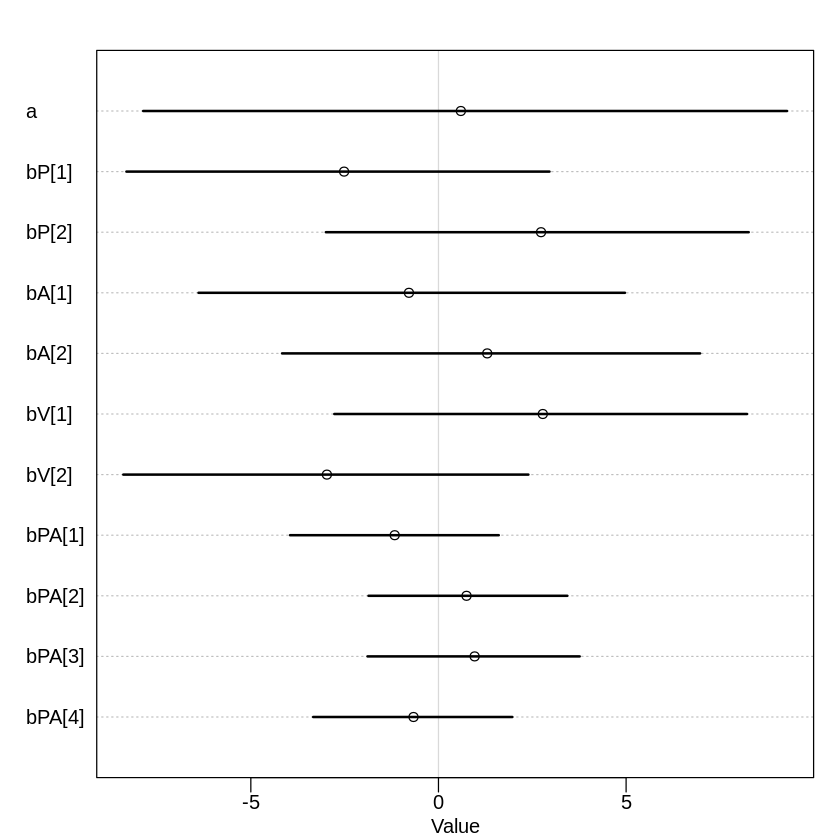

In [199]:
plot(precis(m10H3uCond, depth=2))

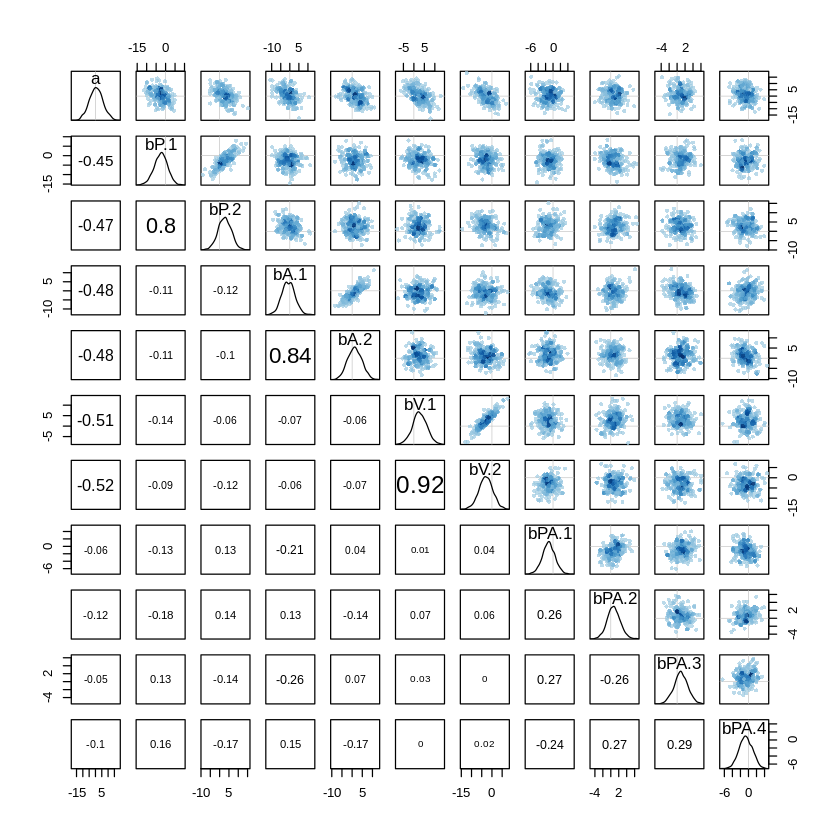

In [200]:
pairs(m10H3uCond@stanfit)

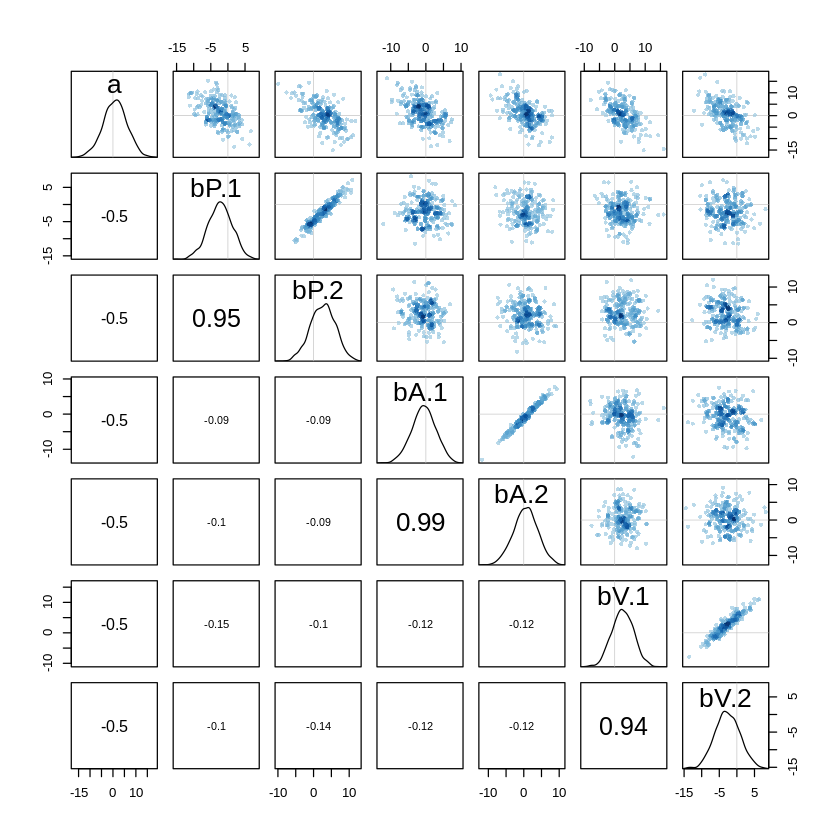

In [188]:
pairs(m10H3u@stanfit)

The addition of the bPA interaction term removes the correlation of the bP pair and bA pair.  Let's look at LOO:

In [7]:
compare(m10H3u, m10H3uCond, func=LOO)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

LOO      pLOO     dLOO     weight      SE       dSE     
m10H3uCond 22.64308 3.039912  0.00000 0.997823302 6.684684       NA
m10H3u     34.89861 7.257082 12.25553 0.002176698 9.682622 3.722665

The model with the interaction does a much better job of prediction, as assessed by LOO.  This is despite the reduction in the effective parameters (probably due to the parameters being near their bounds, as discussed in Chapter 11).

In [8]:
(k <- LOOPk(m10H3u))
(kCond <- LOOPk(m10H3uCond))

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

[1] 0.8016494 0.4409915 1.2437760 0.2988255 0.7082048 0.6760176 0.6174681
[8] 0.7174225

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”

[1] 0.7581761 0.4033022 0.7803449 0.2459479 0.7145332 0.9133175 0.3302210
[8] 0.7119304

The model with the interaction term also has better pareto-k diagnostics (anything below 0.7 is acceptable, check out the help docs).

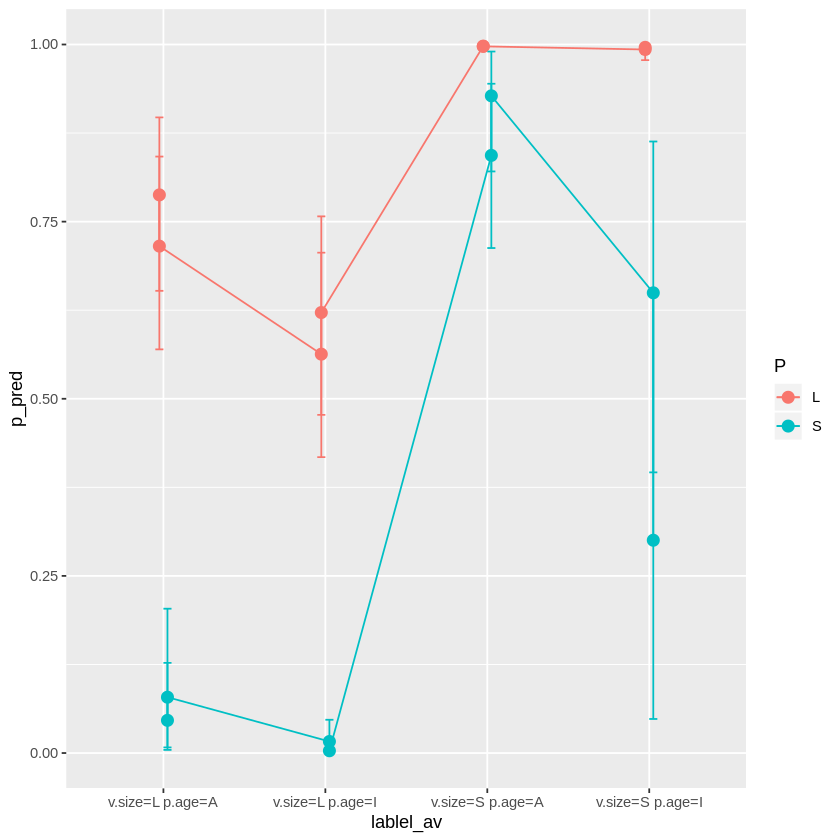

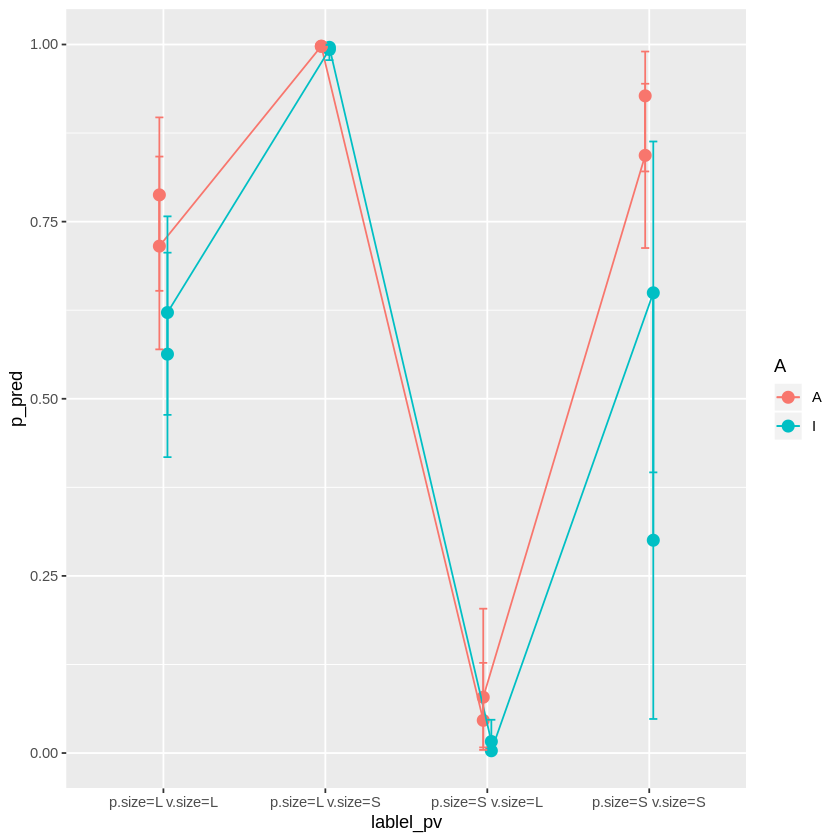

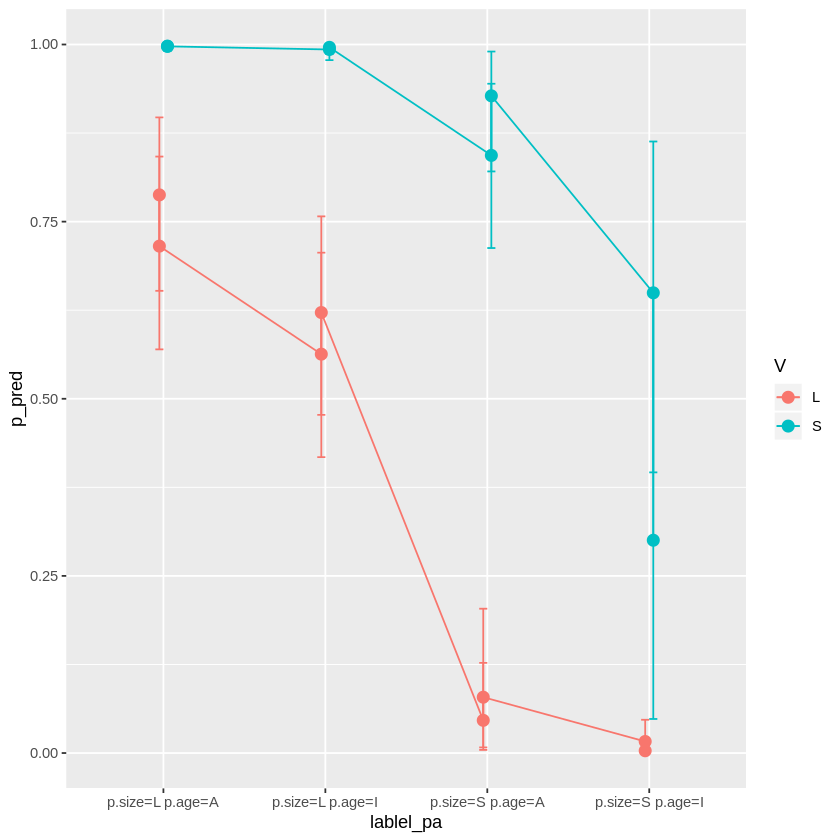

In [215]:
#From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9

pd <- position_dodge(0.1) # move points .05 to the left and right
# check influence of the pirate is large varibale on the probability (join by to other variables)
dr$lablel_av <- paste0('v.size=',dr$V,' ','p.age=',dr$A)
ggplot(dr, aes(x=lablel_av, y=p_pred, color=P, group=P)) + 
  geom_point(size=3, position=pd) +
  geom_line( position=pd) + 
  geom_errorbar(aes(ymin=p_pred_low, ymax=p_pred_high), width=.1, position=pd)

# check influence of the pirate is adult varibale on the probability (join by to other variables)
dr$lablel_pv <- paste0('p.size=',dr$P,' ','v.size=',dr$V)
ggplot(dr, aes(x=lablel_pv, y=p_pred, color=A, group=A)) + 
  geom_point(size=3, position=pd) + 
  geom_line( position=pd) +
  geom_errorbar(aes(ymin=p_pred_low, ymax=p_pred_high), width=.1, position=pd)

# check influence of the victim is large varibale on the probability (join by to other variables)
dr$lablel_pa <- paste0('p.size=',dr$P,' ','p.age=',dr$A)
ggplot(dr, aes(x=lablel_pa, y=p_pred, color=V, group=V)) + 
  geom_point(size=3, position=pd) + 
  geom_line( position=pd) + 
  geom_errorbar(aes(ymin=p_pred_low, ymax=p_pred_high), width=.1, position=pd)



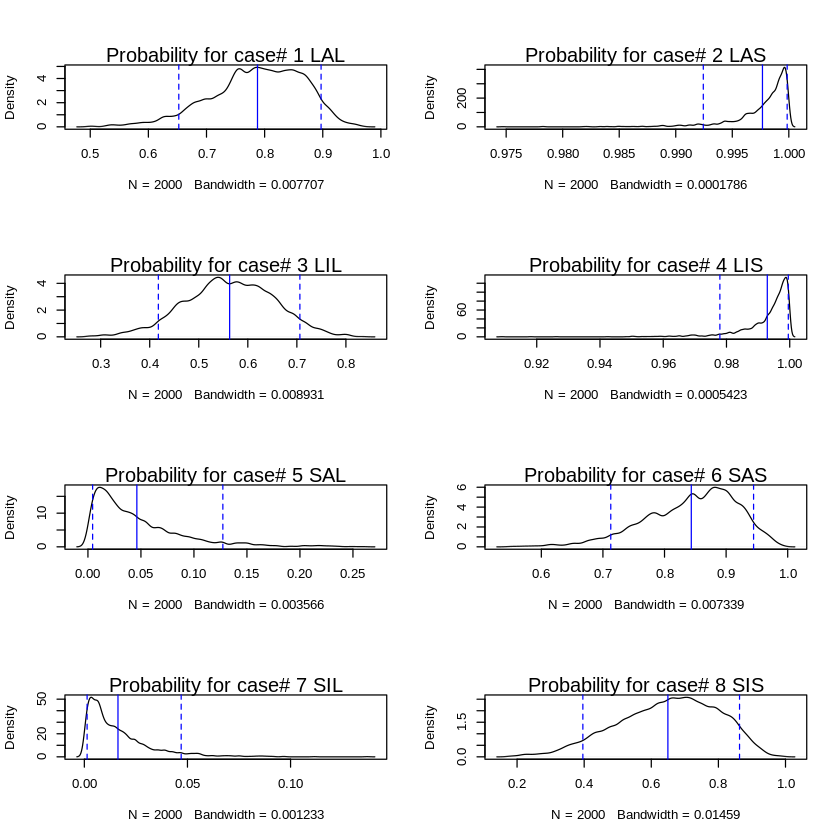

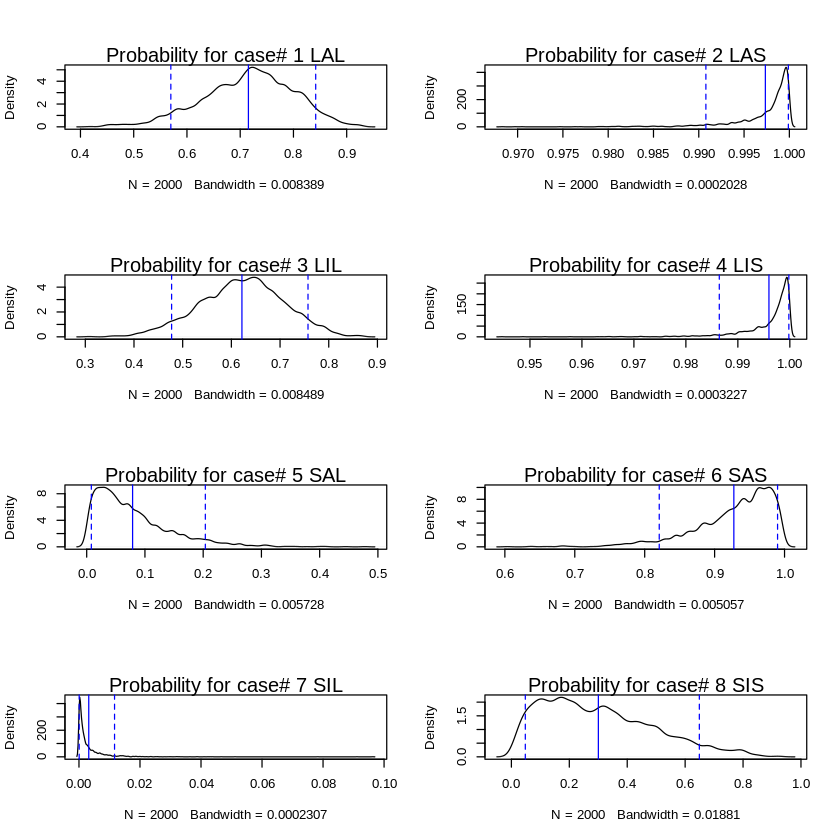

In [212]:
#From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9:

dr.base <- post_dens_probs(m10H3u, d)
dr.base$model = 'base'
dr.bpa <- post_dens_probs(m10H3uCond, d)
dr.bpa$model = 'bpa'

Finally, let's try the three way interaction model (ignoring 2-way interactions)

In [9]:
dat_slimB = list(y=d$y, n=d$n, Psize=d$Psize, Age=d$Age, Vsize=d$Vsize, condB=d$condB)

In [ ]:
#This seems to kill the Kernel for some reason...

# m10H3uCondB <- ulam(
#             alist(
#                 y ~ dbinom(n, p),
#                 logit(p) <- a + bP[Psize] + bA[Age] + bV[Vsize] + bPAV[condB],
#                 a ~ dnorm(0,10),
# #                c(bP[Psize], bA[Age], bV[Vsize]) ~ dnorm(0,5)
#                 bP[Psize] ~ dnorm(0,5), 
#                 bA[Age] ~ dnorm(0,5),
#                 bV[Vsize] ~ dnorm(0,5),
#                 bPAV[cond] ~ dnorm(0,1)
#             ), data=dat_slimB, chains=4, cores=4 #, log_lik=TRUE
#         )

In [ ]:
# plot(precis(m10H3uCondB, depth=2))

In [ ]:
# pairs(m10H3uCondB@stanfit)

In [ ]:
# compare(m10H3u, m10H3uCond, m10H3uCondB, func=LOO)

In [ ]:
# kCondB <- LOOPk(m10H3uCondB)

In [ ]:
# #From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9:

# dr.3wayInt <- post_dens_probs(m10H3uCondB, d)
# dr.3wayInt = '3-way interaction'

In [22]:
data(salamanders)
d <- salamanders

In [9]:
cor(d$PCTCOVER, d$FORESTAGE)

[1] 0.62546

In [24]:
# d$C <- standardize(d$PCTCOVER)
#d$F <- standardize(d$FORESTAGE)
# cor(d$C, d$F)
precis(d)

mean         sd         5.5%       94.5%      histogram     
SITE      2.400000e+01  13.711309  3.5300000  44.470000 ▇▇▇▇▇▇▇▇▇▂    
SALAMAN   2.468085e+00   3.374141  0.0000000   9.940000 ▇▁▁▁▁▁▁▁▁▁▁▁▁ 
PCTCOVER  5.897872e+01  35.776777  2.5300000  92.000000 ▃▂▁▁▁▁▁▂▇▂    
FORESTAGE 1.688085e+02 193.513244  3.0000000 551.000000 ▇▂▁▁▁▁▁▁▁▁▁▁▁▁
F         3.248901e-17   1.000000 -0.8568329   1.975015 ▇▁▂▁▁▁▁▁

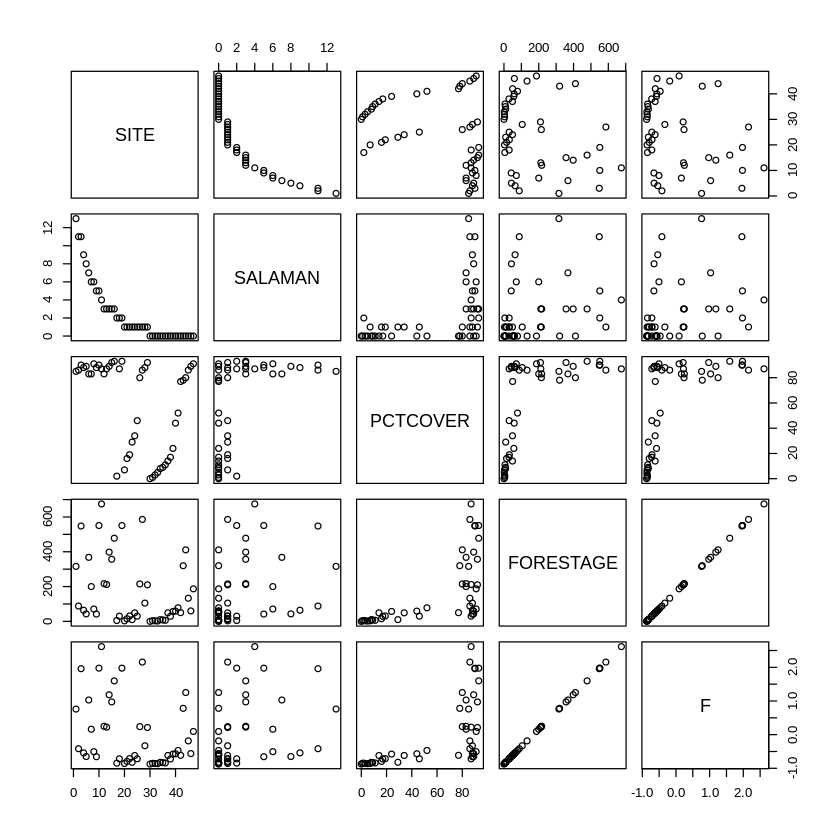

In [27]:
pairs(d)

Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”Warning message:
“Continuous x aesthetic -- did you forget aes(group=...)?”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


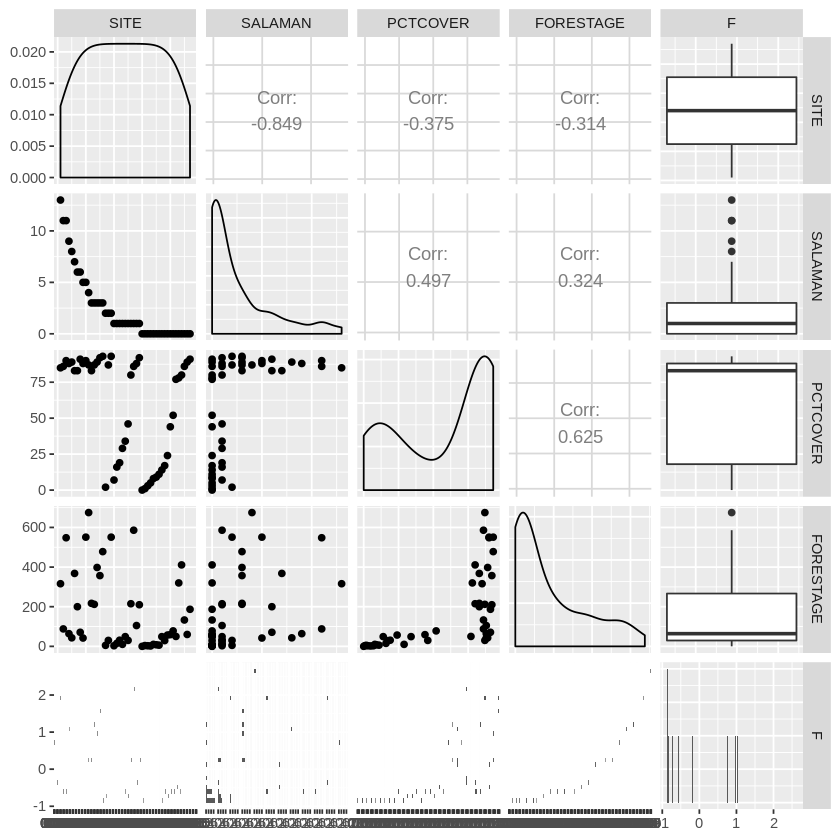

In [35]:
# install.packages("GGally")
library(ggplot2)
library(GGally)
ggpairs(d)

Question - is it better to use the standardized data, or stick with the original data in this model?

0 is an important number in all variables - the absence of something.  This suggests standardizing may not be appropriate, as it removes the clear boundary of 0.  Also note that PCTCOVER is bounded between 0 and 100.

But as we are using a log link function, log(lamda) = a + b * predictor(s), if predictor was 0, then lambda = exp(a).  If this should correspond to a count of 0 (i.e. no cover, young forest), then lambda ~ 0 and a << 0 (a large negative number).  So what...?

Cannot standardize lam (or log(lam)) or SALAMAN because this is a (discrete random variable) count model using Poisson distribution.  Should not restrict lam.

Standardizing shouldn't have an effect on inference, just on the interpretation of the parameters.  E.g. a 1 standard deviation increase FORESTAGE == a unit increase of F, leads to an bF change in log(lam)...

Let's establish a prior for a (although I have been naughty - taking a sneak look at the max number of salamancas, which is 13).

[1] 3.100108

[1] 20.87293

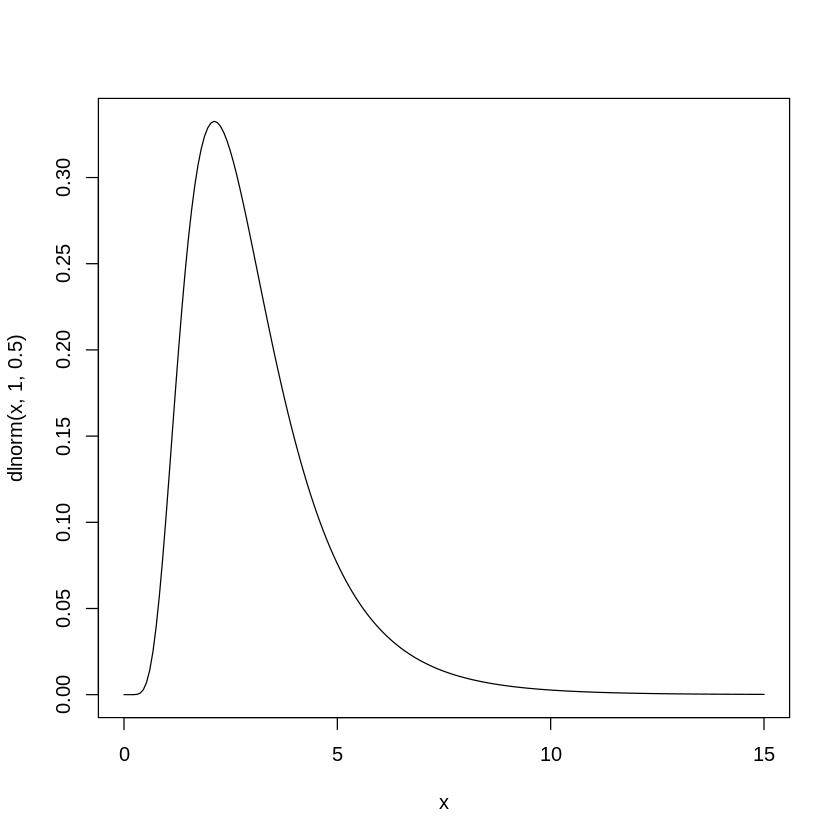

In [63]:
a <- rnorm(1e4,1,0.5)
lambda <- exp(a)
(mean( lambda ))
(max( lambda ))
curve( dlnorm( x , 1 , 0.5 ) , from=0 , to=15 , n=200 )

Now for bC.  Given PCTCOVER could range from 0 to 100, while SALAMANC ranges from 0 to 13, it's unlikely that s.d. of a normally distributed bC could be more than about 0.1 (or even smaller).  But the question asks for only "weakly informative priors".

As PCTCOVER covers range from 0 to 100, this necessarily makes bC very small.  Therefore we will use instead a new variable C = PCTCOVER / 100, i.e. it is bounded from 0 to 1.

In [203]:
d$C <- d$PCTCOVER / 100
d$F <- d$FORESTAGE / max(d$FORESTAGE)

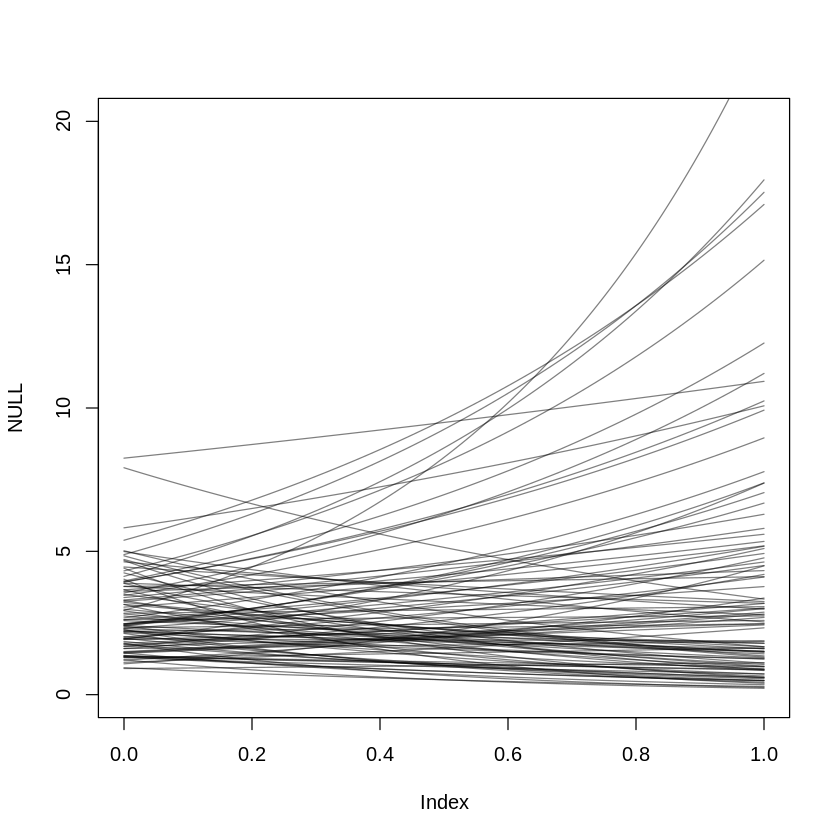

In [91]:
set.seed(10)
N <- 1e2
a <- rnorm( N , 1 , 0.5 )
b <- rnorm( N , 0 , 1 )
plot( NULL , xlim=c(0,1) , ylim=c(0,20) )
for ( i in 1:N ) curve( exp( a[i] + b[i]*x ) , add=TRUE , col=col.alpha("black",0.5) )

In [93]:
m10H4q <- quap(
            alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bC * C,
                    a ~ dnorm(1, 0.5),
                    bC ~ dnorm(0, 1)            
                ),
                data = d
            )

precis(m10H4q)

mean       sd        5.5%       94.5%     
a  -0.4143225 0.2471839 -0.8093702 -0.0192748
bC  1.9714279 0.3080347  1.4791290  2.4637268

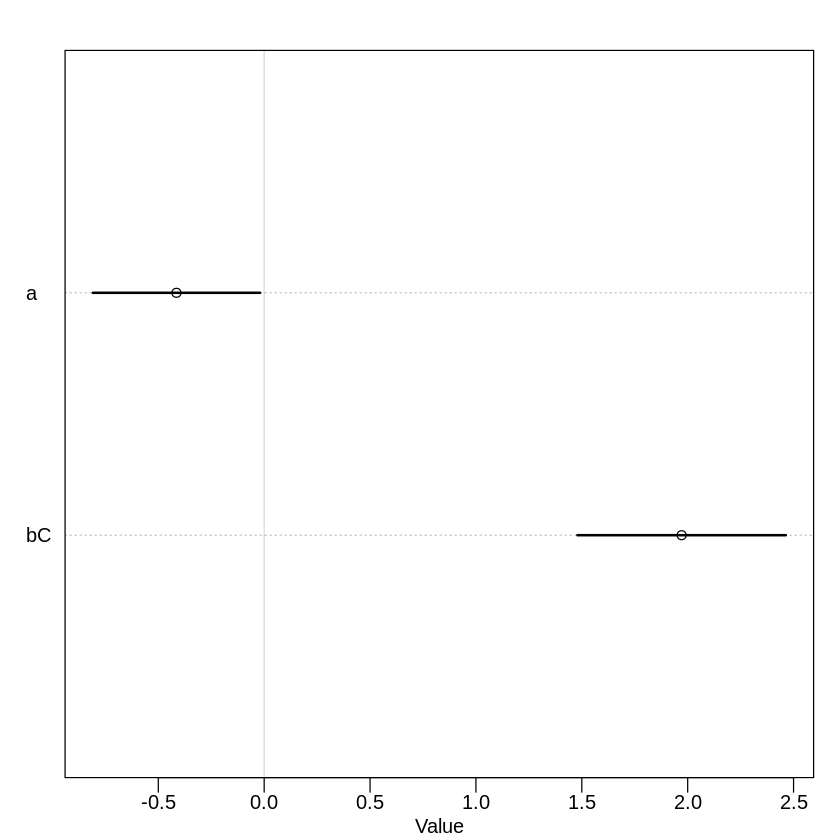

In [107]:
plot(precis(m10H4q))

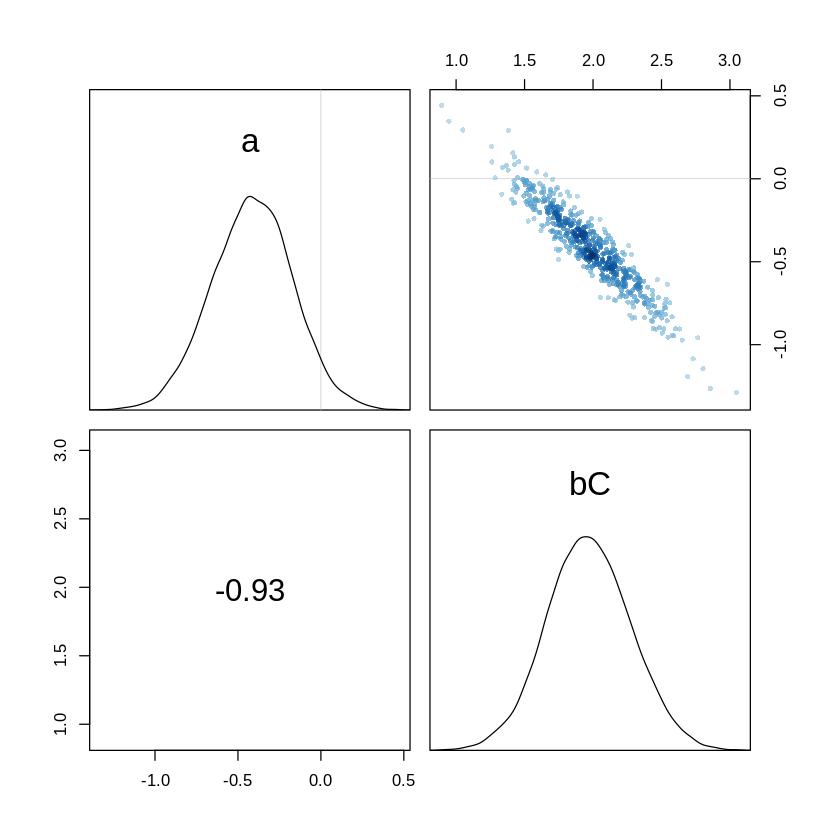

In [110]:
pairs(m10H4q)

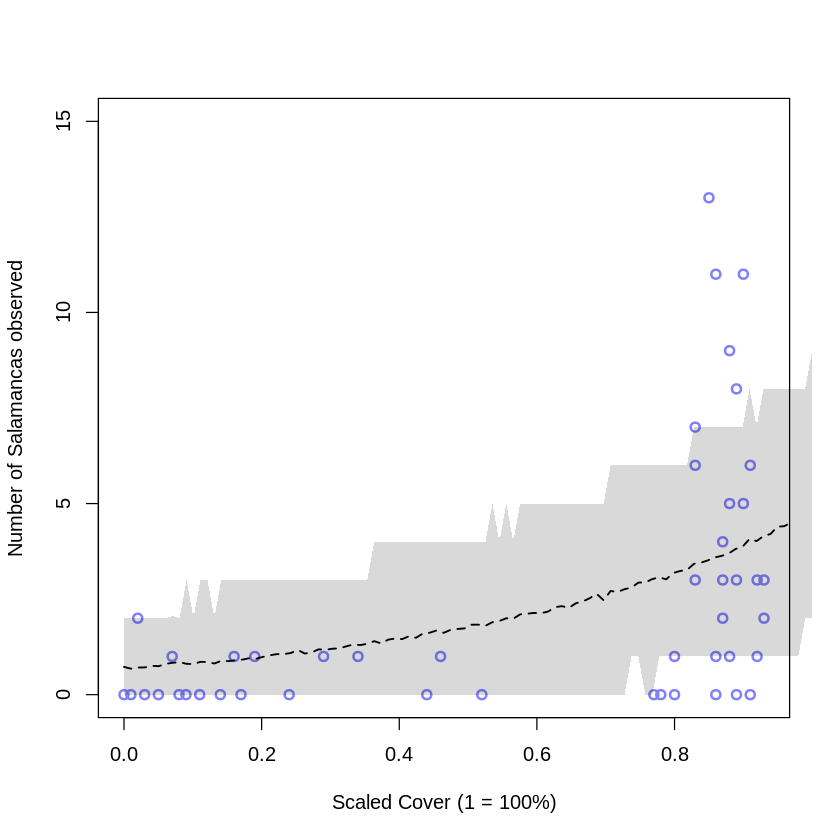

In [96]:
plot(d$C, d$SALAMAN, xlab="Scaled Cover (1 = 100%)", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
C_seq <- seq( from=0 , to=1 , length.out=ns )

#Predictions
counts <- sim( m10H4q, data=data.frame( C=C_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(C_seq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , C_seq , xpd=TRUE )

The data seems to contain a non-linear threshold type relationship.  However, the mean of our counts exhibits (as expected) a smooth exponentially increasing type relationship.

Now let's try ulam.

In [97]:
dat_slim = list(SALAMAN=d$SALAMAN, C=d$C)

In [103]:
m10H4u <- ulam(
            alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bC * C,
                    a ~ dnorm(1, 0.5),
                    bC ~ dnorm(0, 1)            
                ),
                data = dat_slim, chains=4, cores=4
                , control=list(adapt_delta=0.99, max_treedepth=20)
            )

precis(m10H4u)

recompiling to avoid crashing R session


mean       sd        5.5%      94.5%       n_eff    Rhat    
a  -0.4412808 0.2349485 -0.811775 -0.06994398 422.3381 1.003044
bC  1.9960621 0.2919553  1.526794  2.45149468 432.5674 1.002783

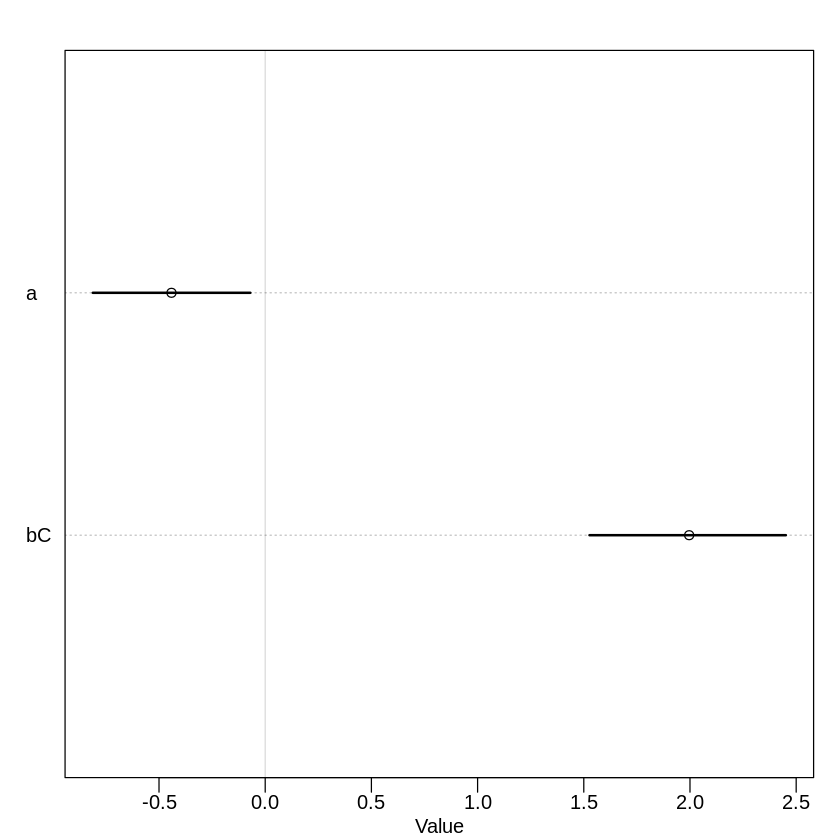

In [109]:
plot(precis(m10H4u))

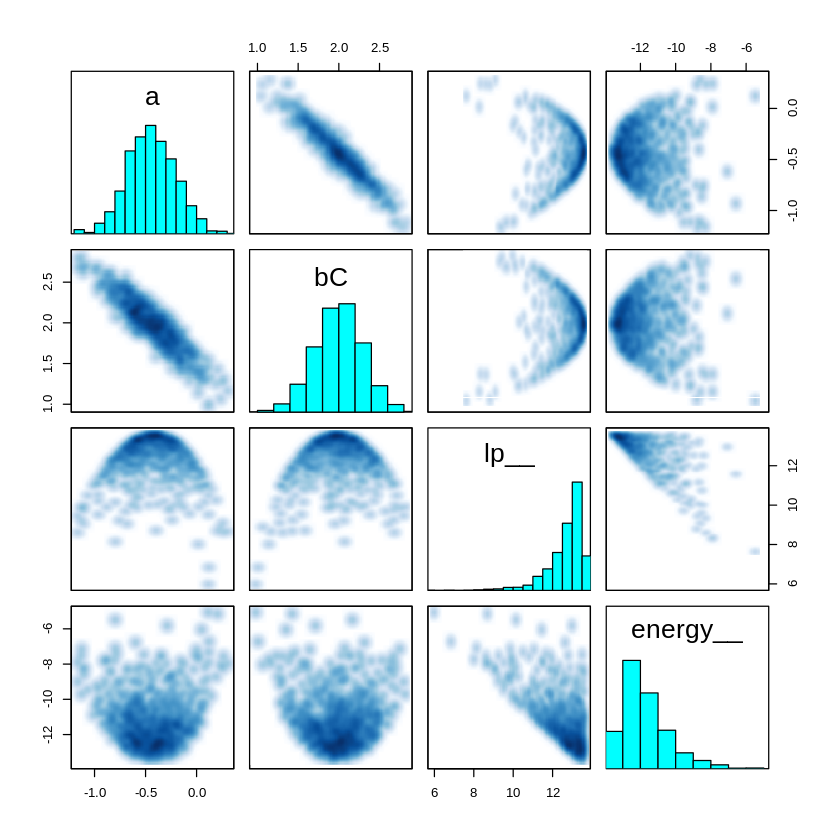

In [104]:
pairs(m10H4u@stanfit)

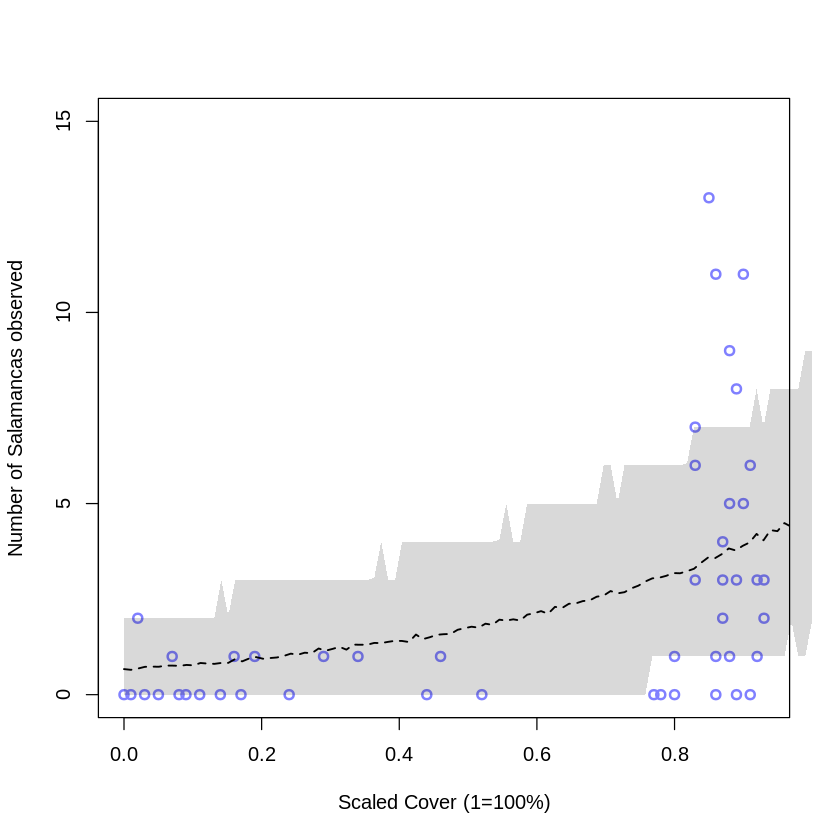

In [106]:
plot(d$C, d$SALAMAN, xlab="Scaled Cover (1=100%)", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
C_seq <- seq( from=0 , to=1 , length.out=ns )

#Predictions
counts <- sim_ulam( m10H4u, data=data.frame( C=C_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(C_seq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , C_seq , xpd=TRUE )

Both quap and ulam seem to produce very similar outcomes.  The ulam procedure seems to struggle a bit though, look at the number of effective samples!  That's why I had to increase the max_treedepth.

Note in both estimates that a and bC are highly correlated.  This may be causing issues in the ulam convergence.

I wonder if we can improve the regression by using the standardized(log(PCTCOVER)) as a predictor, given that the data looks either like some sort of non-linear threshold model or perhaps a (super?) exponential curve on the linear PCTCOVER scale?  This should help to anchor the intercept 'a' so that it isn't correlated with bC.  There's a problem though in that one data point is 0.  So log(0) is -inf, which messes up the standardized log(PCTCOVER).  So we need to replace it.  Let's try this model:

In [152]:
d$PCTCOVERnew <- ifelse(d$PCTCOVER == 0, 0.1, d$PCTCOVER)
d$logPCTCstd <- standardize(log(d$PCTCOVERnew))
head(d)

SITE SALAMAN PCTCOVER FORESTAGE F          C    logPctCover PCTCOVERnew
1 1    13      85       316        0.7606275 0.85 0.5995594   85         
2 2    11      86        88       -0.4175865 0.86 0.6075382   86         
3 3    11      90       548        1.9595118 0.90 0.6385516   90         
4 4     9      88        64       -0.5416090 0.88 0.6232211   88         
5 5     8      89        43       -0.6501287 0.89 0.6309294   89         
6 6     7      83       368        1.0293429 0.83 0.5833163   83         
  logPCTCstd
1 0.5995594 
2 0.6075382 
3 0.6385516 
4 0.6232211 
5 0.6309294 
6 0.5833163

As logPCTCstd has a range of around -2 to 2, and SALAMAN (and thus lam) has a range of 0 to 13, such that log(lam) has a range of something negative up to around 3, after a bit of playing around, let's say that bLPC ~ dnorm(1, 0.5).  See below for experiment:

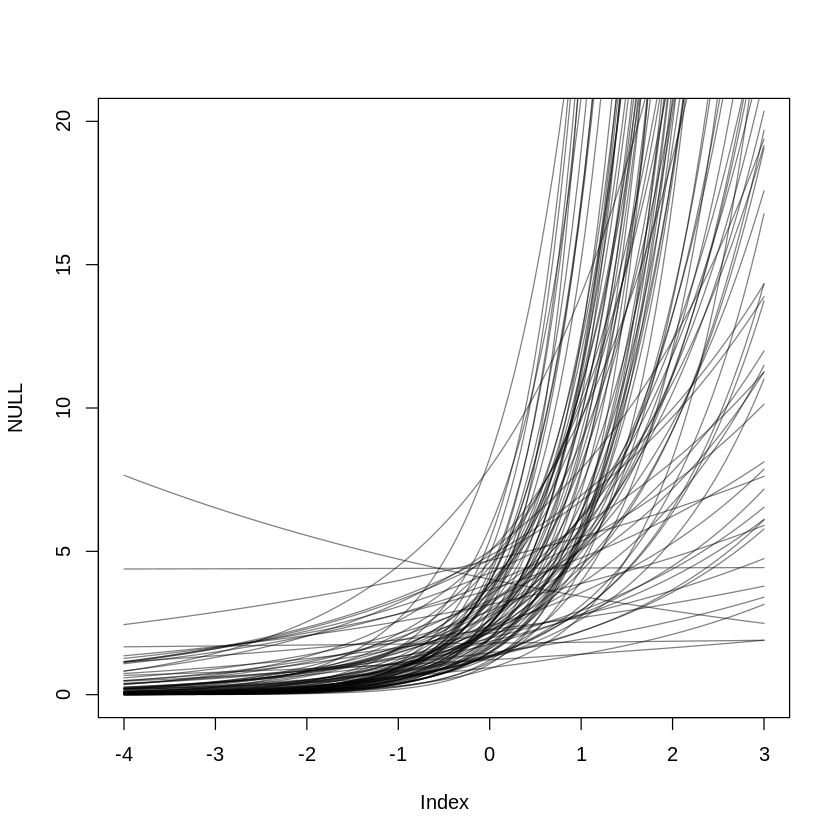

In [166]:
set.seed(10)
N <- 1e2
a <- rnorm( N , 1 , 0.5 )
b <- rnorm( N , 1 , 0.5 )
plot( NULL , xlim=c(-4,3) , ylim=c(0,20) )
for ( i in 1:N ) curve( exp( a[i] + b[i]*x ) , add=TRUE , col=col.alpha("black",0.5) )

In [161]:
m10H4qB <- quap(
                alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bLPC * logPCTCstd,
                    a ~ dnorm(1,0.5),
                    bLPC ~ dnorm(1, 0.5)
                ), data=d
           )

precis(m10H4qB)

mean      sd        5.5%      94.5%    
a    0.4640601 0.1448083 0.2326284 0.6954918
bLPC 1.3563484 0.2323696 0.9849769 1.7277199

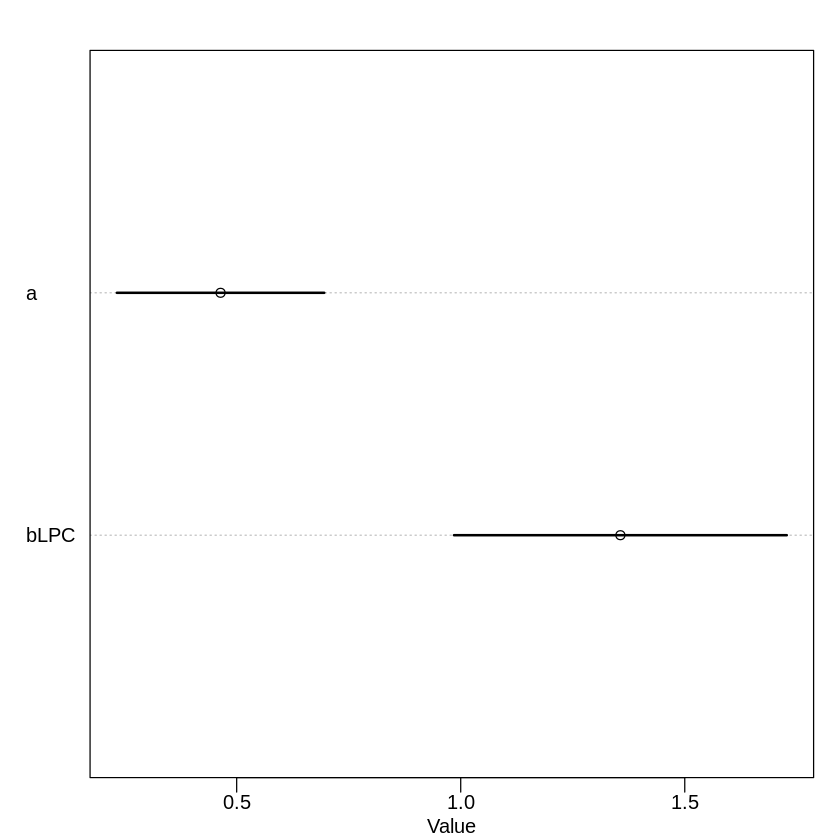

In [162]:
plot(precis(m10H4qB))

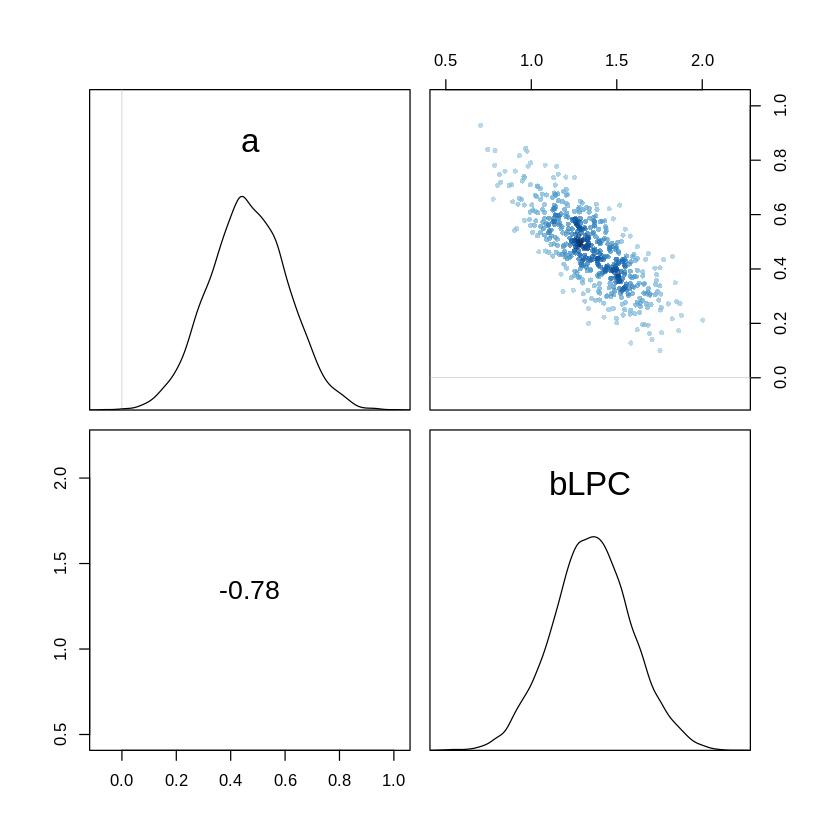

In [163]:
pairs(m10H4qB)

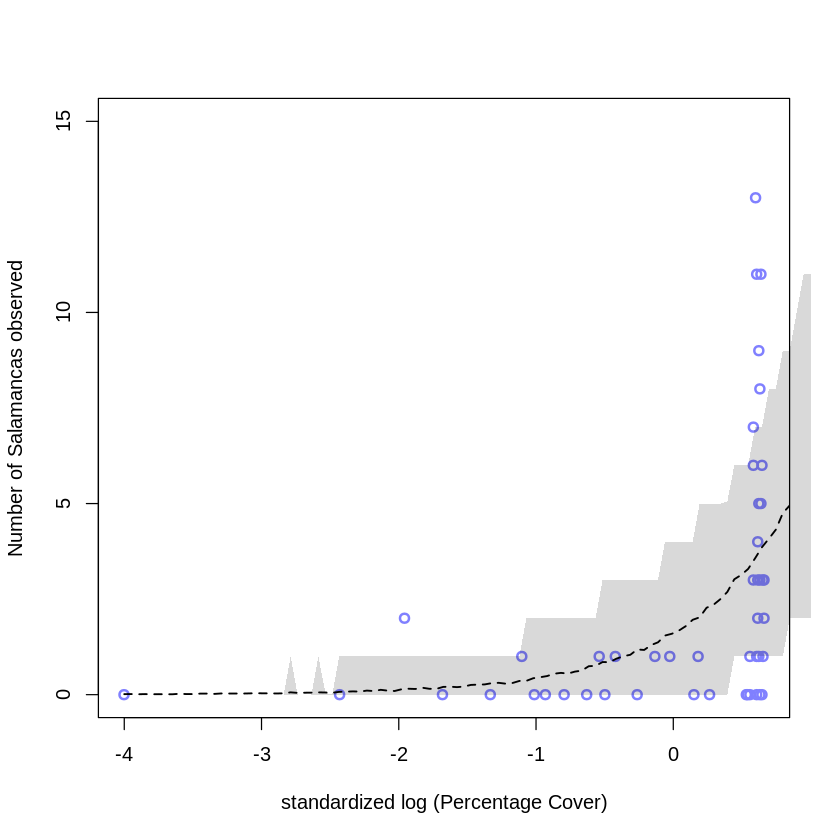

In [164]:
plot(d$logPCTCstd, d$SALAMAN, xlab="standardized log (Percentage Cover)", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
lC_seq <- seq( from=-4 , to=1 , length.out=ns )

#Predictions
counts <- sim( m10H4qB, data=data.frame( logPCTCstd=lC_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(lC_seq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , lC_seq , xpd=TRUE )

In [155]:
d

SITE SALAMAN PCTCOVER FORESTAGE F           C    logPctCover PCTCOVERnew
1   1   13      85       316        0.76062747 0.85  0.59955942 85.0       
2   2   11      86        88       -0.41758646 0.86  0.60753818 86.0       
3   3   11      90       548        1.95951182 0.90  0.63855156 90.0       
4   4    9      88        64       -0.54160898 0.88  0.62322110 88.0       
5   5    8      89        43       -0.65012868 0.89  0.63092940 89.0       
6   6    7      83       368        1.02934293 0.83  0.58331634 83.0       
7   7    6      83       200        0.16118530 0.83  0.58331634 83.0       
8   8    6      91        71       -0.50543575 0.91  0.64608950 91.0       
9   9    5      88        42       -0.65529629 0.88  0.62322110 88.0       
10 10    5      90       551        1.97501464 0.90  0.63855156 90.0       
11 11    4      87       675        2.61579765 0.87  0.61542471 87.0       
12 12    3      83       217        0.24903458 0.83  0.58331634 83.0       
13 13    3      87       212        0.22319655 0.87  0.61542471 87.0       
14 14    3      89       398        1.18437108 0.89  0.63092940 89.0       
15 15    3      92       357        0.97249927 0.92  0.65354506 92.0       
16 16    3      93       478        1.59777948 0.93  0.66092002 93.0       
17 17    2       2         5       -0.84649767 0.02 -1.95826535  2.0       
18 18    2      87        30       -0.71730755 0.87  0.61542471 87.0       
19 19    2      93       551        1.97501464 0.93  0.66092002 93.0       
20 20    1       7         3       -0.85683288 0.07 -1.10365949  7.0       
21 21    1      16        15       -0.79482162 0.16 -0.53971853 16.0       
22 22    1      19        31       -0.71213994 0.19 -0.42248627 19.0       
23 23    1      29        10       -0.82065965 0.29 -0.13402313 29.0       
24 24    1      34        49       -0.61912305 0.34 -0.02551288 34.0       
25 25    1      46        30       -0.71730755 0.46  0.18069612 46.0       
26 26    1      80       215        0.23869937 0.80  0.55820271 80.0       
27 27    1      86       586        2.15588081 0.86  0.60753818 86.0       
28 28    1      88       105       -0.32973718 0.88  0.62322110 88.0       
29 29    1      92       210        0.21286134 0.92  0.65354506 92.0       
30 30    0       0         0       -0.87233570 0.00 -4.00188447  0.1       
31 31    0       1         4       -0.85166528 0.01 -2.43111429  1.0       
32 32    0       3         3       -0.85683288 0.03 -1.68166645  3.0       
33 33    0       5         2       -0.86200049 0.05 -1.33319305  5.0       
34 34    0       8        10       -0.82065965 0.08 -1.01256747  8.0       
35 35    0       9         8       -0.83099486 0.09 -0.93221862  9.0       
36 36    0      11         6       -0.84133007 0.11 -0.79532572 11.0       
37 37    0      14        49       -0.61912305 0.14 -0.63081055 14.0       
38 38    0      17        29       -0.72247515 0.17 -0.49836182 17.0       
39 39    0      24        57       -0.57778221 0.24 -0.26311963 24.0       
40 40    0      44        59       -0.56744700 0.44  0.15037216 44.0       
41 41    0      52        78       -0.46926251 0.52  0.26433259 52.0       
42 42    0      77        50       -0.61395545 0.77  0.53212908 77.0       
43 43    0      78       320        0.78129789 0.78  0.54093148 78.0       
44 44    0      80       411        1.25154994 0.80  0.55820271 80.0       
45 45    0      86       133       -0.18504424 0.86  0.60753818 86.0       
46 46    0      89        60       -0.56227940 0.89  0.63092940 89.0       
47 47    0      91       187        0.09400643 0.91  0.64608950 91.0       
   logPCTCstd 
1   0.59955942
2   0.60753818
3   0.63855156
4   0.62322110
5   0.63092940
6   0.58331634
7   0.58331634
8   0.64608950
9   0.62322110
10  0.63855156
11  0.61542471
12  0.58331634
13  0.61542471
14  0.63092940
15  0.65354506
16  0.66092002
17 -1.95826535
18  0.61542471
19  0.66092002
20 -1.10365949
21 -0.53971853
22 -0.42248627
23 -0.1340

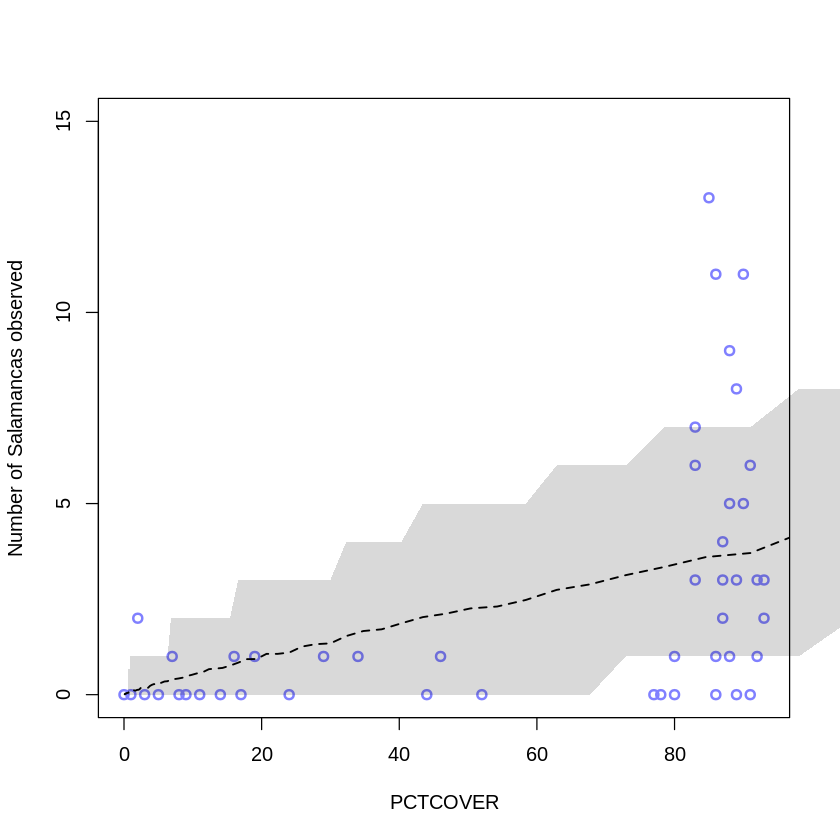

In [165]:
plot(d$PCTCOVER, d$SALAMAN, xlab="PCTCOVER", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
lC_seq <- seq( from=-4 , to=1 , length.out=ns )
PCTCOVseq <- exp(lC_seq*sd(log(d$PCTCOVERnew))+mean(log(d$PCTCOVERnew)))

#Predictions
counts <- sim( m10H4qB, data=data.frame( logPCTCstd=lC_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(PCTCOVseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , PCTCOVseq , xpd=TRUE )

What about trying to use the exp(PCTCOVER) as a predictor, because it almost looks like PCTCOVER is on a log scale already?  We try below:

In [176]:
d$expCOVERstd <- standardize(exp(d$PCTCOVER/100))

In [177]:
m10H4qC <- quap(
                alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bLPC * expCOVERstd,
                    a ~ dnorm(1,0.5),
                    bLPC ~ dnorm(1, 0.5)
                ), data=d
           )

precis(m10H4qC)

mean      sd       5.5%      94.5%    
a    0.5001535 0.135759 0.2831843 0.7171226
bLPC 1.0604802 0.157493 0.8087759 1.3121844

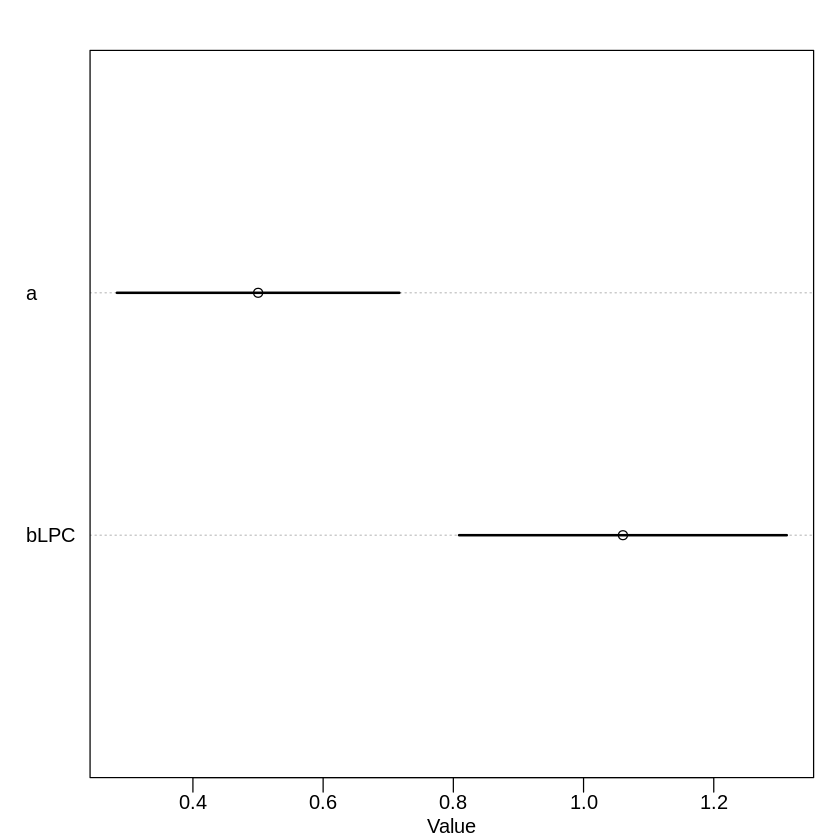

In [179]:
plot(precis(m10H4qC))

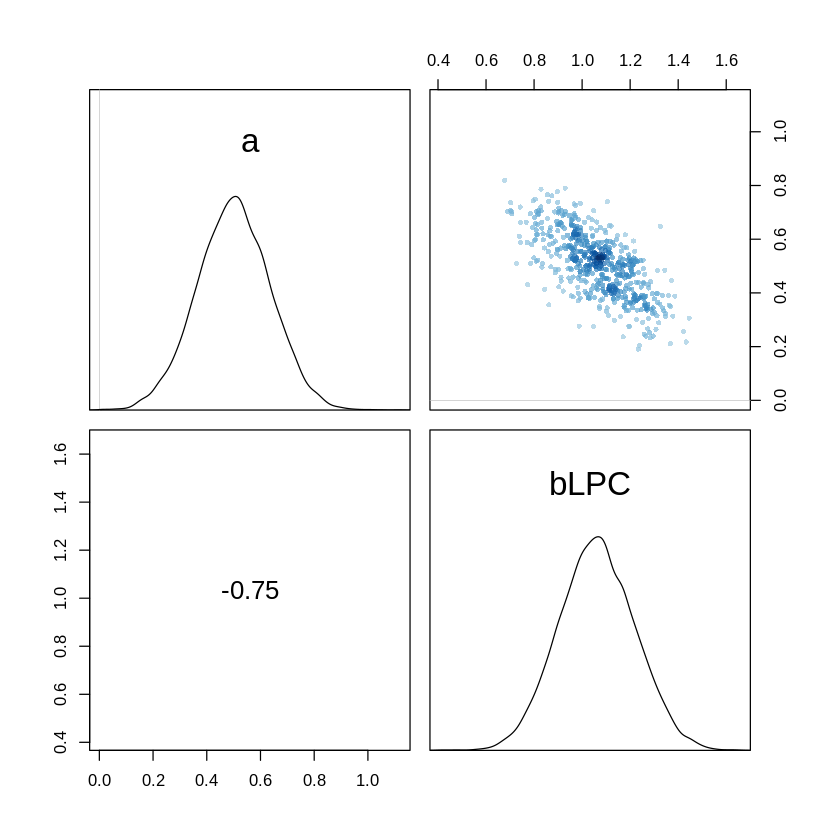

In [181]:
pairs(m10H4qC)

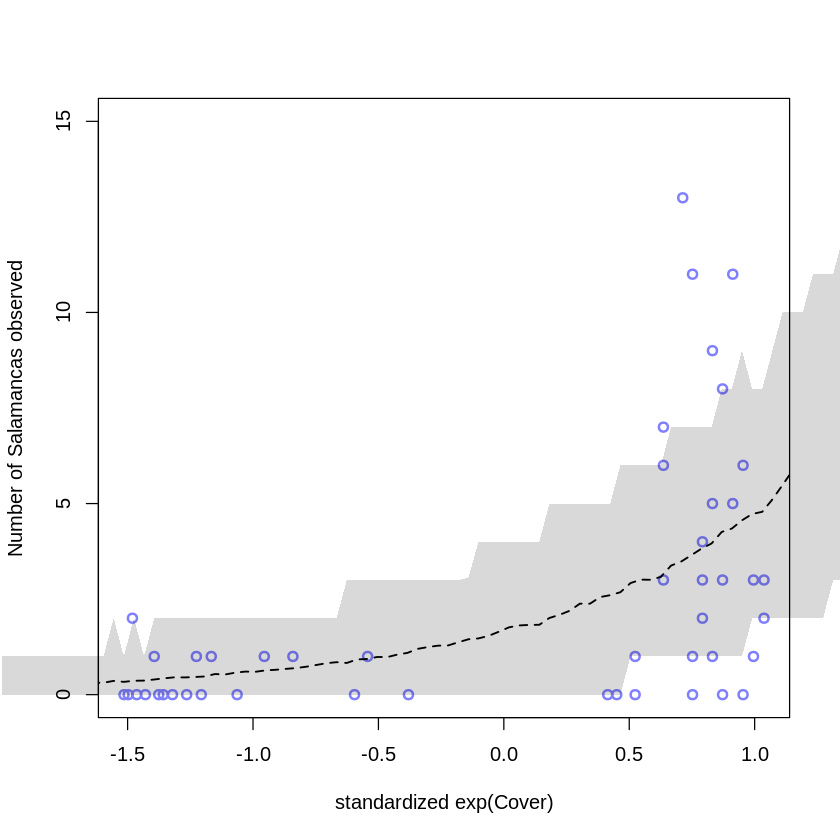

In [182]:
plot(d$expCOVERstd, d$SALAMAN, xlab="standardized exp(Cover)", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
eC_seq <- seq( from=-2 , to=2 , length.out=ns )

#Predictions
counts <- sim( m10H4qC, data=data.frame( expCOVERstd=eC_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(eC_seq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , eC_seq , xpd=TRUE )

[1] -34.53614766 -31.16163373 -27.89728579 -24.73613759 -21.67186346
  [6] -18.69870207 -15.81139123 -13.00511186 -10.27543962  -7.61830288
 [11]  -5.02994626  -2.50689867  -0.04594531   2.35589692   4.70140119
 [16]   6.99314999   9.23355221  11.42485834  13.56917411  15.66847260
 [21]  17.72460518  19.73931130  21.71422734  23.65089462  25.55076657
 [26]  27.41521533  29.24553770  31.04296054  32.80864570  34.54369459
 [31]  36.24915222  37.92601105  39.57521444  41.19765980  42.79420159
 [36]  44.36565395  45.91279327  47.43636042  48.93706292  50.41557692
 [41]  51.87254899  53.30859786  54.72431599  56.12027101  57.49700710
 [46]  58.85504628  60.19488959  61.51701819  62.82189439  64.10996267
 [51]  65.38165051  66.63736932  67.87751518  69.10246963  70.31260035
 [56]  71.50826182  72.68979598  73.85753277  75.01179071  76.15287743
 [61]  77.28109012  78.39671605  79.50003296  80.59130951  81.67080566
 [66]  82.73877303  83.79545527  84.84108839  85.87590107  86.90011496
 [71]  87.91394497  88.91759955  89.91128091  90.89518532  91.86950330
 [76]  92.83441985  93.79011466  94.73676235  95.67453259  96.60359034
 [81]  97.52409600  98.43620559  99.34007087 100.23583956 101.12365541
 [86] 102.00365841 102.87598487 103.74076754 104.59813580 105.44821570
 [91] 106.29113011 107.12699882 107.95593864 108.77806351 109.59348455
 [96] 110.40231023 111.20464637 112.00059628 112.79026083 113.57373850

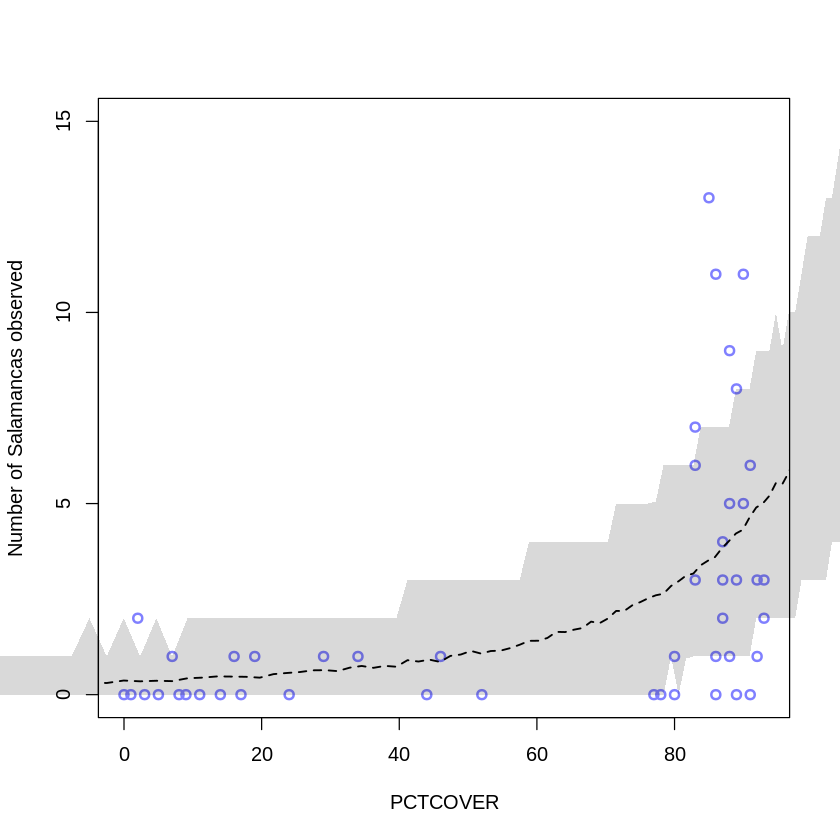

In [192]:
plot(d$PCTCOVER, d$SALAMAN, xlab="PCTCOVER", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
eC_seq <- seq( from=-2 , to=2 , length.out=ns )
PCTCOVseq <- 100*log(eC_seq*sd(exp(d$PCTCOVER/100))+mean(exp(d$PCTCOVER/100)))

#Predictions
counts <- sim( m10H4qC, data=data.frame( expCOVERstd=eC_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(PCTCOVseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , PCTCOVseq , xpd=TRUE )

In [195]:
m10H4uC <- ulam(
                alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bLPC * expCOVERstd,
                    a ~ dnorm(1,0.5),
                    bLPC ~ dnorm(1, 0.5)
                ), data=d, chains=4, cores=4
           )

precis(m10H4uC)

recompiling to avoid crashing R session


mean      sd        5.5%      94.5%     n_eff    Rhat    
a    0.4852835 0.1390314 0.2562214 0.6911787 622.9610 1.005138
bLPC 1.0764115 0.1585693 0.8424062 1.3402743 557.6233 1.006024

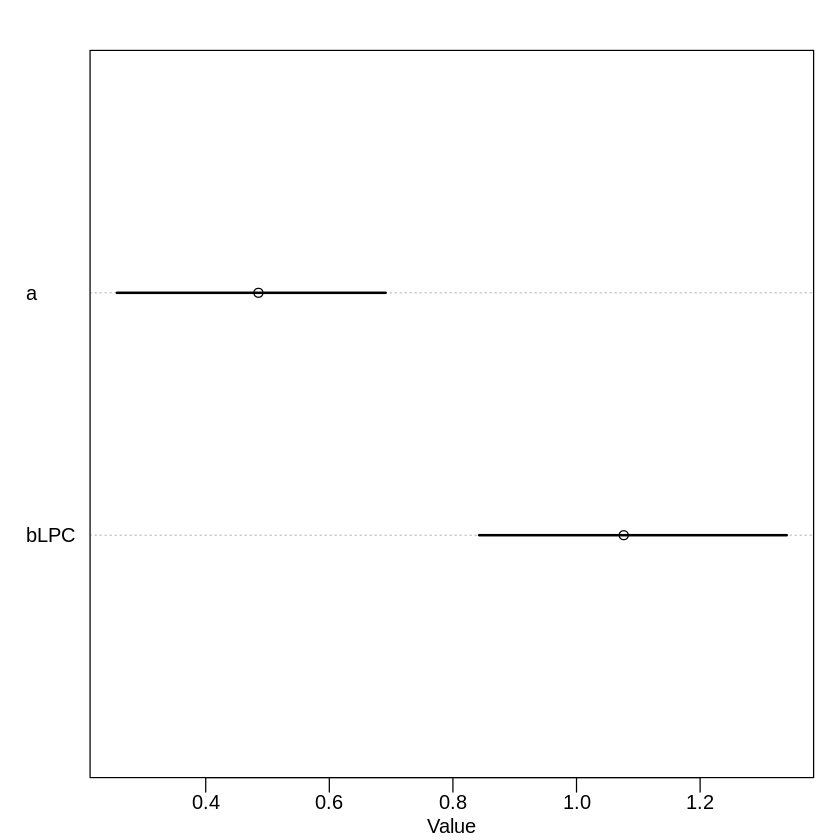

In [196]:
plot(precis(m10H4uC))

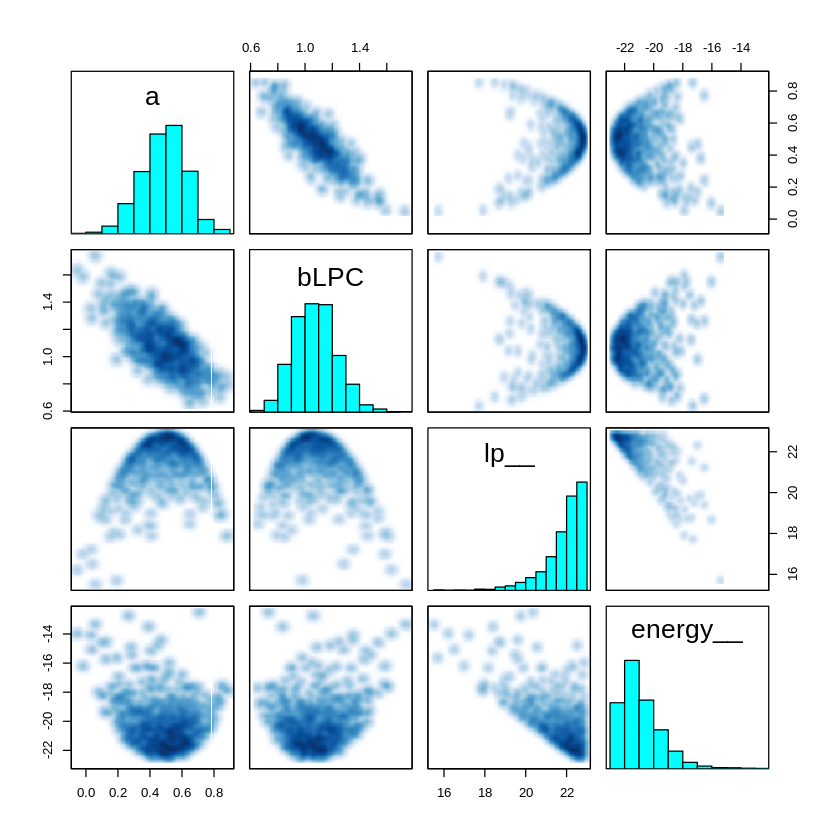

In [219]:
pairs(m10H4uC@stanfit)

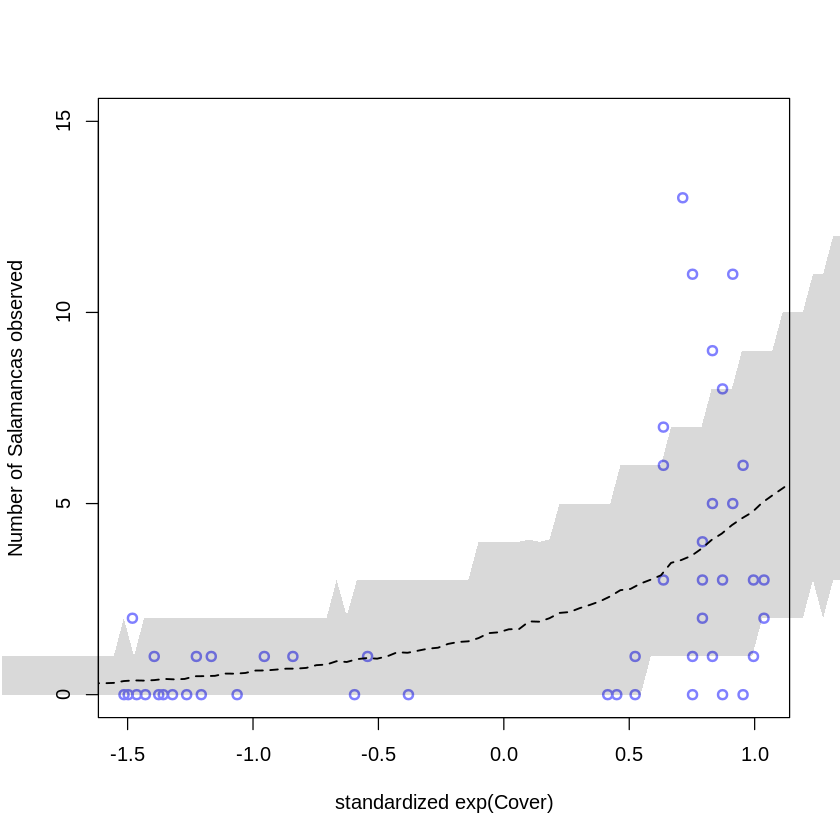

In [198]:
plot(d$expCOVERstd, d$SALAMAN, xlab="standardized exp(Cover)", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
eC_seq <- seq( from=-2 , to=2 , length.out=ns )

#Predictions
counts <- sim( m10H4uC, data=data.frame( expCOVERstd=eC_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(eC_seq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , eC_seq , xpd=TRUE )

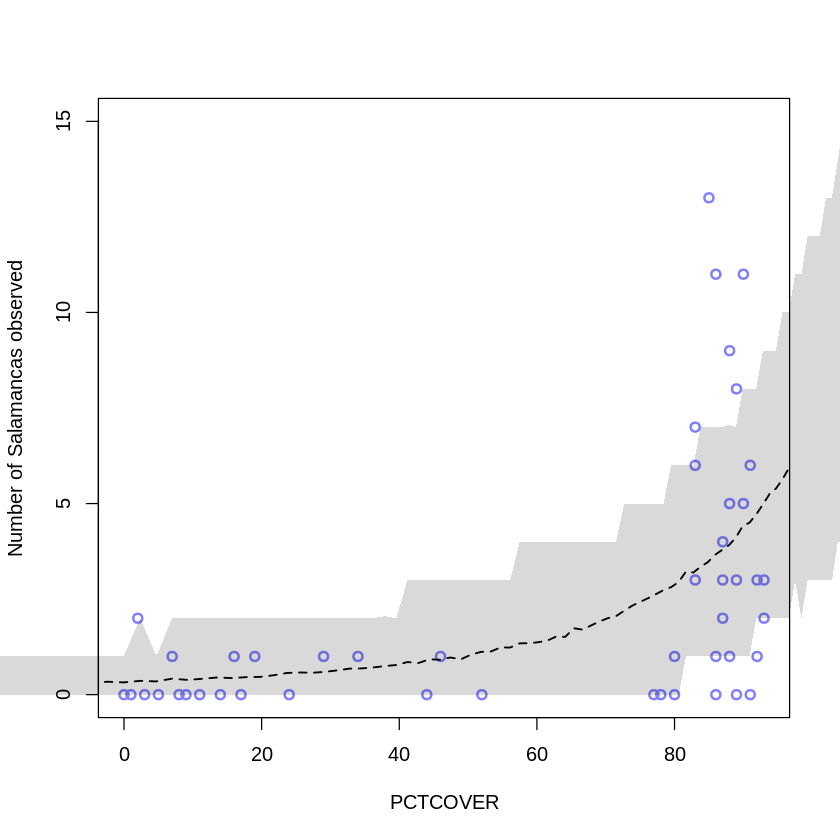

In [199]:
plot(d$PCTCOVER, d$SALAMAN, xlab="PCTCOVER", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
eC_seq <- seq( from=-2 , to=2 , length.out=ns )
PCTCOVseq <- 100*log(eC_seq*sd(exp(d$PCTCOVER/100))+mean(exp(d$PCTCOVER/100)))

#Predictions
counts <- sim( m10H4uC, data=data.frame( expCOVERstd=eC_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(PCTCOVseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , PCTCOVseq , xpd=TRUE )

In [208]:
precis(d)

mean          sd          5.5%         94.5%       histogram     
SITE         2.400000e+01  13.7113092  3.530000000  44.4700000 ▇▇▇▇▇▇▇▇▇▂    
SALAMAN      2.468085e+00   3.3741412  0.000000000   9.9400000 ▇▁▁▁▁▁▁▁▁▁▁▁▁ 
PCTCOVER     5.897872e+01  35.7767774  2.530000000  92.0000000 ▃▂▁▁▁▁▁▂▇▂    
FORESTAGE    1.688085e+02 193.5132439  3.000000000 551.0000000 ▇▂▁▁▁▁▁▁▁▁▁▁▁▁
F            2.500867e-01   0.2866863  0.004444444   0.8162963 ▇▂▁▁▁▁▁▁▁▁    
C            5.897872e-01   0.3577678  0.025300000   0.9200000 ▃▂▁▁▁▁▁▂▇▂    
logPctCover  5.405555e-17   1.0000000 -1.811667937   0.6535451 ▁▁▁▁▁▁▁▁▁▁▇   
PCTCOVERnew  5.898085e+01  35.7731964  2.530000000  92.0000000 ▃▂▁▁▁▁▁▂▇▂    
logPCTCstd   5.659766e-17   1.0000000 -1.811667937   0.6535451 ▁▁▁▁▁▁▁▁▁▁▇   
expPCTCOVER -8.283766e-18   1.0000000 -0.318092955   1.4050448 ▇▁▁▁▁▁▁▁▁▁    
expPCTCstd   1.369901e-16   1.0000000 -1.471759562   0.9953405 ▃▃▁▁▁▁▁▁▁▁▂▇▇▁
expCOVERstd  1.369901e-16   1.0000000 -1.471759562   0.9953405 ▃▃▁▁▁▁▁▁▁▁▂▇▇▁

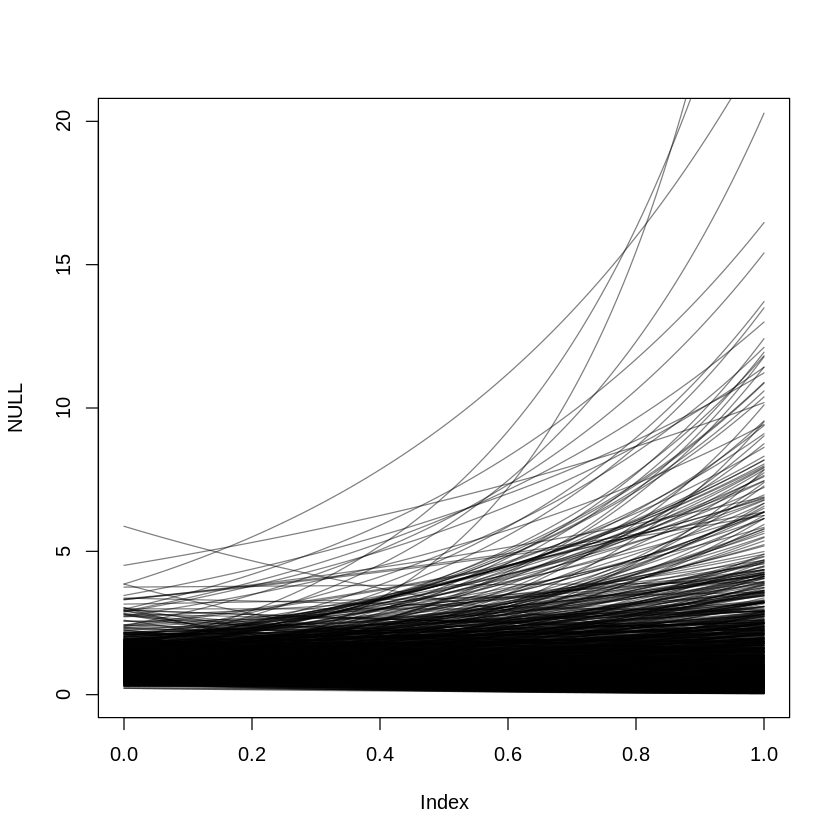

In [216]:
set.seed(10)
N <- 1e3
a <- rnorm( N , 0 , 0.5 )
b <- rnorm( N , 0 , 1 )
plot( NULL , xlim=c(0,1) , ylim=c(0,20) )
for ( i in 1:N ) curve( exp( a[i] + b[i]*x ) , add=TRUE , col=col.alpha("black",0.5) )

In [229]:
m10H4uD <- ulam(
                alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bC * C + bF * F,
                    a ~ dnorm(0, 0.5),
                    bC ~ dnorm(0, 1),
                    bF ~ dnorm(0, 1)
                ), data=d, chains=4, cores=4
           )

precis(m10H4uD)

recompiling to avoid crashing R session


mean       sd        5.5%       94.5%      n_eff     Rhat    
a  -0.6942549 0.2616764 -1.1231399 -0.2865865  688.3218 1.000414
bC  2.2302117 0.3588168  1.6748090  2.8202825  664.2149 1.000523
bF  0.1189011 0.3416168 -0.4486462  0.6442999 1003.9285 1.003684

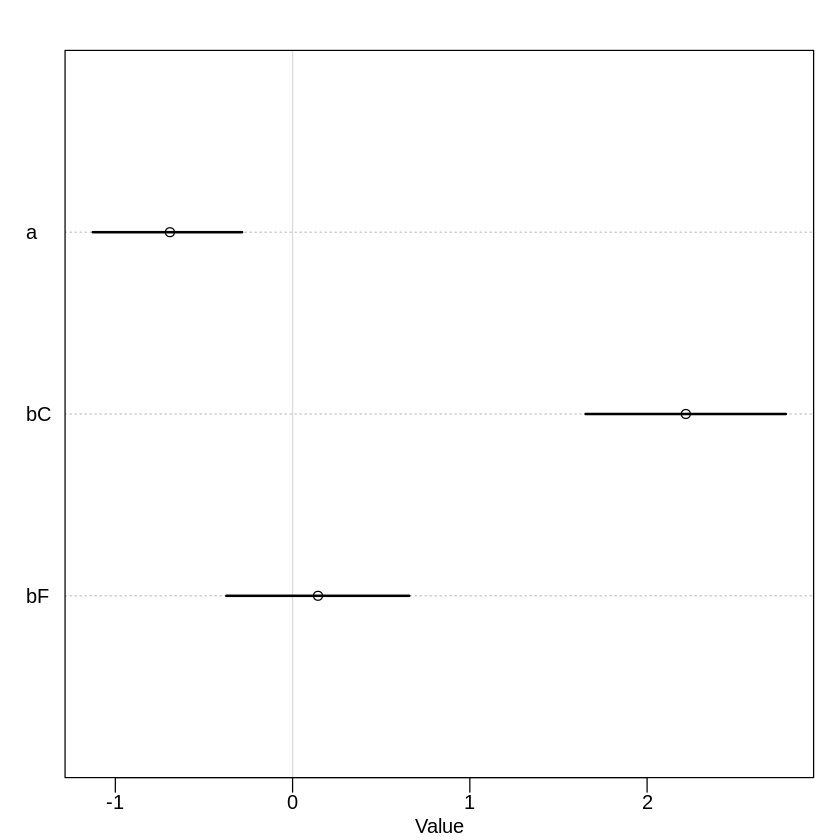

In [218]:
plot(precis(m10H4uD))

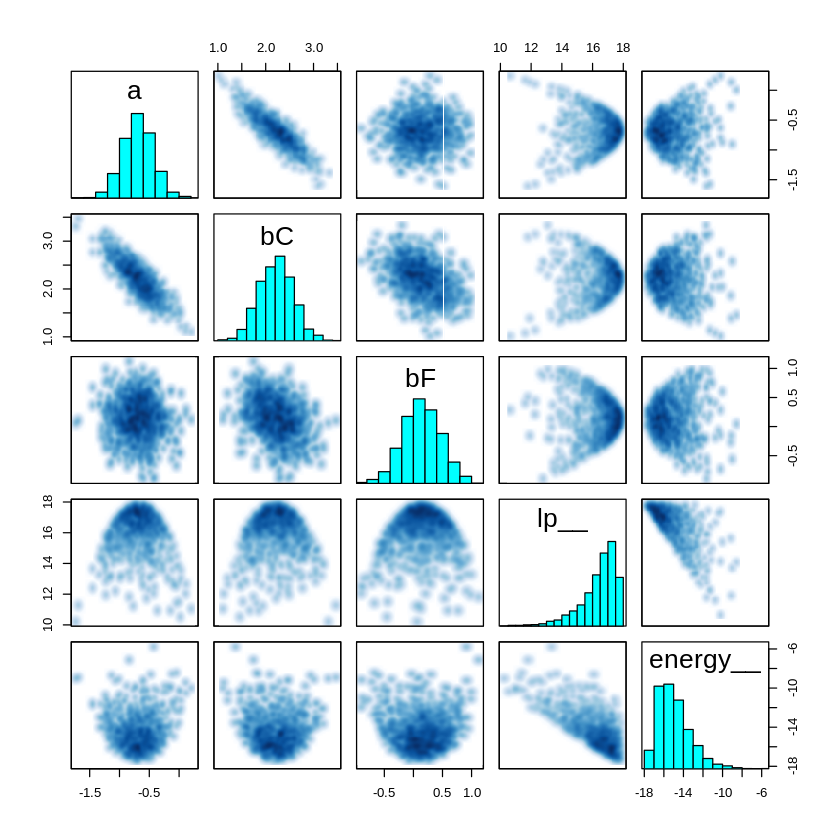

In [220]:
pairs(m10H4uD@stanfit)

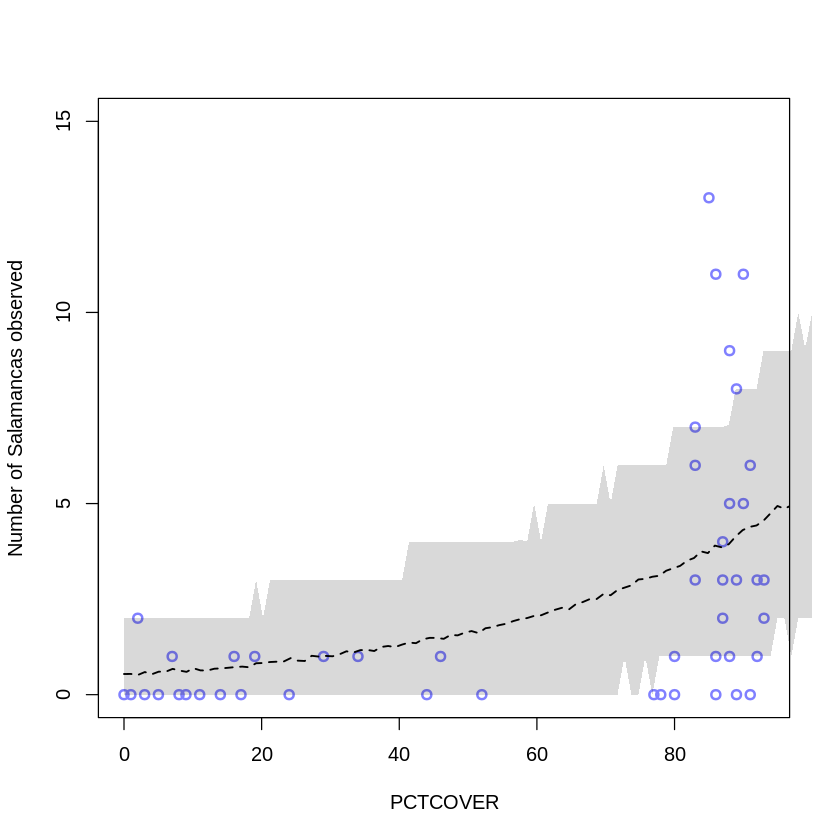

In [222]:
plot(d$PCTCOVER, d$SALAMAN, xlab="PCTCOVER", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
C_seq <- seq( from=0 , to=1 , length.out=ns )
PCTCOVseq <- 100*C_seq

#Predictions
counts <- sim( m10H4uD, data=data.frame( C=C_seq, F=C_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(PCTCOVseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , PCTCOVseq , xpd=TRUE )

In [224]:
m10H4uE <- ulam(
                alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bC * C + bF * F + bCF * C * F,
                    a ~ dnorm(0, 0.5),
                    bC ~ dnorm(0, 1),
                    bF ~ dnorm(0, 1),
                    bCF ~ dnorm(0, 0.2)
                ), data=d, chains=4, cores=4
           )

precis(m10H4uE)

mean        sd        5.5%       94.5%      n_eff     Rhat    
a   -0.67729902 0.2624777 -1.0992519 -0.2659331  940.1472 1.001214
bC   2.19469431 0.3527010  1.6255262  2.7512213  874.7766 1.001813
bF   0.13298910 0.3506411 -0.4054272  0.7051644 1221.0016 1.000375
bCF  0.02023627 0.2036573 -0.2945972  0.3524495 1110.5679 1.000186

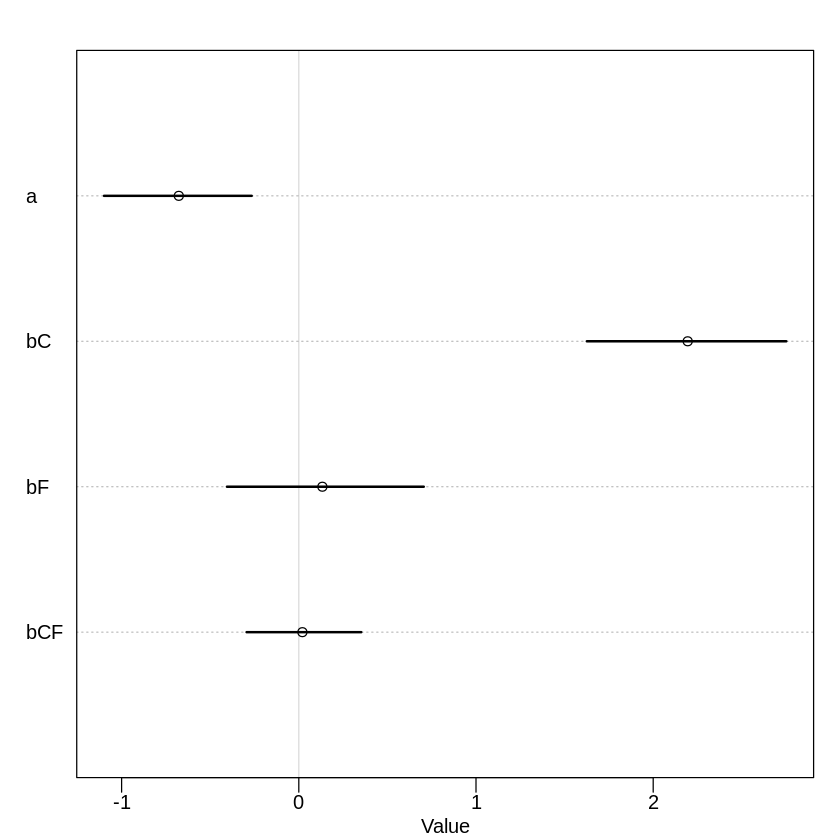

In [225]:
plot(precis(m10H4uE))

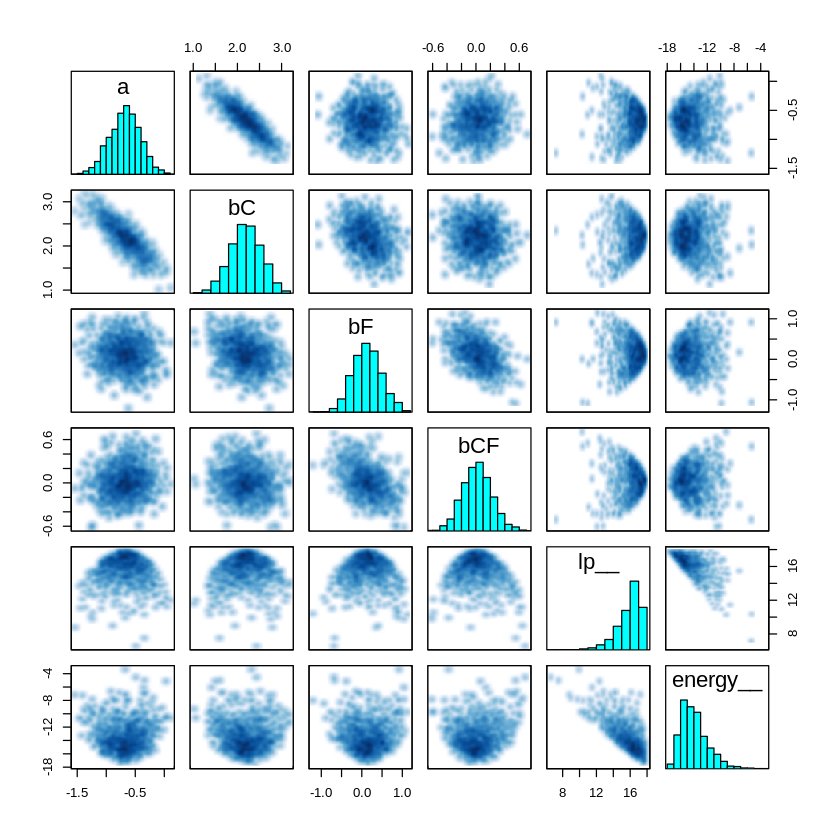

In [226]:
pairs(m10H4uE@stanfit)

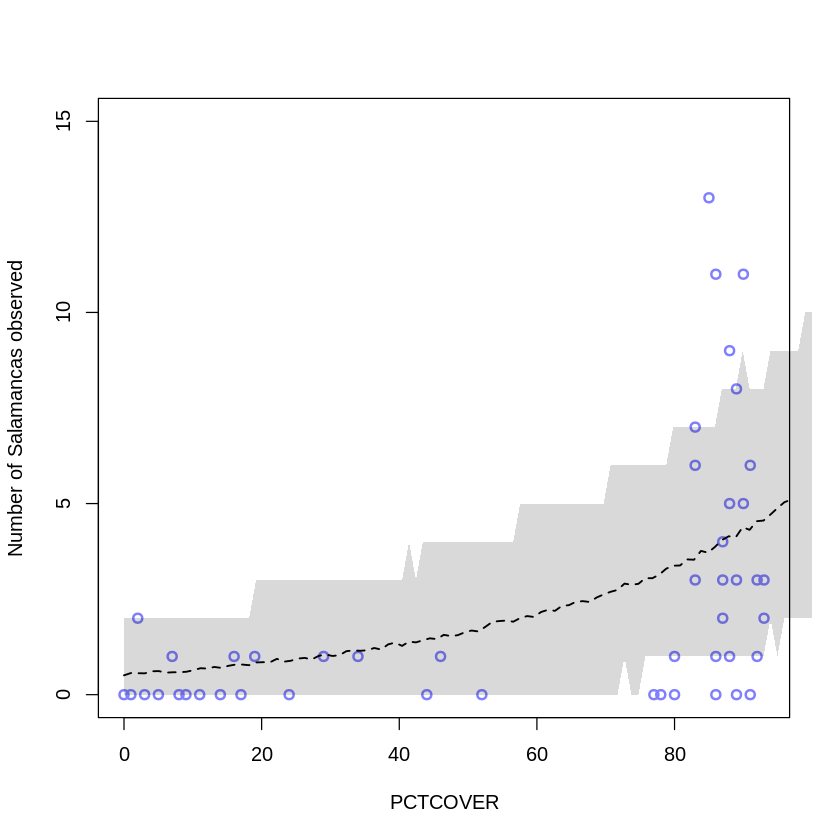

In [228]:
plot(d$PCTCOVER, d$SALAMAN, xlab="PCTCOVER", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
C_seq <- seq( from=0 , to=1 , length.out=ns )
PCTCOVseq <- 100*C_seq

#Predictions
counts <- sim( m10H4uE, data=data.frame( C=C_seq, F=C_seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(PCTCOVseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , PCTCOVseq , xpd=TRUE )

In [232]:
d$PCTCOVERstd <- standardize(d$PCTCOVER)
d$FORESTAGEstd <- standardize(d$FORESTAGE)

In [233]:
m10H4uF <- ulam(
                alist(
                    SALAMAN ~ dpois(lam),
                    log(lam) <- a + bC * PCTCOVERstd + bF * FORESTAGEstd + bCF * PCTCOVERstd * FORESTAGEstd,
                    a ~ dnorm(0, 0.5),
                    bC ~ dnorm(0, 1),
                    bF ~ dnorm(0, 1),
                    bCF ~ dnorm(0, 0.2)
                ), data=d, chains=4, cores=4
           )

precis(m10H4uF)

mean        sd        5.5%        94.5%     n_eff    Rhat    
a    0.37425797 0.1776689  0.08474946 0.6488418 838.0318 1.001681
bC   1.19891101 0.2272521  0.84812276 1.5728852 836.7563 1.002491
bF  -0.02102120 0.1817916 -0.31147962 0.2701102 802.1533 1.000052
bCF  0.02807236 0.1873409 -0.26346813 0.3320748 851.9937 0.998992

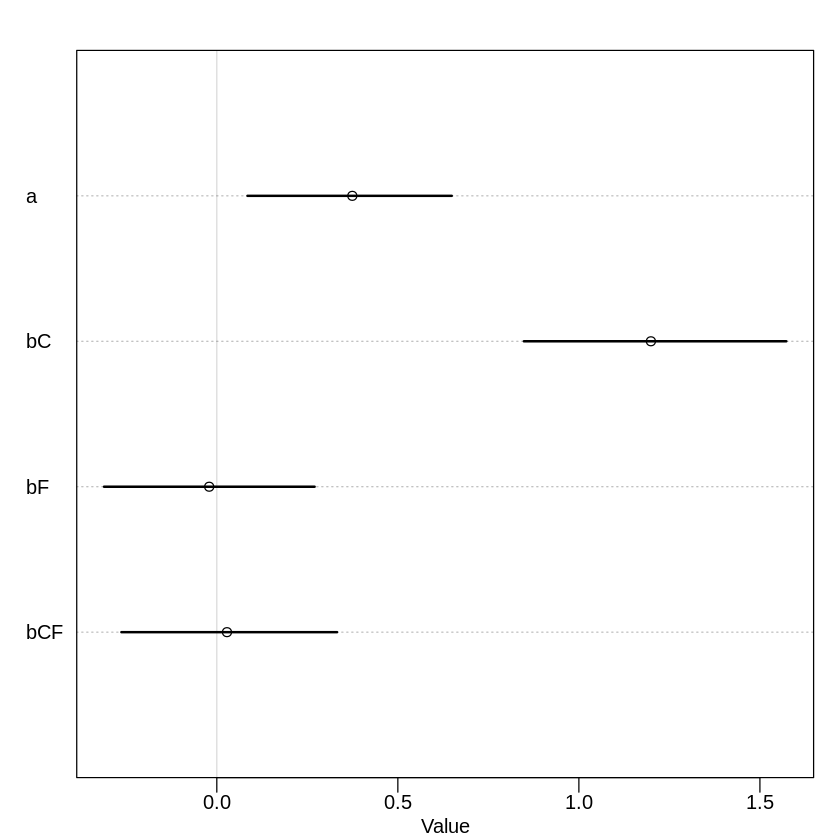

In [234]:
plot(precis(m10H4uF))

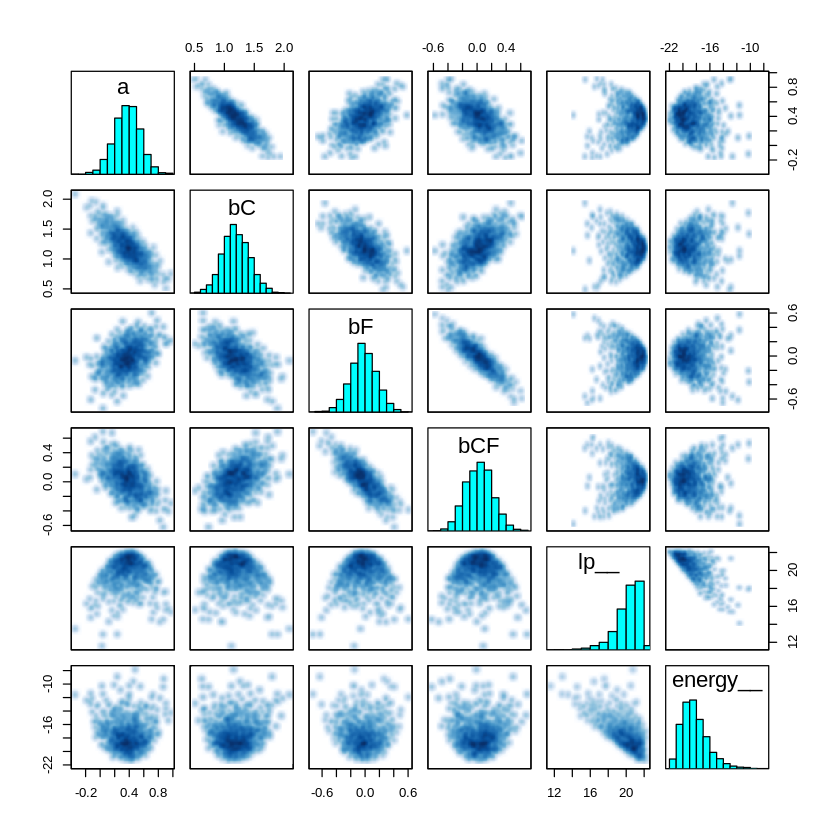

In [235]:
pairs(m10H4uF@stanfit)

Note correlation between many of the parameters now.  Also note bF and bCF are near 0 (like some of the previous models).

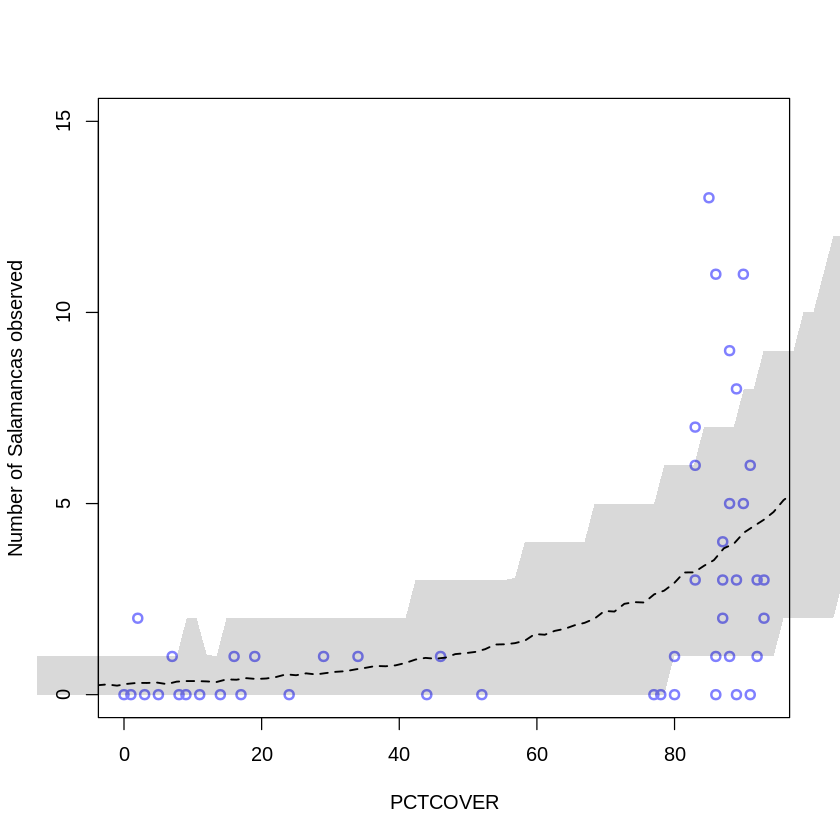

In [245]:
plot(d$PCTCOVER, d$SALAMAN, xlab="PCTCOVER", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
seq <- seq( from=-2 , to=2 , length.out=ns )
PCTCOVseq <- seq*sd(d$PCTCOVER)+mean(d$PCTCOVER)

#Predictions
counts <- sim( m10H4uF, data=data.frame( PCTCOVERstd=seq, FORESTAGEstd=seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(PCTCOVseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , PCTCOVseq , xpd=TRUE )

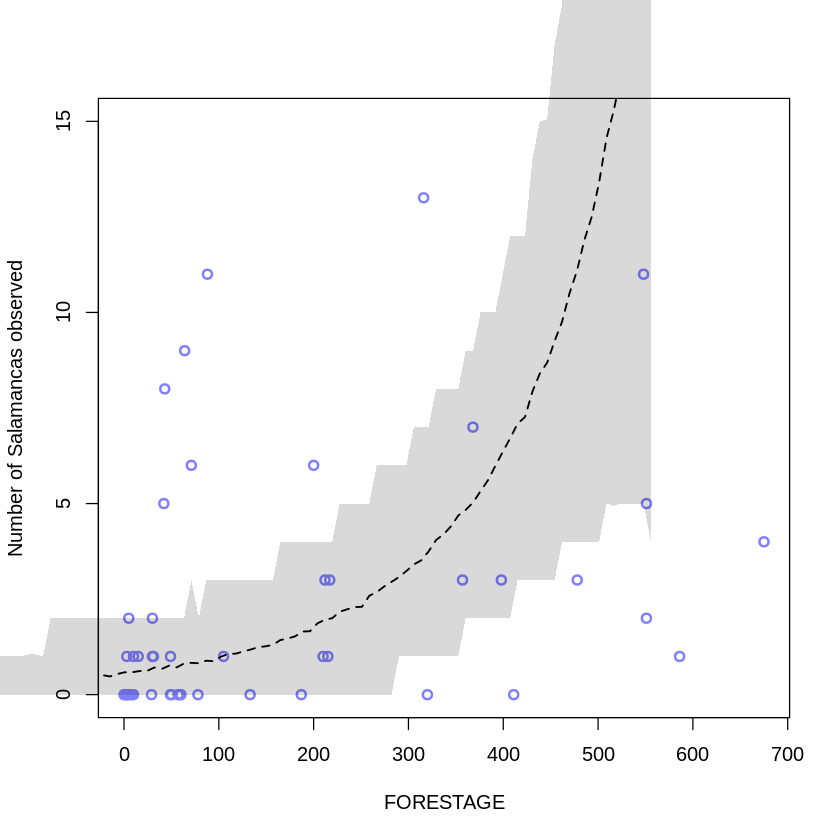

In [246]:
plot(d$FORESTAGE, d$SALAMAN, xlab="FORESTAGE", ylab="Number of Salamancas observed",
    col=rangi2, lwd=2, ylim=c(0, 15))
ns <- 100
seq <- seq( from=-2 , to=2 , length.out=ns )
FORESTAGEseq <- seq*sd(d$FORESTAGE)+mean(d$FORESTAGE)

#Predictions
counts <- sim( m10H4uF, data=data.frame( PCTCOVERstd=seq, FORESTAGEstd=seq) )
counts_mu <- apply( counts , 2 , mean )
counts_pi <- apply( counts , 2 , PI, prob=0.89 )
lines(FORESTAGEseq , counts_mu , lty=2 , lwd=1.5 )
shade(counts_pi , FORESTAGEseq , xpd=TRUE )

This dist (of Salamancas against Forestage appears almost bimodal).

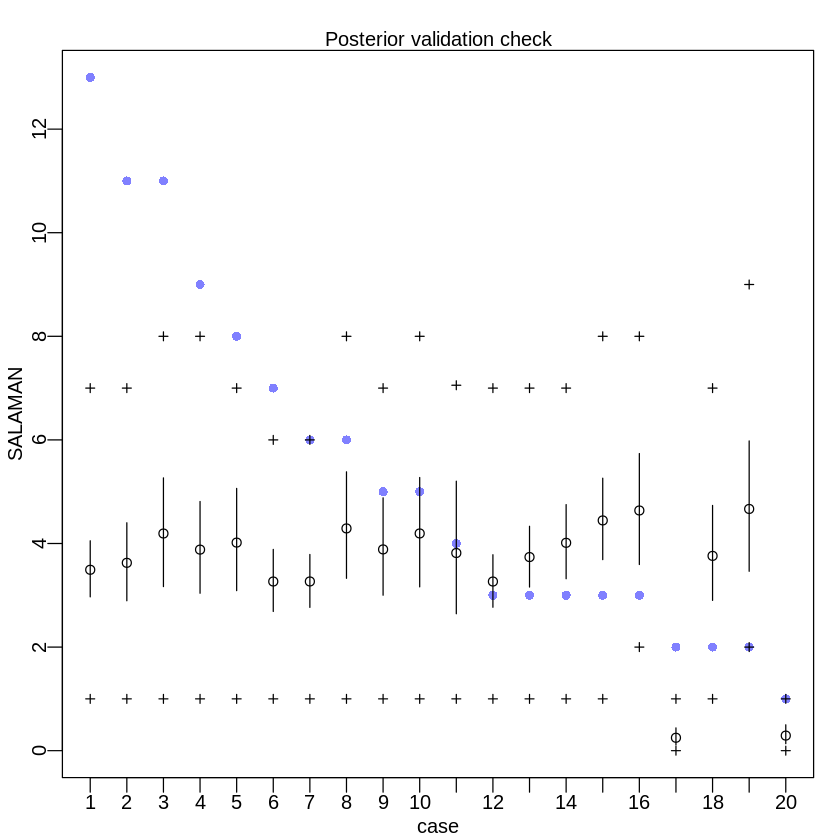

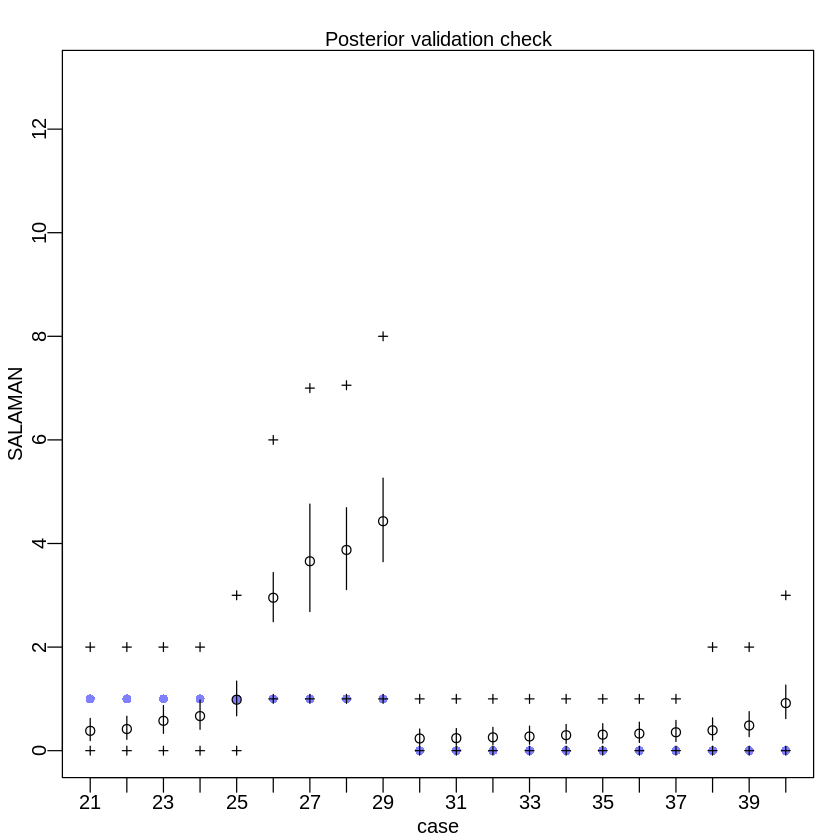

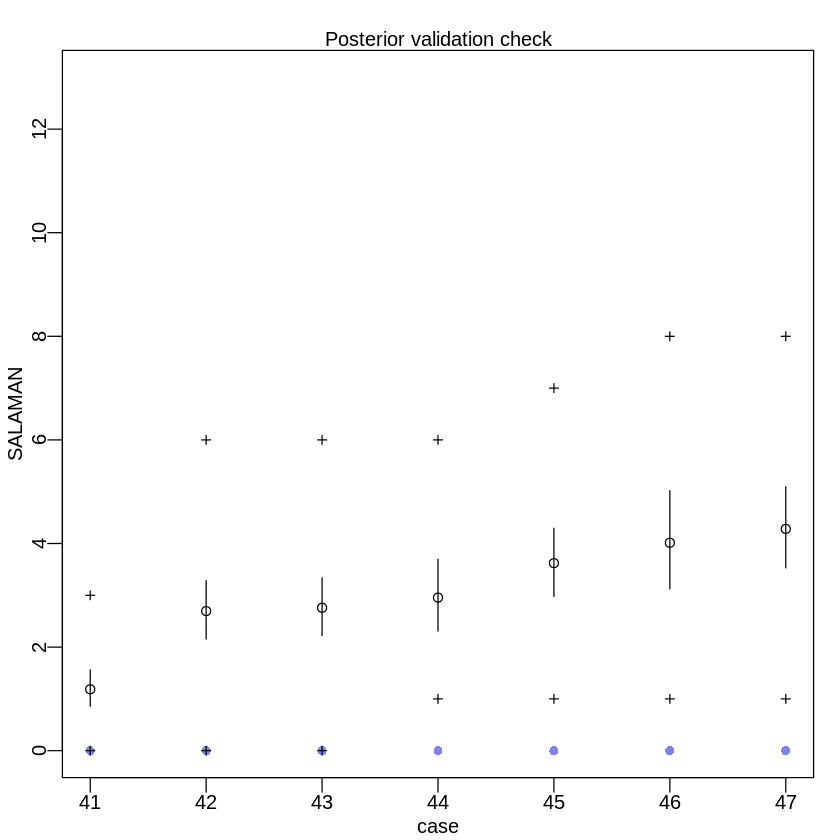

In [251]:
postcheck(m10H4uF)

From https://github.com/jffist/statistical-rethinking-solutions/blob/master/ch10_hw.R#L9:

"Adding forestage variable to the model doesn't help anyhow (One can expect that age of the trees doesn't influence life of salamanders, as they live on the ground)".

Indeed, clearly the coefficients involving the F terms hover around 0, so do not seem to explain much.